# Knowdge Distillation using Contrastive Learning


 #### Student Name: Amir Mohammad Mahfoozi


 #### Student ID:401106469


In this exercise, we aim to distill knowledge from a large monolingual model into a smaller multilingual model using contrastive learning, specifically leveraging the CLIP model loss.

We employ a small paired English-Persian dataset to define the loss pairs for our CLIP training. Given the substantial dataset size and batch size typically required for CLIP's loss computation (exceeding 19,000 samples per batch in standard tasks), which is impractical for our setup on Colab, we use a reduced batch size to focus on learning the procedure rather than achieving optimal performance, so we don't expect actual real-world results, only the training prcodure.

CLIP (Contrastive Language-Image Pretraining) is a foundational model introduced by OpenAI to bridge the gap between text and image modalities. By aligning text descriptions and corresponding images in a shared embedding space, CLIP achieves remarkable zero-shot generalization capabilities across a wide range of tasks. It is trained on a massive dataset of image-text pairs using contrastive loss, ensuring that image embeddings align closely with their corresponding textual descriptions while remaining distinct from unrelated samples. This cross-modal alignment enables CLIP to perform tasks like image retrieval, captioning, and classification with minimal fine-tuning.

The CLIP loss plays a crucial role in training the model by implementing a cross-entropy loss function in the contrastive learning framework. This loss operates on paired data, where each image-text pair is treated as a positive match, while all other pair combinations in the batch are considered negatives. The loss ensures that positive pairs receive high similarity scores, while negatives are penalized. However, achieving optimal results with CLIP loss often requires large batch sizes to provide sufficient negative samples, which can be computationally intensive. This makes training with limited resources challenging, necessitating adaptations such as smaller batch sizes or alternative strategies to approximate the training dynamics.


Knowledge distillation is a technique used in machine learning to transfer knowledge from a large, complex model (the "teacher") to a smaller, more efficient model (the "student"). The primary goal of this process is to retain the performance and accuracy of the larger model while significantly reducing computational and memory requirements. This is achieved by training the student model to mimic the outputs of the teacher model, often through techniques such as matching soft probability distributions or intermediate representations. Knowledge distillation has become an essential approach in deploying machine learning models on resource-constrained devices such as smartphones and edge devices.

In practice, knowledge distillation is not limited to replicating predictions; it can also involve transferring knowledge about internal features or learned representations.


### Challenges in Resource-Constrained Settings
CLIP’s reliance on large-scale datasets and batch sizes makes direct implementation computationally demanding. This exercise demonstrates an adaptation of the process, reducing batch size and dataset size to provide a practical understanding of the training procedure. While this approach sacrifices performance and real-world applicability, it highlights the mechanics of using CLIP loss for contrastive learning and lays the foundation for extending the process to larger datasets and batch sizes in future applications.



### About CLIP and Contrastive Learning
CLIP, developed by OpenAI, bridges the gap between text and image modalities by aligning corresponding embeddings in a shared space. It leverages contrastive loss to train on image-text pairs, ensuring that embeddings of positive pairs (e.g., an image and its corresponding caption) are highly similar, while embeddings of unrelated pairs remain distinct. The cross-entropy-based contrastive loss evaluates the similarity between positive pairs while penalizing mismatches for all other combinations within a batch.

### Key aspects of CLIP loss include:

- Positive Pairing: Encourages high similarity scores for embeddings of paired text and image data.
- Negative Sampling: Penalizes mismatched pairs within the batch, requiring large batch sizes for effective performance due to the need for a diverse set of negative samples.



## !!! Note !!! You Should Answer to all the TODOs

Also feel free to ask your questions on Quera.



## Setup


We install Required Packages.

In [1]:
!pip install -q gdown
!gdown "https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK"
!gdown "https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj"

Downloading...
From: https://drive.google.com/uc?id=1MVx_gIkX4tQ8ya2OsHt0mqLmw1Pf2CcK
To: /kaggle/working/train.csv
100%|███████████████████████████████████████| 7.35M/7.35M [00:00<00:00, 268MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Co-dwJfWw-C_ral0hoAS_X94wN-_vbCj
To: /kaggle/working/val.csv
100%|███████████████████████████████████████| 2.45M/2.45M [00:00<00:00, 164MB/s]


In [2]:
!pip install setuptools
import sys
import subprocess
import pkg_resources

def installPackages(packages):
    def installPackage(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for package in REQUIRED_PACKAGES:
        try:
            dist = pkg_resources.get_distribution(package)
            print('{} ({}) is installed'.format(dist.key, dist.version))
        except pkg_resources.DistributionNotFound:
            print('{} is NOT installed'.format(package))
            installPackage(package)
            print('{} was successfully installed.'.format(package))

REQUIRED_PACKAGES = [
    'open_clip-torch',
    'pandas',
    'numpy',
    'matplotlib',
    'transformers',
    'tqdm',
    'torch',
    'datasets',
]

installPackages(REQUIRED_PACKAGES)

import gc
import itertools
import re
import math
from collections import Counter
import random
import string
import uuid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open_clip
from open_clip import model as TE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from datasets import load_dataset, Dataset, Features, Array2D, Value
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

from tqdm import tqdm

<ipython-input-2-16d6a20cb021>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


open_clip-torch is NOT installed
open_clip-torch was successfully installed.
pandas (2.2.2) is installed
numpy (1.26.4) is installed
matplotlib (3.7.5) is installed
transformers (4.47.0) is installed
tqdm (4.67.1) is installed
torch (2.5.1+cu121) is installed
datasets (3.2.0) is installed


Beware to use cuda for training!

In [3]:
def getDevice(which="cuda:0", yellAtCpu=True):
    if torch.cuda.is_available():
        device = torch.device(which)
    else:
        if yellAtCpu:
             raise Exception("I won't run on CPU!")
        device = torch.device("cpu")

    return device

#### Configs

These are our training configurations, read them!

In [4]:
def Configs():
    return {
        "device": getDevice(),
        "reference_checkPoint" : "EVA02-E-14-plus",                # teacher
        "candidate_checkpoint" : "setu4993/smaller-LaBSE",         # student
        "train_path" : "train.csv",
        "val_path" : "val.csv",
        "save_path" : "./best-model.pth",
        "english" : "en",                                         # dont mind them
        "persian" : "fa",
        "batch_size": 32,                                        # should have been really big, but we can't here
        "lr": 1e-4,
        "epochs": 2,                                               # 40 minute per epoch
        "tok_percentile" : 99,
        "temperature": 20,
        "dropout": 0.05,
        "unfreezed_layers" : 10,
        "weight_decay": 1e-5,
        "patience": 1,
        "factor" : 0.8,
        "reference_embedding": 1024,                               # DONT MIND THESE
        "reference_context_length" : 77,
        "reference_vocab_size" : 49408,
        "reference_heads" : 20,
        "reference_width" : 1280,
        "reference_layers" : 32,
        "cls_token_index" : 0,
        "project_to" : 1024,
    }

configs = Configs()

## Question Box
### TODO (10pts)
1- Why do we use temperature in training using contrastive learning?
The temperature in contrastive learning is a scaling factor that adjusts the sharpness of similarity scores in the softmax function. Lowering the temperature makes the model focus more on the differences between similar and dissimilar pairs by amplifying the logits, whereas higher temperatures smooth out the differences. This helps in fine-tuning the training process and controlling the strength of the penalties applied to negative samples.
<br/>
2- Why do we need to freeze some layers of a model? mention 2 reasons.
Transfer Learning: Freezing pre-trained layers helps retain the knowledge already learned from a large dataset, allowing the model to focus on learning task-specific features without losing previously acquired general features.
Reduced Computational Costs: Freezing layers decreases the number of parameters that require backpropagation, speeding up training and lowering memory requirements, which is especially useful in resource-constrained environments.
<br/>
3- Read the whole code and find out what tok_percentile is used for.
The tok_percentile configuration determines the token length percentile used to define the maximum sequence length for tokenized inputs. It ensures that the majority of the input sequences (e.g., 99% of the data) fit within the model's context length, reducing padding inefficiencies while avoiding truncation of important information.



## Data and Preprocessing

In [5]:
def getDatasetsCSV(prevEnCol, prevFaCol, newEnCol, newFaCol, trainPath, valPath):
    df = pd.read_csv(trainPath)
    dfVal = pd.read_csv(valPath)

    if df.empty:
        raise ValueError("Training dataset is empty or missing")

    if dfVal.empty:
        raise ValueError("Validation dataset is empty or missing")

    dfTraind = df.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})
    dfVal = dfVal.loc[:, [prevEnCol, prevFaCol]].rename(columns={prevEnCol: newEnCol, prevFaCol: newFaCol})

    datasetTrain = Dataset.from_pandas(dfTraind)
    datasetVal = Dataset.from_pandas(dfVal)

    return datasetTrain, datasetVal

def getDsByLang(persianCol, englishCol):
    def getPersianDs(dataset):
        return dataset[persianCol]

    def getEnglishDs(dataset):
        return dataset[englishCol]

    getPersianDs.label = persianCol
    getEnglishDs.label = englishCol

    return getPersianDs, getEnglishDs

class Normalizer():
    def __init__(self):
        translation_src = ' ىكي“”0123456789%إأآئيؤةك'
        translation_dst = ' یکی""۰۱۲۳۴۵۶۷۸۹٪اااییوهک'

        self.translations = str.maketrans(translation_src, translation_dst)

        patterns = [
            (r' {2,}', ' '),  # remove extra spaces
            (r'\n+', ' '),  # replace newlines with space
            (r'\u200c+', ' '),  # replace ZWNJs with space
            (r'[ـ\r]', '')  # remove keshide, carriage returns
        ]

        self.character_refinement_patterns = [(re.compile(pattern), repl) for pattern, repl in patterns]

    def normalizeFa(self, text):
        text = text.lower().translate(self.translations)
        text = re.sub('[^a-zA-Z۰-۹آ-ی ]', ' ', text)

        for pattern, repl in self.character_refinement_patterns:
            text = pattern.sub(repl, text)
        return text.strip()

    def normalizeEn(self, text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
        return text

def applyPreprocess(datasets, configs=configs, Normalizer=Normalizer):
    def applyRowNormalization(example):
        example[configs['persian']] = normalizer.normalizeFa(example[configs['persian']])
        example[configs['english']] = normalizer.normalizeEn(example[configs['english']])

        return example

    normalizer = Normalizer()

    newDatasets = []
    for dataset in datasets:
        newDatasets.append(dataset.map(applyRowNormalization))

    return newDatasets

def preprocessSentence(text, lang, mostFreq=None, Normalizer=Normalizer, configs=configs):
    normalizer = Normalizer()
    if lang == configs['persian']:
        normalized = normalizer.normalizeFa(text)
    elif lang == configs['english']:
        normalized = normalizer.normalizeEn(text)
    else:
        raise ValueError("Not supported lang")

    return normalized

## Utils
### TODO: Complete these Utility functions (10pts)

In [6]:
def getClsToken(tensor, configs=configs):
    """
    Extracts the classification (CLS) token from the input tensor.

    Parameters:
        tensor (torch.Tensor): The input tensor of shape (batch_size, seq_length, hidden_dim).
        configs (dict): A dictionary containing configuration settings. Must include the key "cls_token_index"
                        which specifies the index of the CLS token in the sequence dimension.

    Returns:
        torch.Tensor: A tensor containing the CLS token for each example in the batch,
                      of shape (batch_size, 1, hidden_dim).
    """
    clsId = configs["cls_token_index"]
    return tensor[:, clsId, :]

def flattenMiddle(tensor):
    """
    Flattens the middle dimension (sequence length) of the input tensor, removing it.

    Parameters:
        tensor (torch.Tensor): The input tensor of shape (batch_size, seq_length, hidden_dim).

    Returns:
        torch.Tensor: A tensor of shape (batch_size, hidden_dim) with the middle dimension flattened out.
    """
    return tensor.view(tensor.size(0), -1)

def freezeModel(model):
    """
    Freeze all parameters of a given model.
    Parameters:
        model (torch.nn.Module): The PyTorch model whose parameters are to be frozen.
    """
    for param in model.parameters():
        param.requires_grad = False
    return model

In [7]:
def plotMetric(metricData, metricName):
    if metricName == None or metricName not in metricData:
        raise ValueError("No such metric")
    metricData[metricName].plot()
    plt.xlabel('Epochs')
    plt.ylabel(metricName)
    plt.title(f'Plot of {metricName}')
    plt.show()

threshold=1
def calcPrcentileTokens(dataset, tokenizer, field, percentile=configs["tok_percentile"], thershold=1):
    """
    Calculate the token length at a specific percentile for a dataset field.

    This function tokenizes the data in the specified field of the dataset and calculates
    the token length at the given percentile. An optional threshold can be added to the result.

    Parameters:
        dataset (dict or Dataset): The dataset containing the data to be tokenized.
        tokenizer (callable): A tokenizer function or object with a callable interface
                              (e.g., HuggingFace tokenizer).
        field (str): The field in the dataset whose token lengths are to be calculated.
        percentile (float, optional): The percentile to compute (default is the value in
                                       `configs["tok_percentile"]`).
        thershold (int, optional): A value to add to the calculated percentile token length
                                    (default is 1).

    Returns:
        int: The token length at the specified percentile plus the threshold.

    Raises:
        KeyError: If the specified field does not exist in the dataset.
        TypeError: If `tokenized` is not in the expected format.

    Example:
        dataset = {"text": ["This is a sentence.", "Another example sentence."]}
        tokenizer = lambda x: {"input_ids": [[1, 2, 3, 4], [5, 6, 7, 8, 9]]}
        field = "text"
        calcPrcentileTokens(dataset, tokenizer, field, percentile=95, thershold=2)

    Notes:
        - If the tokenized output is a dictionary (e.g., HuggingFace tokenizers), it assumes
          that `input_ids` contains the token sequences.
        - If the tokenized output is a tensor, nonzero token counts are used to determine lengths.
    """
    tokenized = tokenizer(dataset[field])
    if not isinstance(tokenized, torch.Tensor):
        tokenLengths = list(map(lambda sen: len(sen), tokenized['input_ids']))
    else:
        tokenLengths = [tensor.nonzero().size(0) for tensor in tokenized]
    percentileLength = np.percentile(tokenLengths, percentile)
    return int(percentileLength) + 1

# Dont Touch This
def TextEncoder(configs):
    newModel = TE.TextTransformer(context_length=configs['reference_context_length'],
                                 vocab_size=configs["reference_vocab_size"],
                                 width=configs["reference_width"],
                                 layers=configs["reference_layers"],
                                 heads=configs["reference_heads"],
                                 output_dim=configs["reference_embedding"])
    return newModel


## Models

### TODO: Compelete the Swish and LinearProjection functions based on the pydoc provided (15pts)

In [8]:
class Swish(nn.Module):
    """
    Implements the Swish activation function.
    Parameters:
        beta (float, optional): The scaling parameter for the input x in the sigmoid
                                function. Default is 1.0.
    """
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)


class LinearProjection(nn.Module):
    """
    A projection layer with Swish activation, batch normalization, dropout, and residual connections.

    This module takes an input tensor, applies a series of transformations, and produces an
    output tensor of the same shape, making use of residual connections and layer normalization.

    Parameters:
        embedding_dim (int): The dimensionality of the input embeddings.
        projection_dim (int, optional): The dimensionality of the projection. Default is
                                        `configs['project_to']`.
        dropout (float, optional): The dropout rate. Default is `configs['dropout']`.

    Layers:
        - projection: Linear layer that projects the input to the specified `projection_dim`.
        - swish: Swish activation function with a fixed beta of 1.0.
        - batch_norm: Batch normalization applied after projection.
        - fc: Fully connected layer for further transformations.
        - dropout: Dropout applied to the output of the fully connected layer.
        - layer_norm: Layer normalization applied after residual connection.

    Methods:
        forward(x):
            Applies the projection, activation, normalization, dropout, residual connection,
            and layer normalization to the input tensor.

    Example:
        model = LinearProjection(embedding_dim=128, projection_dim=64, dropout=0.1)
        output = model(input_tensor)
    """
    def __init__(self, embedding_dim, projection_dim=configs['project_to'], dropout=configs['dropout']):
        super(LinearProjection, self).__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.swish = Swish(beta=1.0)
        self.batch_norm = nn.BatchNorm1d(projection_dim)
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

        # Add a linear layer to project residual
        self.residual_projection = nn.Linear(embedding_dim, projection_dim)

    def forward(self, x):  # Project residual to match projection_dim
        x = self.projection(x)
        x = self.swish(x)
        x = self.batch_norm(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.layer_norm(x)  # Layer normalization
        return x

In [9]:
class CandidateModel(nn.Module):
    def __init__(self, model_name, unfreezeLayers, trainable=True):
        super().__init__()
        self.candidateProjection = LinearProjection(embedding_dim=configs["candidate_embedding"])
        self.configs = AutoConfig.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.batchNorm = nn.BatchNorm1d(configs["candidate_embedding"])  # Correct setup
        self.targetTokenIdx = configs["cls_token_index"]

    def forward(self, input_ids, attention_mask):
        # Obtain model output
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        clsEmbed = getClsToken(output.last_hidden_state)  # Extract CLS token

        print(f"clsEmbed shape before squeeze: {clsEmbed.shape}")
        # Flatten the tensor for BatchNorm
        clsEmbed = clsEmbed.squeeze(1)  # (batch_size, embedding_dim)

        # Apply BatchNorm
        clsEmbed = self.batchNorm(clsEmbed)

        # Apply LinearProjection
        clsEmbed = self.candidateProjection(clsEmbed)
        print(f"clsEmbed shape after squeeze: {clsEmbed.shape}")

        return clsEmbed


## Training

### TODO: Compelete the calcLoss functions based on the pydoc provided (20pts)

In [10]:
def calcLoss(batch, referenceModel, candidateModel, temperature):
    """
    Compute the loss and the number of correct predictions for a contrastive learning task.

    This function calculates a symmetric cross-entropy loss between the embeddings
    generated by a reference model and a candidate model. It also computes the
    number of correct predictions based on the alignment of the embeddings.

    Args:
        batch (dict): A batch of data containing:
            - "candidate" (torch.Tensor): Tokenized input for the candidate model.
            - "reference" (torch.Tensor): Tokenized input for the reference model.
        referenceModel (nn.Module): The model generating embeddings for the reference input.
        candidateModel (nn.Module): The model generating embeddings for the candidate input.
        temperature (float): A scaling factor to control the logits' sharpness during similarity calculation.

    Returns:
        tuple:
            - loss (torch.Tensor): The computed symmetric cross-entropy loss.
            - corrects (int): The number of correctly predicted alignments.

    Notes:
        - The embeddings are normalized to ensure their magnitudes do not impact similarity.
        - Logits represent scaled cosine similarity between reference and candidate embeddings.
        - The targets are identity matrices, assuming perfect alignment between reference and candidate inputs.

    Example Usage:
        batch = {
            "candidate": tokenized_candidate,
            "reference": tokenized_reference
        }
        loss, corrects = calcLoss(batch, reference_model, candidate_model, temperature=0.1)
    """
    # Move tokenized inputs to the specified device
    candidateTokenized = batch["candidate"].to(configs["device"])
    referenceTokenized = batch["reference"].to(configs["device"])

    # Generate embeddings from reference and candidate models
    referenceEmbeds = referenceModel(referenceTokenized)
    candidateEmbeds = candidateModel(
        input_ids=candidateTokenized["input_ids"],
        attention_mask=candidateTokenized["attention_mask"]
    )

    # Normalize embeddings to have unit length
    referenceEmbeds = F.normalize(referenceEmbeds, p=2, dim=-1)
    candidateEmbeds = F.normalize(candidateEmbeds, p=2, dim=-1)

    logits = torch.matmul(referenceEmbeds, candidateEmbeds.T) / temperature

    batch_size = logits.size(0)
    targets = torch.eye(batch_size, device=configs["device"])

    loss = (
        F.cross_entropy(logits, targets.argmax(dim=-1))
        + F.cross_entropy(logits.T, targets.argmax(dim=-1))
    ) / 2

    corrects = (logits.argmax(dim=-1) == torch.arange(batch_size, device=configs["device"])).sum().item()

    return loss, corrects


### TODO: Fill the trainLoop and valLoop (5pts)

In [11]:
def trainLoop(dataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature):
    models['candidateModel'].train()

    totalLoss = 0.0
    totalCorrects = 0

    print("Training Starts!")
    for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):

        candidteTokenized = candidateTokenizer(getPersianDs(pairs), padding='max_length', truncation=True, return_tensors="pt", max_length=configs["fa_tok_percentile"])
        referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

        batch = {
            "candidate" : candidteTokenized,
            "reference" : referenceTextTokenized
        }

        loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)
        totalCorrects += corrects
        totalLoss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("train loss", avgLoss)
    print("train accuracy", avgAccuracy)

    return avgLoss, avgAccuracy

def valLoop(dataloader, models, referenceTokenizer, candidateTokenizer, temperature):
    models['candidateModel'].eval()

    print("Testing Starts!")
    totalLoss = 0.0
    totalCorrects = 0

    with torch.no_grad():
        for (index, pairs) in tqdm(enumerate(dataloader), total=len(dataloader)):
            candidteTokenized = candidateTokenizer(getPersianDs(pairs), padding='max_length', truncation=True, return_tensors="pt", max_length=configs["fa_tok_percentile"])
            referenceTextTokenized = referenceTokenizer(getEnglishDs(pairs))

            batch = {
                "candidate" : candidteTokenized,
                "reference" : referenceTextTokenized
            }

            loss, corrects = calcLoss(batch, models['referenceModel'], models['candidateModel'], temperature)

            totalCorrects += corrects
            totalLoss += loss.item()

    avgLoss = totalLoss / len(dataloader.dataset)
    avgAccuracy = totalCorrects / len(dataloader.dataset)

    print("test loss", avgLoss)
    print("test accuracy", avgAccuracy)

    return avgLoss, avgAccuracy

In [12]:
oldCols = ["en", "fa"]
datasetTrain, datasetVal = getDatasetsCSV(oldCols[0], oldCols[1], configs["english"], configs["persian"], configs["train_path"], configs["val_path"])

getPersianDs, getEnglishDs = getDsByLang(configs["persian"], configs["english"])
print("Before Preproccess: ", datasetTrain[0])
datasetTrain, datasetVal = applyPreprocess([datasetTrain, datasetVal], configs)
print("After Preproccess: ", datasetTrain[0])
trainDataloader = DataLoader(datasetTrain, batch_size=configs['batch_size'], shuffle=True)
valDataloader = DataLoader(datasetVal, batch_size=configs['batch_size'], shuffle=False)

Before Preproccess:  {'en': 'A person doing karate in a green business card.', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز.'}


Map:   0%|          | 0/59999 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

After Preproccess:  {'en': 'a person doing karate in a green business card', 'fa': 'شخصی که کاراته انجام می دهد در کارت ویزیت سبز'}


#### Tokenizers

In [13]:
referenceTokenizer = open_clip.get_tokenizer(configs["reference_checkPoint"])

candidateConfig = AutoConfig.from_pretrained(configs["candidate_checkpoint"])
candidateTokenizer = AutoTokenizer.from_pretrained(configs["candidate_checkpoint"])

configs = configs | {"candidate_embedding" : candidateConfig.hidden_size}

faTokenPercentile = calcPrcentileTokens(datasetTrain, candidateTokenizer, configs["persian"])
faTokenPercentile

enTokenPercentile = calcPrcentileTokens(datasetTrain, referenceTokenizer, configs["english"])
enTokenPercentile

configs = configs | {"en_tok_percentile" : enTokenPercentile}
configs = configs | {"fa_tok_percentile" : faTokenPercentile}

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

#### Models

In [14]:
referenceModel = TextEncoder(configs).to(configs["device"])
candidateModel = CandidateModel(model_name=configs["candidate_checkpoint"], unfreezeLayers=configs["unfreezed_layers"]).to(configs["device"])
referenceModel = freezeModel(referenceModel)

candidateModel.to(configs['device'])
referenceModel.to(configs['device'])

models = {
    "referenceModel" : referenceModel,
    "candidateModel" : candidateModel
}

model.safetensors:   0%|          | 0.00/877M [00:00<?, ?B/s]

## Training
### TODO (10pts) for running the code and (20pts) for achieving above 70 percent test accuracy

In [15]:
temperature = torch.nn.Parameter(torch.tensor(configs['temperature']).float())
optimizer = torch.optim.AdamW(list(models['candidateModel'].parameters()) + [temperature], weight_decay=configs["weight_decay"], lr=configs['lr'])
lrScheduler = ReduceLROnPlateau(optimizer, 'max', patience=configs['patience'], factor=configs['factor'])


In [16]:

bestValAcc = float('-inf')

metrics = pd.DataFrame(columns=["Avg-train-loss", "Avg-train-accuracy","Avg-val-loss", "Avg-val-accuracy"])

for t in range(configs['epochs']):
    trainLoss, trainAcc = trainLoop(trainDataloader, models, referenceTokenizer, candidateTokenizer, optimizer, temperature)
    valLoss, valAcc = valLoop(valDataloader, models, referenceTokenizer, candidateTokenizer, temperature)

    metrics.loc[t+1] = [trainLoss, trainAcc, valLoss, valAcc]

    lrScheduler.step(valAcc)

    print("Temperature at this epoch was :", temperature)

print(f'Best accuracy of validation gained: ', bestValAcc)
print("Done!")

Training Starts!


  0%|          | 0/1875 [00:00<?, ?it/s]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 1/1875 [00:02<1:03:49,  2.04s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 2/1875 [00:03<49:34,  1.59s/it]  

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 3/1875 [00:04<45:14,  1.45s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 4/1875 [00:05<42:59,  1.38s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 5/1875 [00:07<41:48,  1.34s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 6/1875 [00:08<41:10,  1.32s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 7/1875 [00:09<40:50,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 8/1875 [00:11<40:38,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 9/1875 [00:12<40:34,  1.30s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 10/1875 [00:13<40:34,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 11/1875 [00:14<40:34,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 12/1875 [00:16<40:38,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 13/1875 [00:17<40:43,  1.31s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 14/1875 [00:18<40:49,  1.32s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 15/1875 [00:20<40:55,  1.32s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 16/1875 [00:21<40:57,  1.32s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 17/1875 [00:22<41:02,  1.33s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 18/1875 [00:24<41:09,  1.33s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 19/1875 [00:25<41:18,  1.34s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 20/1875 [00:26<41:26,  1.34s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 21/1875 [00:28<41:34,  1.35s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 22/1875 [00:29<41:34,  1.35s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 23/1875 [00:30<41:37,  1.35s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 24/1875 [00:32<41:42,  1.35s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 25/1875 [00:33<41:48,  1.36s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 26/1875 [00:35<41:57,  1.36s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 27/1875 [00:36<42:05,  1.37s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 28/1875 [00:37<42:12,  1.37s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 29/1875 [00:39<42:22,  1.38s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 30/1875 [00:40<42:28,  1.38s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 31/1875 [00:42<42:41,  1.39s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 32/1875 [00:43<42:39,  1.39s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 33/1875 [00:44<42:41,  1.39s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 34/1875 [00:46<42:47,  1.39s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 35/1875 [00:47<42:55,  1.40s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 36/1875 [00:49<43:00,  1.40s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 37/1875 [00:50<43:07,  1.41s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 38/1875 [00:51<43:16,  1.41s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 39/1875 [00:53<43:27,  1.42s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 40/1875 [00:54<43:37,  1.43s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 41/1875 [00:56<43:47,  1.43s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 42/1875 [00:57<43:58,  1.44s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 43/1875 [00:59<44:10,  1.45s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 44/1875 [01:00<44:20,  1.45s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 45/1875 [01:02<44:29,  1.46s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 46/1875 [01:03<44:46,  1.47s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 47/1875 [01:05<45:14,  1.48s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 48/1875 [01:06<45:41,  1.50s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 49/1875 [01:08<46:01,  1.51s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 50/1875 [01:09<46:14,  1.52s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 51/1875 [01:11<46:21,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 52/1875 [01:12<46:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 53/1875 [01:14<46:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 54/1875 [01:15<46:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 55/1875 [01:17<47:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 56/1875 [01:19<47:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 57/1875 [01:20<47:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 58/1875 [01:22<47:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 59/1875 [01:23<47:07,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 60/1875 [01:25<46:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 61/1875 [01:26<46:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 62/1875 [01:28<46:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 63/1875 [01:29<46:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 64/1875 [01:31<46:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 65/1875 [01:33<46:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 66/1875 [01:34<46:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 67/1875 [01:36<46:51,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 68/1875 [01:37<46:59,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 69/1875 [01:39<47:05,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 70/1875 [01:40<47:09,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 71/1875 [01:42<47:21,  1.58s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 72/1875 [01:44<47:38,  1.59s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 73/1875 [01:45<47:59,  1.60s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 74/1875 [01:47<48:23,  1.61s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 75/1875 [01:48<48:48,  1.63s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 76/1875 [01:50<49:05,  1.64s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 77/1875 [01:52<49:23,  1.65s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 78/1875 [01:54<49:48,  1.66s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 79/1875 [01:55<50:09,  1.68s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 80/1875 [01:57<50:31,  1.69s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 81/1875 [01:59<50:49,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 82/1875 [02:00<51:04,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 83/1875 [02:02<51:25,  1.72s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 84/1875 [02:04<51:40,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 85/1875 [02:06<51:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 86/1875 [02:07<52:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 87/1875 [02:09<52:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 88/1875 [02:11<52:52,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 89/1875 [02:13<53:12,  1.79s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 90/1875 [02:15<53:38,  1.80s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 91/1875 [02:17<54:02,  1.82s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 92/1875 [02:18<54:26,  1.83s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 93/1875 [02:20<54:29,  1.83s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 94/1875 [02:22<55:01,  1.85s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 95/1875 [02:24<55:26,  1.87s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 96/1875 [02:26<55:45,  1.88s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 97/1875 [02:28<55:57,  1.89s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 98/1875 [02:30<55:52,  1.89s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 99/1875 [02:32<55:31,  1.88s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 100/1875 [02:33<55:06,  1.86s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 101/1875 [02:35<54:32,  1.84s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 102/1875 [02:37<54:00,  1.83s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 103/1875 [02:39<53:30,  1.81s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 104/1875 [02:41<52:59,  1.80s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 105/1875 [02:42<52:31,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 106/1875 [02:44<52:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 107/1875 [02:46<51:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 108/1875 [02:48<51:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 109/1875 [02:49<51:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 110/1875 [02:51<50:59,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 111/1875 [02:53<50:46,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 112/1875 [02:54<50:34,  1.72s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 113/1875 [02:56<50:20,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 114/1875 [02:58<50:10,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 115/1875 [02:59<50:00,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 116/1875 [03:01<49:56,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 117/1875 [03:03<49:50,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 118/1875 [03:05<49:46,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 119/1875 [03:06<49:38,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 120/1875 [03:08<49:38,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 121/1875 [03:10<49:37,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 122/1875 [03:11<49:36,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 123/1875 [03:13<49:39,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 124/1875 [03:15<49:38,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 125/1875 [03:16<49:43,  1.70s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 126/1875 [03:18<49:43,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 127/1875 [03:20<49:45,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 128/1875 [03:22<49:50,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 129/1875 [03:23<49:53,  1.71s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 130/1875 [03:25<50:02,  1.72s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 131/1875 [03:27<50:10,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 132/1875 [03:29<50:16,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 133/1875 [03:30<50:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 134/1875 [03:32<50:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 135/1875 [03:34<50:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 136/1875 [03:36<50:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 137/1875 [03:37<50:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 138/1875 [03:39<50:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 139/1875 [03:41<51:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 140/1875 [03:43<51:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 141/1875 [03:44<51:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 142/1875 [03:46<51:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 143/1875 [03:48<51:17,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 144/1875 [03:50<51:17,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 145/1875 [03:52<51:14,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 146/1875 [03:53<51:14,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 147/1875 [03:55<51:12,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 148/1875 [03:57<51:11,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 149/1875 [03:59<51:06,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 150/1875 [04:00<51:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 151/1875 [04:02<50:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 152/1875 [04:04<50:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 153/1875 [04:06<50:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 154/1875 [04:07<50:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 155/1875 [04:09<50:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 156/1875 [04:11<50:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 157/1875 [04:13<50:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 158/1875 [04:14<50:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 159/1875 [04:16<50:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 160/1875 [04:18<50:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 161/1875 [04:20<49:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 162/1875 [04:21<49:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 163/1875 [04:23<49:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 164/1875 [04:25<49:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 165/1875 [04:27<49:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 166/1875 [04:28<49:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 167/1875 [04:30<49:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 168/1875 [04:32<49:21,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 169/1875 [04:34<49:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 170/1875 [04:35<49:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 171/1875 [04:37<49:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 172/1875 [04:39<49:14,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 173/1875 [04:41<49:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 174/1875 [04:42<49:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 175/1875 [04:44<49:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 176/1875 [04:46<49:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 177/1875 [04:48<49:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 178/1875 [04:49<49:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 179/1875 [04:51<49:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 180/1875 [04:53<49:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 181/1875 [04:55<49:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 182/1875 [04:56<49:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 183/1875 [04:58<49:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 184/1875 [05:00<49:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 185/1875 [05:02<49:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 186/1875 [05:03<49:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 187/1875 [05:05<49:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 188/1875 [05:07<49:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 189/1875 [05:09<49:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 190/1875 [05:10<49:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 191/1875 [05:12<49:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 192/1875 [05:14<49:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 193/1875 [05:16<49:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 194/1875 [05:17<49:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 195/1875 [05:19<49:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 196/1875 [05:21<49:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 197/1875 [05:23<49:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 198/1875 [05:24<49:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 199/1875 [05:26<49:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 200/1875 [05:28<49:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 201/1875 [05:30<49:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 202/1875 [05:32<49:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 203/1875 [05:33<49:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 204/1875 [05:35<49:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 205/1875 [05:37<49:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 206/1875 [05:39<49:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 207/1875 [05:40<49:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 208/1875 [05:42<49:20,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 209/1875 [05:44<49:19,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 210/1875 [05:46<49:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 211/1875 [05:48<49:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 212/1875 [05:49<49:13,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 213/1875 [05:51<49:11,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 214/1875 [05:53<49:09,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 215/1875 [05:55<49:08,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 216/1875 [05:56<49:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 217/1875 [05:58<49:05,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 218/1875 [06:00<49:06,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 219/1875 [06:02<49:04,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 220/1875 [06:04<49:02,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 221/1875 [06:05<48:59,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 222/1875 [06:07<48:57,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 223/1875 [06:09<48:53,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 224/1875 [06:11<48:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 225/1875 [06:12<48:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 226/1875 [06:14<48:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 227/1875 [06:16<48:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 228/1875 [06:18<48:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 229/1875 [06:19<48:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 230/1875 [06:21<48:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 231/1875 [06:23<48:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 232/1875 [06:25<48:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 233/1875 [06:26<48:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 234/1875 [06:28<48:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 235/1875 [06:30<48:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 236/1875 [06:32<48:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 237/1875 [06:34<48:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 238/1875 [06:35<47:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 239/1875 [06:37<47:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 240/1875 [06:39<47:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 241/1875 [06:41<47:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 242/1875 [06:42<47:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 243/1875 [06:44<47:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 244/1875 [06:46<47:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 245/1875 [06:48<47:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 246/1875 [06:49<47:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 247/1875 [06:51<47:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 248/1875 [06:53<47:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 249/1875 [06:55<47:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 250/1875 [06:56<47:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 251/1875 [06:58<47:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 252/1875 [07:00<47:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 253/1875 [07:02<47:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 254/1875 [07:03<47:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 255/1875 [07:05<47:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 256/1875 [07:07<47:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 257/1875 [07:09<47:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 258/1875 [07:10<46:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 259/1875 [07:12<46:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 260/1875 [07:14<46:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 261/1875 [07:15<46:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 262/1875 [07:17<46:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 263/1875 [07:19<46:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 264/1875 [07:21<46:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 265/1875 [07:22<46:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 266/1875 [07:24<46:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 267/1875 [07:26<46:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 268/1875 [07:28<46:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 269/1875 [07:29<46:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 270/1875 [07:31<46:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 271/1875 [07:33<46:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 272/1875 [07:35<46:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 273/1875 [07:36<46:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 274/1875 [07:38<46:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 275/1875 [07:40<46:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 276/1875 [07:42<46:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 277/1875 [07:43<46:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 278/1875 [07:45<46:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 279/1875 [07:47<46:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 280/1875 [07:49<46:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 281/1875 [07:50<46:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 282/1875 [07:52<46:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 283/1875 [07:54<46:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 284/1875 [07:56<46:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 285/1875 [07:57<46:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 286/1875 [07:59<46:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 287/1875 [08:01<46:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 288/1875 [08:03<46:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 289/1875 [08:04<46:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 290/1875 [08:06<46:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 291/1875 [08:08<46:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 292/1875 [08:10<46:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 293/1875 [08:11<46:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 294/1875 [08:13<46:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 295/1875 [08:15<46:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 296/1875 [08:17<46:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 297/1875 [08:18<45:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 298/1875 [08:20<45:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 299/1875 [08:22<45:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 300/1875 [08:24<45:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 301/1875 [08:25<45:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 302/1875 [08:27<45:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 303/1875 [08:29<45:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 304/1875 [08:31<45:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 305/1875 [08:32<45:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 306/1875 [08:34<45:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 307/1875 [08:36<45:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 308/1875 [08:38<45:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 309/1875 [08:39<45:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 310/1875 [08:41<45:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 311/1875 [08:43<45:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 312/1875 [08:45<45:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 313/1875 [08:46<45:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 314/1875 [08:48<45:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 315/1875 [08:50<45:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 316/1875 [08:52<45:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 317/1875 [08:53<45:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 318/1875 [08:55<45:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 319/1875 [08:57<45:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 320/1875 [08:59<45:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 321/1875 [09:00<45:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 322/1875 [09:02<45:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 323/1875 [09:04<45:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 324/1875 [09:06<45:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 325/1875 [09:07<45:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 326/1875 [09:09<45:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 327/1875 [09:11<45:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 328/1875 [09:13<45:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 329/1875 [09:14<45:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 330/1875 [09:16<45:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 331/1875 [09:18<45:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 332/1875 [09:20<45:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 333/1875 [09:21<45:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 334/1875 [09:23<45:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 335/1875 [09:25<45:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 336/1875 [09:27<45:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 337/1875 [09:28<45:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 338/1875 [09:30<44:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 339/1875 [09:32<44:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 340/1875 [09:34<44:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 341/1875 [09:35<44:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 342/1875 [09:37<44:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 343/1875 [09:39<44:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 344/1875 [09:41<44:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 345/1875 [09:42<44:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 346/1875 [09:44<44:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 347/1875 [09:46<44:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 348/1875 [09:48<44:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 349/1875 [09:49<44:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 350/1875 [09:51<44:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 351/1875 [09:53<44:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 352/1875 [09:55<44:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 353/1875 [09:56<44:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 354/1875 [09:58<44:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 355/1875 [10:00<44:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 356/1875 [10:02<44:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 357/1875 [10:03<44:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 358/1875 [10:05<44:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 359/1875 [10:07<44:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 360/1875 [10:09<44:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 361/1875 [10:10<44:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 362/1875 [10:12<44:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 363/1875 [10:14<44:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 364/1875 [10:16<43:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 365/1875 [10:17<43:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 366/1875 [10:19<43:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 367/1875 [10:21<43:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 368/1875 [10:23<43:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 369/1875 [10:24<43:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 370/1875 [10:26<43:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 371/1875 [10:28<43:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 372/1875 [10:30<43:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 373/1875 [10:31<43:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 374/1875 [10:33<43:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 375/1875 [10:35<43:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 376/1875 [10:37<43:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 377/1875 [10:38<43:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 378/1875 [10:40<43:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 379/1875 [10:42<43:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 380/1875 [10:44<43:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 381/1875 [10:45<43:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 382/1875 [10:47<43:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 383/1875 [10:49<43:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 384/1875 [10:51<43:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 385/1875 [10:52<43:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 386/1875 [10:54<43:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 387/1875 [10:56<43:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 388/1875 [10:58<43:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 389/1875 [10:59<43:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 390/1875 [11:01<43:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 391/1875 [11:03<43:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 392/1875 [11:05<43:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 393/1875 [11:06<43:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 394/1875 [11:08<43:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 395/1875 [11:10<43:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 396/1875 [11:12<43:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 397/1875 [11:13<43:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 398/1875 [11:15<43:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 399/1875 [11:17<43:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 400/1875 [11:19<42:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 401/1875 [11:20<42:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 402/1875 [11:22<42:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 403/1875 [11:24<42:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 404/1875 [11:26<42:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 405/1875 [11:27<42:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 406/1875 [11:29<42:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 407/1875 [11:31<42:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 408/1875 [11:33<42:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 409/1875 [11:34<42:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 410/1875 [11:36<42:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 411/1875 [11:38<42:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 412/1875 [11:40<42:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 413/1875 [11:41<42:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 414/1875 [11:43<42:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 415/1875 [11:45<42:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 416/1875 [11:47<42:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 417/1875 [11:48<42:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 418/1875 [11:50<42:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 419/1875 [11:52<42:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 420/1875 [11:54<42:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 421/1875 [11:55<42:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 422/1875 [11:57<42:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 423/1875 [11:59<42:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 424/1875 [12:00<42:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 425/1875 [12:02<42:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 426/1875 [12:04<42:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 427/1875 [12:06<42:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 428/1875 [12:07<42:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 429/1875 [12:09<42:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 430/1875 [12:11<41:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 431/1875 [12:13<41:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 432/1875 [12:14<41:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 433/1875 [12:16<41:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 434/1875 [12:18<41:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 435/1875 [12:20<41:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 436/1875 [12:21<41:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 437/1875 [12:23<41:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 438/1875 [12:25<41:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 439/1875 [12:27<41:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 440/1875 [12:28<41:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 441/1875 [12:30<41:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 442/1875 [12:32<41:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 443/1875 [12:34<41:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 444/1875 [12:35<41:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 445/1875 [12:37<41:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 446/1875 [12:39<41:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 447/1875 [12:41<41:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 448/1875 [12:42<41:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 449/1875 [12:44<41:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 450/1875 [12:46<41:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 451/1875 [12:48<41:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 452/1875 [12:49<41:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 453/1875 [12:51<41:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 454/1875 [12:53<41:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 455/1875 [12:55<41:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 456/1875 [12:56<41:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 457/1875 [12:58<41:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 458/1875 [13:00<41:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 459/1875 [13:02<41:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 460/1875 [13:03<41:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 461/1875 [13:05<41:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 462/1875 [13:07<41:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 463/1875 [13:09<41:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 464/1875 [13:10<41:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 465/1875 [13:12<41:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 466/1875 [13:14<41:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 467/1875 [13:16<41:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 468/1875 [13:17<41:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 469/1875 [13:19<41:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 470/1875 [13:21<41:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 471/1875 [13:23<41:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 472/1875 [13:24<41:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 473/1875 [13:26<41:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 474/1875 [13:28<41:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 475/1875 [13:30<40:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 476/1875 [13:31<40:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 477/1875 [13:33<40:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 478/1875 [13:35<40:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 479/1875 [13:37<40:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 480/1875 [13:38<40:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 481/1875 [13:40<40:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 482/1875 [13:42<40:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 483/1875 [13:44<40:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 484/1875 [13:46<40:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 485/1875 [13:47<40:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 486/1875 [13:49<40:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 487/1875 [13:51<40:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 488/1875 [13:53<40:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 489/1875 [13:54<40:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 490/1875 [13:56<40:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 491/1875 [13:58<40:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 492/1875 [14:00<40:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 493/1875 [14:01<40:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 494/1875 [14:03<40:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 495/1875 [14:05<40:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 496/1875 [14:07<40:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 497/1875 [14:08<40:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 498/1875 [14:10<40:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 499/1875 [14:12<40:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 500/1875 [14:14<40:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 501/1875 [14:15<40:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 502/1875 [14:17<40:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 503/1875 [14:19<40:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 504/1875 [14:21<40:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 505/1875 [14:22<40:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 506/1875 [14:24<40:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 507/1875 [14:26<40:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 508/1875 [14:28<40:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 509/1875 [14:30<40:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 510/1875 [14:31<40:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 511/1875 [14:33<40:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 512/1875 [14:35<40:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 513/1875 [14:37<40:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 514/1875 [14:38<40:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 515/1875 [14:40<40:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 516/1875 [14:42<39:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 517/1875 [14:44<39:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 518/1875 [14:45<39:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 519/1875 [14:47<39:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 520/1875 [14:49<39:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 521/1875 [14:51<39:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 522/1875 [14:52<39:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 523/1875 [14:54<39:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 524/1875 [14:56<39:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 525/1875 [14:58<39:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 526/1875 [15:00<39:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 527/1875 [15:01<39:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 528/1875 [15:03<39:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 529/1875 [15:05<39:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 530/1875 [15:07<39:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 531/1875 [15:08<39:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 532/1875 [15:10<39:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 533/1875 [15:12<39:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 534/1875 [15:14<39:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 535/1875 [15:15<39:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 536/1875 [15:17<39:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 537/1875 [15:19<39:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 538/1875 [15:21<39:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 539/1875 [15:23<39:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 540/1875 [15:24<39:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 541/1875 [15:26<39:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 542/1875 [15:28<39:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 543/1875 [15:30<39:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 544/1875 [15:31<39:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 545/1875 [15:33<39:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 546/1875 [15:35<39:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 547/1875 [15:37<39:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 548/1875 [15:39<39:17,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 549/1875 [15:40<39:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 550/1875 [15:42<39:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 551/1875 [15:44<39:08,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 552/1875 [15:46<39:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 553/1875 [15:47<39:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 554/1875 [15:49<39:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 555/1875 [15:51<39:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 556/1875 [15:53<38:57,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 557/1875 [15:54<38:57,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 558/1875 [15:56<38:54,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 559/1875 [15:58<38:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 560/1875 [16:00<38:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 561/1875 [16:02<38:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 562/1875 [16:03<38:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 563/1875 [16:05<38:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 564/1875 [16:07<38:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 565/1875 [16:09<38:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 566/1875 [16:10<38:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 567/1875 [16:12<38:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 568/1875 [16:14<38:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 569/1875 [16:16<38:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 570/1875 [16:17<38:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 571/1875 [16:19<38:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 572/1875 [16:21<38:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 573/1875 [16:23<38:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 574/1875 [16:24<38:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 575/1875 [16:26<38:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 576/1875 [16:28<38:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 577/1875 [16:30<38:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 578/1875 [16:32<38:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 579/1875 [16:33<38:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 580/1875 [16:35<38:08,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 581/1875 [16:37<38:06,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 582/1875 [16:39<38:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 583/1875 [16:40<37:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 584/1875 [16:42<37:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 585/1875 [16:44<37:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 586/1875 [16:46<37:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 587/1875 [16:47<37:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 588/1875 [16:49<37:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 589/1875 [16:51<37:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 590/1875 [16:53<37:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 591/1875 [16:54<37:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 592/1875 [16:56<37:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 593/1875 [16:58<37:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 594/1875 [17:00<37:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 595/1875 [17:02<37:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 596/1875 [17:03<37:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 597/1875 [17:05<37:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 598/1875 [17:07<37:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 599/1875 [17:09<37:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 600/1875 [17:10<37:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 601/1875 [17:12<37:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 602/1875 [17:14<37:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 603/1875 [17:16<37:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 604/1875 [17:17<37:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 605/1875 [17:19<37:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 606/1875 [17:21<37:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 607/1875 [17:23<37:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 608/1875 [17:24<37:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 609/1875 [17:26<37:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 610/1875 [17:28<37:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 611/1875 [17:30<37:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 612/1875 [17:31<37:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 613/1875 [17:33<37:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 614/1875 [17:35<36:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 615/1875 [17:37<36:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 616/1875 [17:39<36:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 617/1875 [17:40<36:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 618/1875 [17:42<36:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 619/1875 [17:44<36:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 620/1875 [17:46<36:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 621/1875 [17:47<36:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 622/1875 [17:49<36:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 623/1875 [17:51<36:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 624/1875 [17:53<36:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 625/1875 [17:54<36:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 626/1875 [17:56<36:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 627/1875 [17:58<36:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 628/1875 [18:00<36:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 629/1875 [18:01<36:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 630/1875 [18:03<36:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 631/1875 [18:05<36:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 632/1875 [18:07<36:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 633/1875 [18:08<36:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 634/1875 [18:10<36:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 635/1875 [18:12<36:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 636/1875 [18:14<36:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 637/1875 [18:15<36:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 638/1875 [18:17<36:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 639/1875 [18:19<36:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 640/1875 [18:21<36:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 641/1875 [18:23<36:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 642/1875 [18:24<36:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 643/1875 [18:26<36:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 644/1875 [18:28<36:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 645/1875 [18:30<36:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 646/1875 [18:31<36:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 647/1875 [18:33<36:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 648/1875 [18:35<35:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 649/1875 [18:37<35:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 650/1875 [18:38<35:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 651/1875 [18:40<35:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 652/1875 [18:42<35:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 653/1875 [18:44<35:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 654/1875 [18:45<35:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 655/1875 [18:47<35:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 656/1875 [18:49<35:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 657/1875 [18:51<35:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 658/1875 [18:52<35:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 659/1875 [18:54<35:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 660/1875 [18:56<35:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 661/1875 [18:58<35:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 662/1875 [18:59<35:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 663/1875 [19:01<35:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 664/1875 [19:03<35:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 665/1875 [19:05<35:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 666/1875 [19:06<35:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 667/1875 [19:08<35:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 668/1875 [19:10<35:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 669/1875 [19:12<35:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 670/1875 [19:13<35:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 671/1875 [19:15<35:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 672/1875 [19:17<35:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 673/1875 [19:19<35:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 674/1875 [19:20<35:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 675/1875 [19:22<34:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 676/1875 [19:24<34:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 677/1875 [19:26<34:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 678/1875 [19:27<34:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 679/1875 [19:29<34:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 680/1875 [19:31<34:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 681/1875 [19:33<34:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 682/1875 [19:34<34:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 683/1875 [19:36<34:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 684/1875 [19:38<34:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 685/1875 [19:40<34:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 686/1875 [19:41<34:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 687/1875 [19:43<34:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 688/1875 [19:45<34:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 689/1875 [19:47<34:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 690/1875 [19:48<34:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 691/1875 [19:50<34:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 692/1875 [19:52<34:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 693/1875 [19:54<34:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 694/1875 [19:55<34:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 695/1875 [19:57<34:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 696/1875 [19:59<34:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 697/1875 [20:01<34:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 698/1875 [20:02<34:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 699/1875 [20:04<34:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 700/1875 [20:06<34:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 701/1875 [20:08<34:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 702/1875 [20:09<34:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 703/1875 [20:11<34:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 704/1875 [20:13<34:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 705/1875 [20:15<33:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 706/1875 [20:16<33:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 707/1875 [20:18<33:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 708/1875 [20:20<33:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 709/1875 [20:21<33:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 710/1875 [20:23<33:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 711/1875 [20:25<33:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 712/1875 [20:27<33:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 713/1875 [20:28<33:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 714/1875 [20:30<33:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 715/1875 [20:32<33:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 716/1875 [20:34<33:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 717/1875 [20:35<33:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 718/1875 [20:37<33:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 719/1875 [20:39<33:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 720/1875 [20:41<33:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 721/1875 [20:42<33:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 722/1875 [20:44<33:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 723/1875 [20:46<33:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 724/1875 [20:48<33:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 725/1875 [20:49<33:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 726/1875 [20:51<33:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 727/1875 [20:53<33:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 728/1875 [20:55<33:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 729/1875 [20:56<33:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 730/1875 [20:58<33:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 731/1875 [21:00<33:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 732/1875 [21:01<33:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 733/1875 [21:03<33:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 734/1875 [21:05<33:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 735/1875 [21:07<33:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 736/1875 [21:08<32:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 737/1875 [21:10<32:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 738/1875 [21:12<32:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 739/1875 [21:14<32:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 740/1875 [21:15<32:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 741/1875 [21:17<32:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 742/1875 [21:19<32:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 743/1875 [21:21<32:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 744/1875 [21:22<32:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 745/1875 [21:24<32:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 746/1875 [21:26<32:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 747/1875 [21:28<32:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 748/1875 [21:29<32:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 749/1875 [21:31<32:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 750/1875 [21:33<32:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 751/1875 [21:35<32:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 752/1875 [21:36<32:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 753/1875 [21:38<32:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 754/1875 [21:40<32:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 755/1875 [21:41<32:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 756/1875 [21:43<32:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 757/1875 [21:45<32:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 758/1875 [21:47<32:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 759/1875 [21:48<32:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 760/1875 [21:50<32:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 761/1875 [21:52<32:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 762/1875 [21:54<32:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 763/1875 [21:55<32:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 764/1875 [21:57<32:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 765/1875 [21:59<32:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 766/1875 [22:01<32:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 767/1875 [22:03<32:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 768/1875 [22:04<32:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 769/1875 [22:06<32:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 770/1875 [22:08<32:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 771/1875 [22:10<32:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 772/1875 [22:11<32:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 773/1875 [22:13<32:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 774/1875 [22:15<32:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 775/1875 [22:17<32:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 776/1875 [22:18<32:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 777/1875 [22:20<32:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 778/1875 [22:22<32:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 779/1875 [22:24<32:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 780/1875 [22:25<32:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 781/1875 [22:27<32:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 782/1875 [22:29<32:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 783/1875 [22:31<32:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 784/1875 [22:32<32:06,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 785/1875 [22:34<32:06,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 786/1875 [22:36<32:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 787/1875 [22:38<32:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 788/1875 [22:40<32:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 789/1875 [22:41<32:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 790/1875 [22:43<32:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 791/1875 [22:45<31:59,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 792/1875 [22:47<31:59,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 793/1875 [22:48<31:59,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 794/1875 [22:50<31:54,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 795/1875 [22:52<31:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 796/1875 [22:54<31:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 797/1875 [22:55<31:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 798/1875 [22:57<31:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 799/1875 [22:59<31:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 800/1875 [23:01<31:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 801/1875 [23:03<31:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 802/1875 [23:04<31:44,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 803/1875 [23:06<31:44,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 804/1875 [23:08<31:42,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 805/1875 [23:10<31:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 806/1875 [23:11<31:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 807/1875 [23:13<31:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 808/1875 [23:15<31:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 809/1875 [23:17<31:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 810/1875 [23:19<31:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 811/1875 [23:20<31:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 812/1875 [23:22<31:25,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 813/1875 [23:24<31:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 814/1875 [23:26<31:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 815/1875 [23:27<31:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 816/1875 [23:29<31:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 817/1875 [23:31<31:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 818/1875 [23:33<31:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 819/1875 [23:35<31:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 820/1875 [23:36<31:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 821/1875 [23:38<31:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 822/1875 [23:40<31:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 823/1875 [23:42<31:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 824/1875 [23:43<31:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 825/1875 [23:45<30:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 826/1875 [23:47<30:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 827/1875 [23:49<30:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 828/1875 [23:50<30:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 829/1875 [23:52<30:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 830/1875 [23:54<30:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 831/1875 [23:56<30:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 832/1875 [23:58<30:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 833/1875 [23:59<30:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 834/1875 [24:01<30:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 835/1875 [24:03<30:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 836/1875 [24:05<30:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 837/1875 [24:06<30:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 838/1875 [24:08<30:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 839/1875 [24:10<30:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 840/1875 [24:12<30:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 841/1875 [24:13<30:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 842/1875 [24:15<30:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 843/1875 [24:17<30:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 844/1875 [24:19<30:25,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 845/1875 [24:21<30:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 846/1875 [24:22<30:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 847/1875 [24:24<30:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 848/1875 [24:26<30:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 849/1875 [24:28<30:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 850/1875 [24:29<30:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 851/1875 [24:31<30:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 852/1875 [24:33<30:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 853/1875 [24:35<30:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 854/1875 [24:36<30:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 855/1875 [24:38<30:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 856/1875 [24:40<30:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 857/1875 [24:42<30:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 858/1875 [24:44<29:59,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 859/1875 [24:45<29:56,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 860/1875 [24:47<29:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 861/1875 [24:49<29:52,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 862/1875 [24:51<29:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 863/1875 [24:52<29:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 864/1875 [24:54<29:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 865/1875 [24:56<29:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 866/1875 [24:58<29:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 867/1875 [24:59<29:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 868/1875 [25:01<29:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 869/1875 [25:03<29:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 870/1875 [25:05<29:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 871/1875 [25:07<29:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 872/1875 [25:08<29:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 873/1875 [25:10<29:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 874/1875 [25:12<29:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 875/1875 [25:14<29:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 876/1875 [25:15<29:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 877/1875 [25:17<29:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 878/1875 [25:19<29:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 879/1875 [25:21<29:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 880/1875 [25:22<29:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 881/1875 [25:24<29:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 882/1875 [25:26<29:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 883/1875 [25:28<29:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 884/1875 [25:29<29:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 885/1875 [25:31<29:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 886/1875 [25:33<29:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 887/1875 [25:35<29:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 888/1875 [25:37<28:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 889/1875 [25:38<28:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 890/1875 [25:40<28:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 891/1875 [25:42<28:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 892/1875 [25:44<28:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 893/1875 [25:45<28:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 894/1875 [25:47<28:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 895/1875 [25:49<28:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 896/1875 [25:51<28:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 897/1875 [25:52<28:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 898/1875 [25:54<28:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 899/1875 [25:56<28:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 900/1875 [25:58<28:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 901/1875 [25:59<28:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 902/1875 [26:01<28:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 903/1875 [26:03<28:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 904/1875 [26:05<28:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 905/1875 [26:06<28:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 906/1875 [26:08<28:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 907/1875 [26:10<28:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 908/1875 [26:12<28:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 909/1875 [26:13<28:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 910/1875 [26:15<28:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 911/1875 [26:17<28:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 912/1875 [26:19<28:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 913/1875 [26:21<28:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 914/1875 [26:22<28:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 915/1875 [26:24<28:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 916/1875 [26:26<28:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 917/1875 [26:28<28:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 918/1875 [26:29<28:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 919/1875 [26:31<28:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 920/1875 [26:33<27:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 921/1875 [26:35<27:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 922/1875 [26:36<27:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 923/1875 [26:38<27:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 924/1875 [26:40<27:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 925/1875 [26:42<27:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 926/1875 [26:43<27:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 927/1875 [26:45<27:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 928/1875 [26:47<27:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 929/1875 [26:49<27:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 930/1875 [26:50<27:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 931/1875 [26:52<27:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 932/1875 [26:54<27:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 933/1875 [26:56<27:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 934/1875 [26:58<27:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 935/1875 [26:59<27:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 936/1875 [27:01<27:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 937/1875 [27:03<27:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 938/1875 [27:05<27:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 939/1875 [27:06<27:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 940/1875 [27:08<27:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 941/1875 [27:10<27:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 942/1875 [27:12<27:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 943/1875 [27:13<27:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 944/1875 [27:15<27:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 945/1875 [27:17<27:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 946/1875 [27:19<27:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 947/1875 [27:20<27:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 948/1875 [27:22<27:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 949/1875 [27:24<27:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 950/1875 [27:26<27:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 951/1875 [27:27<27:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 952/1875 [27:29<27:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 953/1875 [27:31<27:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 954/1875 [27:33<27:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 955/1875 [27:34<26:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 956/1875 [27:36<26:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 957/1875 [27:38<26:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 958/1875 [27:40<26:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 959/1875 [27:42<26:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 960/1875 [27:43<26:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 961/1875 [27:45<26:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 962/1875 [27:47<26:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 963/1875 [27:49<26:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 964/1875 [27:50<26:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 965/1875 [27:52<26:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 966/1875 [27:54<26:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 967/1875 [27:56<26:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 968/1875 [27:57<26:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 969/1875 [27:59<26:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 970/1875 [28:01<26:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 971/1875 [28:03<26:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 972/1875 [28:04<26:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 973/1875 [28:06<26:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 974/1875 [28:08<26:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 975/1875 [28:10<26:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 976/1875 [28:11<26:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 977/1875 [28:13<26:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 978/1875 [28:15<26:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 979/1875 [28:17<26:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 980/1875 [28:18<26:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 981/1875 [28:20<26:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 982/1875 [28:22<26:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 983/1875 [28:24<26:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 984/1875 [28:26<26:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 985/1875 [28:27<26:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 986/1875 [28:29<26:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 987/1875 [28:31<26:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 988/1875 [28:33<26:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 989/1875 [28:34<25:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 990/1875 [28:36<25:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 991/1875 [28:38<25:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 992/1875 [28:40<25:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 993/1875 [28:41<25:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 994/1875 [28:43<25:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 995/1875 [28:45<25:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 996/1875 [28:47<25:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 997/1875 [28:48<25:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 998/1875 [28:50<25:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 999/1875 [28:52<25:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1000/1875 [28:54<25:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1001/1875 [28:55<25:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1002/1875 [28:57<25:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1003/1875 [28:59<25:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1004/1875 [29:01<25:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1005/1875 [29:02<25:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1006/1875 [29:04<25:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1007/1875 [29:06<25:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1008/1875 [29:08<25:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1009/1875 [29:09<25:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1010/1875 [29:11<25:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1011/1875 [29:13<25:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1012/1875 [29:15<25:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1013/1875 [29:16<25:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1014/1875 [29:18<25:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1015/1875 [29:20<25:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1016/1875 [29:22<25:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1017/1875 [29:23<25:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1018/1875 [29:25<24:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1019/1875 [29:27<24:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1020/1875 [29:29<24:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1021/1875 [29:30<24:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1022/1875 [29:32<24:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1023/1875 [29:34<24:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1024/1875 [29:36<24:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1025/1875 [29:37<24:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1026/1875 [29:39<24:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1027/1875 [29:41<24:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1028/1875 [29:43<24:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1029/1875 [29:44<24:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1030/1875 [29:46<24:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1031/1875 [29:48<24:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1032/1875 [29:50<24:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1033/1875 [29:51<24:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1034/1875 [29:53<24:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1035/1875 [29:55<24:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1036/1875 [29:57<24:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1037/1875 [29:58<24:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1038/1875 [30:00<24:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1039/1875 [30:02<24:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1040/1875 [30:04<24:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1041/1875 [30:05<24:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1042/1875 [30:07<24:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1043/1875 [30:09<24:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1044/1875 [30:11<24:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1045/1875 [30:12<24:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1046/1875 [30:14<24:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1047/1875 [30:16<24:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1048/1875 [30:18<24:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1049/1875 [30:19<24:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1050/1875 [30:21<24:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1051/1875 [30:23<24:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1052/1875 [30:25<24:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1053/1875 [30:26<23:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1054/1875 [30:28<23:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1055/1875 [30:30<23:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1056/1875 [30:32<23:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1057/1875 [30:33<23:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1058/1875 [30:35<23:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1059/1875 [30:37<23:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1060/1875 [30:39<23:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1061/1875 [30:40<23:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1062/1875 [30:42<23:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1063/1875 [30:44<23:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1064/1875 [30:46<23:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1065/1875 [30:47<23:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1066/1875 [30:49<23:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1067/1875 [30:51<23:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1068/1875 [30:53<23:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1069/1875 [30:54<23:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1070/1875 [30:56<23:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1071/1875 [30:58<23:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1072/1875 [30:59<23:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1073/1875 [31:01<23:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1074/1875 [31:03<23:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1075/1875 [31:05<23:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1076/1875 [31:06<23:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1077/1875 [31:08<23:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1078/1875 [31:10<23:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1079/1875 [31:12<23:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1080/1875 [31:13<23:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1081/1875 [31:15<23:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1082/1875 [31:17<23:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1083/1875 [31:19<23:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1084/1875 [31:20<23:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1085/1875 [31:22<23:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1086/1875 [31:24<22:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1087/1875 [31:26<22:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1088/1875 [31:27<22:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1089/1875 [31:29<22:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1090/1875 [31:31<22:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1091/1875 [31:33<22:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1092/1875 [31:34<22:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1093/1875 [31:36<22:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1094/1875 [31:38<22:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1095/1875 [31:40<22:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1096/1875 [31:41<22:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1097/1875 [31:43<22:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1098/1875 [31:45<22:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1099/1875 [31:47<22:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1100/1875 [31:48<22:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1101/1875 [31:50<22:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1102/1875 [31:52<22:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1103/1875 [31:54<22:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1104/1875 [31:55<22:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1105/1875 [31:57<22:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1106/1875 [31:59<22:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1107/1875 [32:01<22:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1108/1875 [32:02<22:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1109/1875 [32:04<22:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1110/1875 [32:06<22:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1111/1875 [32:08<22:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1112/1875 [32:09<22:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1113/1875 [32:11<22:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1114/1875 [32:13<22:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1115/1875 [32:15<22:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1116/1875 [32:16<22:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1117/1875 [32:18<22:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1118/1875 [32:20<22:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1119/1875 [32:22<22:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1120/1875 [32:23<21:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1121/1875 [32:25<21:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1122/1875 [32:27<21:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1123/1875 [32:29<21:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1124/1875 [32:30<21:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1125/1875 [32:32<21:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1126/1875 [32:34<21:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1127/1875 [32:36<21:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1128/1875 [32:37<21:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1129/1875 [32:39<21:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1130/1875 [32:41<21:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1131/1875 [32:43<21:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1132/1875 [32:44<21:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1133/1875 [32:46<21:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1134/1875 [32:48<21:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1135/1875 [32:50<21:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1136/1875 [32:51<21:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1137/1875 [32:53<21:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1138/1875 [32:55<21:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1139/1875 [32:57<21:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1140/1875 [32:58<21:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1141/1875 [33:00<21:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1142/1875 [33:02<21:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1143/1875 [33:04<21:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1144/1875 [33:05<21:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1145/1875 [33:07<21:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1146/1875 [33:09<21:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1147/1875 [33:11<21:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1148/1875 [33:12<21:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1149/1875 [33:14<21:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1150/1875 [33:16<21:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1151/1875 [33:18<21:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1152/1875 [33:19<21:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1153/1875 [33:21<21:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1154/1875 [33:23<21:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1155/1875 [33:25<20:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1156/1875 [33:26<20:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1157/1875 [33:28<20:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1158/1875 [33:30<20:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1159/1875 [33:32<20:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1160/1875 [33:33<20:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1161/1875 [33:35<20:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1162/1875 [33:37<20:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1163/1875 [33:39<20:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1164/1875 [33:40<20:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1165/1875 [33:42<20:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1166/1875 [33:44<20:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1167/1875 [33:46<20:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1168/1875 [33:47<20:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1169/1875 [33:49<20:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1170/1875 [33:51<20:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1171/1875 [33:53<20:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1172/1875 [33:54<20:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1173/1875 [33:56<20:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1174/1875 [33:58<20:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1175/1875 [34:00<20:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1176/1875 [34:01<20:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1177/1875 [34:03<20:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1178/1875 [34:05<20:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1179/1875 [34:07<20:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1180/1875 [34:08<20:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1181/1875 [34:10<20:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1182/1875 [34:12<20:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1183/1875 [34:14<20:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1184/1875 [34:15<20:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1185/1875 [34:17<20:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1186/1875 [34:19<20:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1187/1875 [34:21<20:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1188/1875 [34:22<20:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1189/1875 [34:24<20:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1190/1875 [34:26<20:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1191/1875 [34:28<20:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1192/1875 [34:29<19:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1193/1875 [34:31<19:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1194/1875 [34:33<19:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1195/1875 [34:35<19:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1196/1875 [34:36<19:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1197/1875 [34:38<19:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1198/1875 [34:40<19:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1199/1875 [34:42<19:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1200/1875 [34:43<19:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1201/1875 [34:45<19:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1202/1875 [34:47<19:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1203/1875 [34:49<19:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1204/1875 [34:50<19:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1205/1875 [34:52<19:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1206/1875 [34:54<19:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1207/1875 [34:56<19:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1208/1875 [34:57<19:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1209/1875 [34:59<19:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1210/1875 [35:01<19:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1211/1875 [35:03<19:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1212/1875 [35:04<19:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1213/1875 [35:06<19:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1214/1875 [35:08<19:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1215/1875 [35:10<19:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1216/1875 [35:11<19:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1217/1875 [35:13<19:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1218/1875 [35:15<19:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1219/1875 [35:17<19:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1220/1875 [35:18<19:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1221/1875 [35:20<19:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1222/1875 [35:22<19:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1223/1875 [35:24<19:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1224/1875 [35:25<18:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1225/1875 [35:27<18:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1226/1875 [35:29<18:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1227/1875 [35:31<18:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1228/1875 [35:32<18:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1229/1875 [35:34<18:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1230/1875 [35:36<18:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1231/1875 [35:38<18:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1232/1875 [35:39<18:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1233/1875 [35:41<18:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1234/1875 [35:43<18:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1235/1875 [35:45<18:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1236/1875 [35:46<18:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1237/1875 [35:48<18:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1238/1875 [35:50<18:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1239/1875 [35:52<18:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1240/1875 [35:53<18:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1241/1875 [35:55<18:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1242/1875 [35:57<18:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1243/1875 [35:59<18:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1244/1875 [36:00<18:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1245/1875 [36:02<18:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1246/1875 [36:04<18:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1247/1875 [36:06<18:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1248/1875 [36:07<18:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1249/1875 [36:09<18:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1250/1875 [36:11<18:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1251/1875 [36:13<18:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1252/1875 [36:14<18:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1253/1875 [36:16<18:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1254/1875 [36:18<18:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1255/1875 [36:20<18:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1256/1875 [36:21<18:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1257/1875 [36:23<18:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1258/1875 [36:25<17:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1259/1875 [36:27<17:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1260/1875 [36:28<17:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1261/1875 [36:30<17:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1262/1875 [36:32<17:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1263/1875 [36:34<17:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1264/1875 [36:35<17:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1265/1875 [36:37<17:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1266/1875 [36:39<17:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1267/1875 [36:41<17:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1268/1875 [36:42<17:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1269/1875 [36:44<17:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1270/1875 [36:46<17:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1271/1875 [36:48<17:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1272/1875 [36:49<17:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1273/1875 [36:51<17:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1274/1875 [36:53<17:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1275/1875 [36:55<17:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1276/1875 [36:56<17:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1277/1875 [36:58<17:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1278/1875 [37:00<17:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1279/1875 [37:02<17:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1280/1875 [37:03<17:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1281/1875 [37:05<17:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1282/1875 [37:07<17:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1283/1875 [37:09<17:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1284/1875 [37:10<17:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1285/1875 [37:12<17:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1286/1875 [37:14<17:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1287/1875 [37:16<17:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1288/1875 [37:17<17:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1289/1875 [37:19<17:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1290/1875 [37:21<17:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1291/1875 [37:23<17:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1292/1875 [37:24<17:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1293/1875 [37:26<17:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1294/1875 [37:28<16:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1295/1875 [37:30<16:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1296/1875 [37:31<16:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1297/1875 [37:33<16:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1298/1875 [37:35<16:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1299/1875 [37:37<16:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1300/1875 [37:38<16:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1301/1875 [37:40<16:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1302/1875 [37:42<16:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1303/1875 [37:44<16:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1304/1875 [37:45<16:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1305/1875 [37:47<16:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1306/1875 [37:49<16:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1307/1875 [37:51<16:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1308/1875 [37:52<16:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1309/1875 [37:54<16:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1310/1875 [37:56<16:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1311/1875 [37:58<16:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1312/1875 [37:59<16:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1313/1875 [38:01<16:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1314/1875 [38:03<16:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1315/1875 [38:05<16:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1316/1875 [38:06<16:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1317/1875 [38:08<16:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1318/1875 [38:10<16:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1320/1875 [38:13<16:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1321/1875 [38:15<16:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1322/1875 [38:17<16:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1323/1875 [38:19<16:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1324/1875 [38:20<16:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1325/1875 [38:22<16:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1326/1875 [38:24<16:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1327/1875 [38:26<15:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1328/1875 [38:27<15:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1329/1875 [38:29<15:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1330/1875 [38:31<15:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1331/1875 [38:33<15:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1332/1875 [38:34<15:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1333/1875 [38:36<15:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1334/1875 [38:38<15:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1335/1875 [38:40<15:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1336/1875 [38:41<15:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1337/1875 [38:43<15:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1338/1875 [38:45<15:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1339/1875 [38:47<15:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1340/1875 [38:48<15:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1341/1875 [38:50<15:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1342/1875 [38:52<15:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1343/1875 [38:54<15:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1344/1875 [38:55<15:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1345/1875 [38:57<15:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1346/1875 [38:59<15:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1347/1875 [39:01<15:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1348/1875 [39:02<15:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1349/1875 [39:04<15:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1350/1875 [39:06<15:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1351/1875 [39:08<15:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1352/1875 [39:09<15:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1353/1875 [39:11<15:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1354/1875 [39:13<15:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1355/1875 [39:15<15:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1356/1875 [39:16<15:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1357/1875 [39:18<15:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1358/1875 [39:20<15:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1359/1875 [39:22<15:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1360/1875 [39:23<15:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1361/1875 [39:25<14:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1362/1875 [39:27<14:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1363/1875 [39:29<14:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1364/1875 [39:30<14:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1365/1875 [39:32<14:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1366/1875 [39:34<14:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1367/1875 [39:36<14:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1368/1875 [39:37<14:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1369/1875 [39:39<14:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1370/1875 [39:41<14:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1371/1875 [39:43<14:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1372/1875 [39:44<14:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1373/1875 [39:46<14:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1374/1875 [39:48<14:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1375/1875 [39:50<14:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1376/1875 [39:51<14:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1377/1875 [39:53<14:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1378/1875 [39:55<14:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1379/1875 [39:57<14:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1380/1875 [39:58<14:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1381/1875 [40:00<14:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1382/1875 [40:02<14:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1383/1875 [40:04<14:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1384/1875 [40:05<14:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1385/1875 [40:07<14:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1386/1875 [40:09<14:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1387/1875 [40:11<14:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1388/1875 [40:12<14:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1389/1875 [40:14<14:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1390/1875 [40:16<14:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1391/1875 [40:18<14:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1392/1875 [40:19<14:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1393/1875 [40:21<14:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1394/1875 [40:23<14:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1395/1875 [40:25<13:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1396/1875 [40:26<13:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1397/1875 [40:28<13:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1398/1875 [40:30<13:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1399/1875 [40:32<13:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1400/1875 [40:33<13:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1401/1875 [40:35<13:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1402/1875 [40:37<13:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1403/1875 [40:39<13:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1404/1875 [40:40<13:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1405/1875 [40:42<13:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1406/1875 [40:44<13:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1407/1875 [40:46<13:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1408/1875 [40:47<13:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1409/1875 [40:49<13:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1410/1875 [40:51<13:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1411/1875 [40:52<13:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1412/1875 [40:54<13:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1413/1875 [40:56<13:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1414/1875 [40:58<13:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1415/1875 [41:00<13:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1416/1875 [41:01<13:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1417/1875 [41:03<13:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1418/1875 [41:05<13:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1419/1875 [41:06<13:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1420/1875 [41:08<13:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1421/1875 [41:10<13:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1422/1875 [41:12<13:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1423/1875 [41:13<13:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1424/1875 [41:15<13:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1425/1875 [41:17<13:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1426/1875 [41:19<13:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1427/1875 [41:20<13:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1428/1875 [41:22<13:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1429/1875 [41:24<12:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1430/1875 [41:26<12:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1431/1875 [41:27<12:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1432/1875 [41:29<12:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1433/1875 [41:31<12:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1434/1875 [41:33<12:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1435/1875 [41:34<12:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1436/1875 [41:36<12:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1437/1875 [41:38<12:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1438/1875 [41:40<12:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1439/1875 [41:41<12:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1440/1875 [41:43<12:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1441/1875 [41:45<12:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1442/1875 [41:47<12:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1443/1875 [41:48<12:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1444/1875 [41:50<12:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1445/1875 [41:52<12:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1446/1875 [41:54<12:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1447/1875 [41:55<12:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1448/1875 [41:57<12:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1449/1875 [41:59<12:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1450/1875 [42:01<12:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1451/1875 [42:02<12:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1452/1875 [42:04<12:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1453/1875 [42:06<12:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1454/1875 [42:08<12:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1455/1875 [42:09<12:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1456/1875 [42:11<12:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1457/1875 [42:13<12:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1458/1875 [42:15<12:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1459/1875 [42:16<12:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1460/1875 [42:18<12:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1461/1875 [42:20<12:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1462/1875 [42:22<12:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1463/1875 [42:23<11:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1464/1875 [42:25<11:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1465/1875 [42:27<11:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1466/1875 [42:29<11:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1467/1875 [42:30<11:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1468/1875 [42:32<11:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1469/1875 [42:34<11:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1470/1875 [42:36<11:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1471/1875 [42:37<11:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1472/1875 [42:39<11:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1473/1875 [42:41<11:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1474/1875 [42:43<11:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1475/1875 [42:44<11:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1476/1875 [42:46<11:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1477/1875 [42:48<11:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1478/1875 [42:50<11:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1479/1875 [42:51<11:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1480/1875 [42:53<11:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1481/1875 [42:55<11:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1482/1875 [42:57<11:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1483/1875 [42:58<11:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1484/1875 [43:00<11:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1485/1875 [43:02<11:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1486/1875 [43:04<11:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1487/1875 [43:05<11:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1488/1875 [43:07<11:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1489/1875 [43:09<11:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1490/1875 [43:11<11:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1491/1875 [43:12<11:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1492/1875 [43:14<11:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1493/1875 [43:16<11:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1494/1875 [43:18<11:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1495/1875 [43:19<11:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1496/1875 [43:21<11:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1497/1875 [43:23<11:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1498/1875 [43:25<11:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1499/1875 [43:26<11:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1500/1875 [43:28<10:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1501/1875 [43:30<10:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1502/1875 [43:32<10:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1503/1875 [43:33<10:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1504/1875 [43:35<10:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1505/1875 [43:37<10:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1506/1875 [43:39<10:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1507/1875 [43:41<10:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1508/1875 [43:42<10:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1509/1875 [43:44<10:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1510/1875 [43:46<10:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1511/1875 [43:48<10:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1512/1875 [43:49<10:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1513/1875 [43:51<10:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1514/1875 [43:53<10:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1515/1875 [43:55<10:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1516/1875 [43:56<10:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1517/1875 [43:58<10:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1518/1875 [44:00<10:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1519/1875 [44:02<10:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1520/1875 [44:03<10:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1521/1875 [44:05<10:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1522/1875 [44:07<10:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1523/1875 [44:09<10:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1524/1875 [44:10<10:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1525/1875 [44:12<10:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1526/1875 [44:14<10:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1527/1875 [44:16<10:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1528/1875 [44:18<10:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1529/1875 [44:19<10:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1530/1875 [44:21<10:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1531/1875 [44:23<10:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1532/1875 [44:25<10:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1533/1875 [44:26<10:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1534/1875 [44:28<10:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1535/1875 [44:30<10:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1536/1875 [44:32<09:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1537/1875 [44:33<09:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1538/1875 [44:35<09:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1539/1875 [44:37<09:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1540/1875 [44:39<09:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1541/1875 [44:41<09:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1542/1875 [44:42<09:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1543/1875 [44:44<09:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1544/1875 [44:46<09:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1545/1875 [44:48<09:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1546/1875 [44:49<09:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1547/1875 [44:51<09:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1548/1875 [44:53<09:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1549/1875 [44:55<09:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1550/1875 [44:56<09:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1551/1875 [44:58<09:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1552/1875 [45:00<09:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1553/1875 [45:02<09:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1554/1875 [45:04<09:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1555/1875 [45:05<09:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1556/1875 [45:07<09:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1557/1875 [45:09<09:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1558/1875 [45:11<09:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1559/1875 [45:12<09:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1560/1875 [45:14<09:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1561/1875 [45:16<09:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1562/1875 [45:18<09:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1563/1875 [45:19<09:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1564/1875 [45:21<09:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1565/1875 [45:23<09:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1566/1875 [45:25<09:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1567/1875 [45:27<09:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1568/1875 [45:28<09:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1569/1875 [45:30<09:03,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1570/1875 [45:32<09:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1571/1875 [45:34<08:59,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1572/1875 [45:35<08:57,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1573/1875 [45:37<08:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1574/1875 [45:39<08:54,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1575/1875 [45:41<08:52,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1576/1875 [45:43<08:50,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1577/1875 [45:44<08:49,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1578/1875 [45:46<08:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1579/1875 [45:48<08:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1580/1875 [45:50<08:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1581/1875 [45:51<08:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1582/1875 [45:53<08:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1583/1875 [45:55<08:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1584/1875 [45:57<08:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1585/1875 [45:59<08:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1586/1875 [46:00<08:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1587/1875 [46:02<08:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1588/1875 [46:04<08:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1589/1875 [46:06<08:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1590/1875 [46:07<08:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1591/1875 [46:09<08:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1592/1875 [46:11<08:20,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1593/1875 [46:13<08:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1594/1875 [46:14<08:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1595/1875 [46:16<08:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1596/1875 [46:18<08:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1597/1875 [46:20<08:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1598/1875 [46:21<08:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1599/1875 [46:23<08:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1600/1875 [46:25<08:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1601/1875 [46:27<08:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1602/1875 [46:28<08:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1603/1875 [46:30<07:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1604/1875 [46:32<07:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1605/1875 [46:34<07:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1606/1875 [46:36<07:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1607/1875 [46:37<07:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1608/1875 [46:39<07:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1609/1875 [46:41<07:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1610/1875 [46:43<07:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1611/1875 [46:44<07:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1612/1875 [46:46<07:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1613/1875 [46:48<07:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1614/1875 [46:50<07:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1615/1875 [46:51<07:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1616/1875 [46:53<07:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1617/1875 [46:55<07:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1618/1875 [46:57<07:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1619/1875 [46:58<07:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1620/1875 [47:00<07:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1621/1875 [47:02<07:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1622/1875 [47:04<07:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1623/1875 [47:05<07:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1624/1875 [47:07<07:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1625/1875 [47:09<07:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1626/1875 [47:11<07:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1627/1875 [47:12<07:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1628/1875 [47:14<07:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1629/1875 [47:16<07:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1630/1875 [47:17<07:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1631/1875 [47:19<07:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1632/1875 [47:21<07:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1633/1875 [47:23<07:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1634/1875 [47:24<06:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1635/1875 [47:26<06:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1636/1875 [47:28<06:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1637/1875 [47:30<06:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1638/1875 [47:31<06:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1639/1875 [47:33<06:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1640/1875 [47:35<06:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1641/1875 [47:37<06:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1642/1875 [47:38<06:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1643/1875 [47:40<06:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1644/1875 [47:42<06:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1645/1875 [47:44<06:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1646/1875 [47:45<06:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1647/1875 [47:47<06:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1648/1875 [47:49<06:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1649/1875 [47:51<06:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1650/1875 [47:52<06:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1651/1875 [47:54<06:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1652/1875 [47:56<06:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1653/1875 [47:58<06:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1654/1875 [47:59<06:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1655/1875 [48:01<06:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1656/1875 [48:03<06:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1657/1875 [48:05<06:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1658/1875 [48:06<06:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1659/1875 [48:08<06:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1660/1875 [48:10<06:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1661/1875 [48:11<06:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1662/1875 [48:13<06:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1663/1875 [48:15<06:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1664/1875 [48:17<06:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1665/1875 [48:18<06:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1666/1875 [48:20<06:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1667/1875 [48:22<06:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1668/1875 [48:24<06:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1669/1875 [48:25<05:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1670/1875 [48:27<05:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1671/1875 [48:29<05:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1672/1875 [48:31<05:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1673/1875 [48:32<05:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1674/1875 [48:34<05:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1675/1875 [48:36<05:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1676/1875 [48:38<05:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1677/1875 [48:39<05:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1678/1875 [48:41<05:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1679/1875 [48:43<05:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1680/1875 [48:45<05:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1681/1875 [48:46<05:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1682/1875 [48:48<05:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1683/1875 [48:50<05:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1684/1875 [48:52<05:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1685/1875 [48:53<05:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1686/1875 [48:55<05:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1687/1875 [48:57<05:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1688/1875 [48:59<05:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1689/1875 [49:00<05:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1690/1875 [49:02<05:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1691/1875 [49:04<05:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1692/1875 [49:06<05:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1693/1875 [49:07<05:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1694/1875 [49:09<05:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1695/1875 [49:11<05:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1696/1875 [49:13<05:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1697/1875 [49:14<05:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1698/1875 [49:16<05:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1699/1875 [49:18<05:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1700/1875 [49:19<05:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1701/1875 [49:21<05:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1702/1875 [49:23<05:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1703/1875 [49:25<04:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1704/1875 [49:26<04:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1705/1875 [49:28<04:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1706/1875 [49:30<04:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1707/1875 [49:32<04:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1708/1875 [49:33<04:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1709/1875 [49:35<04:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1710/1875 [49:37<04:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1711/1875 [49:39<04:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1712/1875 [49:40<04:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1713/1875 [49:42<04:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1714/1875 [49:44<04:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1715/1875 [49:46<04:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1716/1875 [49:47<04:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1717/1875 [49:49<04:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1718/1875 [49:51<04:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1719/1875 [49:53<04:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1720/1875 [49:54<04:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1721/1875 [49:56<04:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1722/1875 [49:58<04:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1723/1875 [50:00<04:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1724/1875 [50:01<04:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1725/1875 [50:03<04:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1726/1875 [50:05<04:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1727/1875 [50:07<04:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1728/1875 [50:08<04:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1729/1875 [50:10<04:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1730/1875 [50:12<04:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1731/1875 [50:14<04:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1732/1875 [50:15<04:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1733/1875 [50:17<04:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1734/1875 [50:19<04:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1735/1875 [50:21<04:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1736/1875 [50:22<04:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1737/1875 [50:24<04:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1738/1875 [50:26<03:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1739/1875 [50:28<03:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1740/1875 [50:29<03:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1741/1875 [50:31<03:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1742/1875 [50:33<03:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1743/1875 [50:35<03:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1744/1875 [50:36<03:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1745/1875 [50:38<03:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1746/1875 [50:40<03:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1747/1875 [50:42<03:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1748/1875 [50:43<03:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1749/1875 [50:45<03:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1750/1875 [50:47<03:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1751/1875 [50:49<03:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1752/1875 [50:50<03:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1753/1875 [50:52<03:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1754/1875 [50:54<03:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1755/1875 [50:56<03:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1756/1875 [50:57<03:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1757/1875 [50:59<03:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1758/1875 [51:01<03:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1759/1875 [51:03<03:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1760/1875 [51:04<03:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1761/1875 [51:06<03:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1762/1875 [51:08<03:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1763/1875 [51:10<03:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1764/1875 [51:11<03:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1765/1875 [51:13<03:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1766/1875 [51:15<03:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1767/1875 [51:17<03:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1768/1875 [51:18<03:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1769/1875 [51:20<03:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1770/1875 [51:22<03:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1771/1875 [51:24<03:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1772/1875 [51:25<03:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1773/1875 [51:27<02:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1774/1875 [51:29<02:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1775/1875 [51:31<02:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1776/1875 [51:32<02:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1777/1875 [51:34<02:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1778/1875 [51:36<02:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1779/1875 [51:38<02:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1780/1875 [51:40<02:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1781/1875 [51:41<02:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1782/1875 [51:43<02:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1783/1875 [51:45<02:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1784/1875 [51:47<02:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1785/1875 [51:48<02:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1786/1875 [51:50<02:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1787/1875 [51:52<02:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1788/1875 [51:54<02:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1789/1875 [51:55<02:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1790/1875 [51:57<02:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1791/1875 [51:59<02:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1792/1875 [52:01<02:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1793/1875 [52:02<02:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1794/1875 [52:04<02:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1795/1875 [52:06<02:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1796/1875 [52:08<02:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1797/1875 [52:09<02:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1798/1875 [52:11<02:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1799/1875 [52:13<02:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1800/1875 [52:15<02:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1801/1875 [52:16<02:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1802/1875 [52:18<02:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1803/1875 [52:20<02:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1804/1875 [52:22<02:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1805/1875 [52:24<02:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1806/1875 [52:25<02:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1807/1875 [52:27<02:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1808/1875 [52:29<01:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1809/1875 [52:31<01:56,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1810/1875 [52:32<01:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1811/1875 [52:34<01:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1812/1875 [52:36<01:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1813/1875 [52:38<01:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1814/1875 [52:39<01:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1815/1875 [52:41<01:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1816/1875 [52:43<01:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1817/1875 [52:45<01:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1818/1875 [52:46<01:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1819/1875 [52:48<01:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1820/1875 [52:50<01:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1821/1875 [52:52<01:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1822/1875 [52:54<01:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1823/1875 [52:55<01:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1824/1875 [52:57<01:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1825/1875 [52:59<01:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1826/1875 [53:01<01:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1827/1875 [53:02<01:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1828/1875 [53:04<01:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1829/1875 [53:06<01:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1830/1875 [53:08<01:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1831/1875 [53:09<01:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1832/1875 [53:11<01:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1833/1875 [53:13<01:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1834/1875 [53:15<01:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1835/1875 [53:17<01:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1836/1875 [53:18<01:08,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1837/1875 [53:20<01:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1838/1875 [53:22<01:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1839/1875 [53:24<01:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1840/1875 [53:25<01:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1841/1875 [53:27<00:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1842/1875 [53:29<00:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1843/1875 [53:31<00:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1844/1875 [53:32<00:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1845/1875 [53:34<00:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1846/1875 [53:36<00:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1847/1875 [53:38<00:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1848/1875 [53:39<00:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1849/1875 [53:41<00:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1850/1875 [53:43<00:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1851/1875 [53:45<00:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1852/1875 [53:47<00:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1853/1875 [53:48<00:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1854/1875 [53:50<00:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1855/1875 [53:52<00:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1856/1875 [53:54<00:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1857/1875 [53:55<00:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1858/1875 [53:57<00:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1859/1875 [53:59<00:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1860/1875 [54:01<00:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1861/1875 [54:02<00:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1862/1875 [54:04<00:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1863/1875 [54:06<00:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1864/1875 [54:08<00:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1865/1875 [54:09<00:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1866/1875 [54:11<00:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1867/1875 [54:13<00:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1868/1875 [54:15<00:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1869/1875 [54:16<00:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1870/1875 [54:18<00:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1871/1875 [54:20<00:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1872/1875 [54:22<00:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1873/1875 [54:24<00:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1874/1875 [54:25<00:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([31, 768])
clsEmbed shape after squeeze: torch.Size([31, 1024])


100%|██████████| 1875/1875 [54:27<00:00,  1.74s/it]


train loss 0.1078733273646373
train accuracy 0.6807613460224337
Testing Starts!


  0%|          | 1/625 [00:01<16:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 2/625 [00:03<16:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 3/625 [00:04<16:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 4/625 [00:06<16:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 5/625 [00:07<16:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 6/625 [00:09<15:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 7/625 [00:10<15:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 8/625 [00:12<15:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 9/625 [00:13<15:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 10/625 [00:15<15:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 11/625 [00:17<15:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 12/625 [00:18<15:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 13/625 [00:20<15:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 14/625 [00:21<15:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 15/625 [00:23<15:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 16/625 [00:24<15:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 17/625 [00:26<15:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 18/625 [00:27<15:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 19/625 [00:29<15:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 20/625 [00:30<15:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 21/625 [00:32<15:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 22/625 [00:34<15:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 23/625 [00:35<15:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 24/625 [00:37<15:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 25/625 [00:38<15:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 26/625 [00:40<15:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 27/625 [00:41<15:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 28/625 [00:43<15:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 29/625 [00:44<15:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 30/625 [00:46<15:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 31/625 [00:48<15:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 32/625 [00:49<15:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 33/625 [00:51<15:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 34/625 [00:52<15:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 35/625 [00:54<15:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 36/625 [00:55<15:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 37/625 [00:57<15:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 38/625 [00:58<15:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 39/625 [01:00<15:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 40/625 [01:01<15:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 41/625 [01:03<14:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 42/625 [01:04<14:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 43/625 [01:06<14:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 44/625 [01:08<14:54,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 45/625 [01:09<14:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 46/625 [01:11<14:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 47/625 [01:12<14:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 48/625 [01:14<14:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 49/625 [01:15<14:45,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 50/625 [01:17<14:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 51/625 [01:18<14:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 52/625 [01:20<14:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 53/625 [01:21<14:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 54/625 [01:23<14:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 55/625 [01:24<14:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 56/625 [01:26<14:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 57/625 [01:28<14:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 58/625 [01:29<14:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 59/625 [01:31<14:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 60/625 [01:32<14:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 61/625 [01:34<14:28,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 62/625 [01:35<14:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 63/625 [01:37<14:25,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 64/625 [01:38<14:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 65/625 [01:40<14:22,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 66/625 [01:41<14:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 67/625 [01:43<14:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 68/625 [01:44<14:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 69/625 [01:46<14:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 70/625 [01:48<14:14,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 71/625 [01:49<14:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 72/625 [01:51<14:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 73/625 [01:52<14:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 74/625 [01:54<14:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 75/625 [01:55<14:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 76/625 [01:57<14:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 77/625 [01:58<14:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 78/625 [02:00<14:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 79/625 [02:01<14:00,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 80/625 [02:03<13:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 81/625 [02:04<13:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 82/625 [02:06<13:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 83/625 [02:08<13:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 84/625 [02:09<13:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 85/625 [02:11<13:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 86/625 [02:12<13:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 87/625 [02:14<13:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 88/625 [02:15<13:45,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 89/625 [02:17<13:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 90/625 [02:18<13:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 91/625 [02:20<13:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 92/625 [02:21<13:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 93/625 [02:23<13:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 94/625 [02:24<13:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 95/625 [02:26<13:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 96/625 [02:28<13:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 97/625 [02:29<13:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 98/625 [02:31<13:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 99/625 [02:32<13:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 100/625 [02:34<13:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 101/625 [02:35<13:28,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 102/625 [02:37<13:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 103/625 [02:38<13:25,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 104/625 [02:40<13:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 105/625 [02:41<13:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 106/625 [02:43<13:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 107/625 [02:45<13:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 108/625 [02:46<13:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 109/625 [02:48<13:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 110/625 [02:49<13:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 111/625 [02:51<13:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 112/625 [02:52<13:11,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 113/625 [02:54<13:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 114/625 [02:55<13:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 115/625 [02:57<13:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 116/625 [02:58<13:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 117/625 [03:00<13:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 118/625 [03:02<13:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 119/625 [03:03<13:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 120/625 [03:05<13:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 121/625 [03:06<13:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 122/625 [03:08<12:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 123/625 [03:09<12:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 124/625 [03:11<12:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 125/625 [03:12<12:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 126/625 [03:14<12:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 127/625 [03:16<12:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 128/625 [03:17<12:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 129/625 [03:19<12:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 130/625 [03:20<12:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 131/625 [03:22<12:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 132/625 [03:23<12:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 133/625 [03:25<12:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 134/625 [03:26<12:41,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 135/625 [03:28<12:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 136/625 [03:29<12:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 137/625 [03:31<12:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 138/625 [03:33<12:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 139/625 [03:34<12:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 140/625 [03:36<12:32,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 141/625 [03:37<12:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 142/625 [03:39<12:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 143/625 [03:40<12:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 144/625 [03:42<12:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 145/625 [03:43<12:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 146/625 [03:45<12:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 147/625 [03:47<12:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 148/625 [03:48<12:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 149/625 [03:50<12:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 150/625 [03:51<12:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 151/625 [03:53<12:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 152/625 [03:54<12:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 153/625 [03:56<12:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 154/625 [03:57<12:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 155/625 [03:59<12:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 156/625 [04:00<12:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 157/625 [04:02<12:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 158/625 [04:04<12:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 159/625 [04:05<12:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 160/625 [04:07<12:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 161/625 [04:08<12:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 162/625 [04:10<11:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 163/625 [04:11<11:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 164/625 [04:13<11:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 165/625 [04:14<11:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 166/625 [04:16<11:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 167/625 [04:18<11:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 168/625 [04:19<11:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 169/625 [04:21<11:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 170/625 [04:22<11:44,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 171/625 [04:24<11:44,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 172/625 [04:25<11:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 173/625 [04:27<11:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 174/625 [04:28<11:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 175/625 [04:30<11:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 176/625 [04:32<11:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 177/625 [04:33<11:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 178/625 [04:35<11:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 179/625 [04:36<11:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 180/625 [04:38<11:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 181/625 [04:39<11:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 182/625 [04:41<11:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 183/625 [04:42<11:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 184/625 [04:44<11:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 185/625 [04:45<11:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 186/625 [04:47<11:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 187/625 [04:49<11:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 188/625 [04:50<11:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 189/625 [04:52<11:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 190/625 [04:53<11:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 191/625 [04:55<11:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 192/625 [04:56<11:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 193/625 [04:58<11:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 194/625 [04:59<11:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 195/625 [05:01<11:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 196/625 [05:02<11:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 197/625 [05:04<11:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 198/625 [05:06<11:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 199/625 [05:07<10:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 200/625 [05:09<10:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 201/625 [05:10<10:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 202/625 [05:12<10:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 203/625 [05:13<10:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 204/625 [05:15<10:50,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 205/625 [05:16<10:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 206/625 [05:18<10:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 207/625 [05:19<10:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 208/625 [05:21<10:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 209/625 [05:23<10:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 210/625 [05:24<10:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 211/625 [05:26<10:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 212/625 [05:27<10:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 213/625 [05:29<10:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 214/625 [05:30<10:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 215/625 [05:32<10:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 216/625 [05:33<10:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 217/625 [05:35<10:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 218/625 [05:36<10:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 219/625 [05:38<10:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 220/625 [05:40<10:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 221/625 [05:41<10:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 222/625 [05:43<10:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 223/625 [05:44<10:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 224/625 [05:46<10:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 225/625 [05:47<10:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 226/625 [05:49<10:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 227/625 [05:50<10:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 228/625 [05:52<10:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 229/625 [05:53<10:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 230/625 [05:55<10:08,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 231/625 [05:56<10:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 232/625 [05:58<10:05,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 233/625 [06:00<10:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 234/625 [06:01<10:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 235/625 [06:03<09:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 236/625 [06:04<09:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 237/625 [06:06<09:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 238/625 [06:07<09:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 239/625 [06:09<09:54,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 240/625 [06:10<09:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 241/625 [06:12<09:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 242/625 [06:13<09:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 243/625 [06:15<09:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 244/625 [06:16<09:44,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 245/625 [06:18<09:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 246/625 [06:20<09:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 247/625 [06:21<09:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 248/625 [06:23<09:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 249/625 [06:24<09:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 250/625 [06:26<09:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 251/625 [06:27<09:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 252/625 [06:29<09:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 253/625 [06:30<09:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 254/625 [06:32<09:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 255/625 [06:33<09:28,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 256/625 [06:35<09:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 257/625 [06:36<09:25,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 258/625 [06:38<09:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 259/625 [06:39<09:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 260/625 [06:41<09:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 261/625 [06:43<09:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 262/625 [06:44<09:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 263/625 [06:46<09:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 264/625 [06:47<09:14,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 265/625 [06:49<09:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 266/625 [06:50<09:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 267/625 [06:52<09:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 268/625 [06:53<09:08,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 269/625 [06:55<09:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 270/625 [06:56<09:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 271/625 [06:58<09:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 272/625 [06:59<09:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 273/625 [07:01<09:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 274/625 [07:03<08:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 275/625 [07:04<08:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 276/625 [07:06<08:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 277/625 [07:07<08:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 278/625 [07:09<08:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 279/625 [07:10<08:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 280/625 [07:12<08:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 281/625 [07:13<08:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 282/625 [07:15<08:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 283/625 [07:16<08:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 284/625 [07:18<08:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 285/625 [07:19<08:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 286/625 [07:21<08:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 287/625 [07:23<08:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 288/625 [07:24<08:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 289/625 [07:26<08:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 290/625 [07:27<08:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 291/625 [07:29<08:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 292/625 [07:30<08:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 293/625 [07:32<08:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 294/625 [07:33<08:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 295/625 [07:35<08:28,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 296/625 [07:36<08:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 297/625 [07:38<08:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 298/625 [07:40<08:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 299/625 [07:41<08:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 300/625 [07:43<08:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 301/625 [07:44<08:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 302/625 [07:46<08:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 303/625 [07:47<08:14,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 304/625 [07:49<08:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 305/625 [07:50<08:11,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 306/625 [07:52<08:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 307/625 [07:53<08:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 308/625 [07:55<08:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 309/625 [07:56<08:05,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 310/625 [07:58<08:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 311/625 [07:59<08:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 312/625 [08:01<08:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 313/625 [08:03<08:00,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 314/625 [08:04<07:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 315/625 [08:06<07:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 316/625 [08:07<07:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 317/625 [08:09<07:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 318/625 [08:10<07:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 319/625 [08:12<07:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 320/625 [08:13<07:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 321/625 [08:15<07:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 322/625 [08:16<07:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 323/625 [08:18<07:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 324/625 [08:20<07:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 325/625 [08:21<07:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 326/625 [08:23<07:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 327/625 [08:24<07:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 328/625 [08:26<07:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 329/625 [08:27<07:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 330/625 [08:29<07:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 331/625 [08:30<07:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 332/625 [08:32<07:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 333/625 [08:33<07:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 334/625 [08:35<07:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 335/625 [08:36<07:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 336/625 [08:38<07:25,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 337/625 [08:40<07:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 338/625 [08:41<07:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 339/625 [08:43<07:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 340/625 [08:44<07:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 341/625 [08:46<07:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 342/625 [08:47<07:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 343/625 [08:49<07:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 344/625 [08:50<07:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 345/625 [08:52<07:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 346/625 [08:53<07:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 347/625 [08:55<07:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 348/625 [08:57<07:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 349/625 [08:58<07:05,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 350/625 [09:00<07:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 351/625 [09:01<07:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 352/625 [09:03<07:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 353/625 [09:04<06:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 354/625 [09:06<06:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 355/625 [09:07<06:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 356/625 [09:09<06:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 357/625 [09:10<06:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 358/625 [09:12<06:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 359/625 [09:14<06:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 360/625 [09:15<06:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 361/625 [09:17<06:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 362/625 [09:18<06:45,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 363/625 [09:20<06:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 364/625 [09:21<06:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 365/625 [09:23<06:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 366/625 [09:24<06:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 367/625 [09:26<06:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 368/625 [09:27<06:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 369/625 [09:29<06:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 370/625 [09:31<06:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 371/625 [09:32<06:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 372/625 [09:34<06:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 373/625 [09:35<06:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 374/625 [09:37<06:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 375/625 [09:38<06:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 376/625 [09:40<06:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 377/625 [09:41<06:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 378/625 [09:43<06:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 379/625 [09:44<06:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 380/625 [09:46<06:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 381/625 [09:48<06:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 382/625 [09:49<06:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 383/625 [09:51<06:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 384/625 [09:52<06:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 385/625 [09:54<06:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 386/625 [09:55<06:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 387/625 [09:57<06:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 388/625 [09:58<06:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 389/625 [10:00<06:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 390/625 [10:01<06:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 391/625 [10:03<06:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 392/625 [10:05<06:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 393/625 [10:06<05:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 394/625 [10:08<05:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 395/625 [10:09<05:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 396/625 [10:11<05:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 397/625 [10:12<05:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 398/625 [10:14<05:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 399/625 [10:15<05:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 400/625 [10:17<05:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 401/625 [10:19<05:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 402/625 [10:20<05:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 403/625 [10:22<05:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 404/625 [10:23<05:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 405/625 [10:25<05:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 406/625 [10:26<05:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 407/625 [10:28<05:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 408/625 [10:29<05:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 409/625 [10:31<05:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 410/625 [10:32<05:32,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 411/625 [10:34<05:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 412/625 [10:36<05:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 413/625 [10:37<05:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 414/625 [10:39<05:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 415/625 [10:40<05:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 416/625 [10:42<05:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 417/625 [10:43<05:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 418/625 [10:45<05:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 419/625 [10:46<05:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 420/625 [10:48<05:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 421/625 [10:49<05:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 422/625 [10:51<05:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 423/625 [10:53<05:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 424/625 [10:54<05:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 425/625 [10:56<05:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 426/625 [10:57<05:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 427/625 [10:59<05:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 428/625 [11:00<05:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 429/625 [11:02<05:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 430/625 [11:03<05:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 431/625 [11:05<05:01,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 432/625 [11:07<04:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 433/625 [11:08<04:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 434/625 [11:10<04:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 435/625 [11:11<04:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 436/625 [11:13<04:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 437/625 [11:14<04:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 438/625 [11:16<04:50,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 439/625 [11:17<04:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 440/625 [11:19<04:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 441/625 [11:21<04:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 442/625 [11:22<04:44,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 443/625 [11:24<04:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 444/625 [11:25<04:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 445/625 [11:27<04:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 446/625 [11:28<04:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 447/625 [11:30<04:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 448/625 [11:31<04:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 449/625 [11:33<04:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 450/625 [11:35<04:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 451/625 [11:36<04:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 452/625 [11:38<04:29,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 453/625 [11:39<04:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 454/625 [11:41<04:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 455/625 [11:42<04:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 456/625 [11:44<04:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 457/625 [11:45<04:21,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 458/625 [11:47<04:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 459/625 [11:49<04:18,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 460/625 [11:50<04:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 461/625 [11:52<04:15,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 462/625 [11:53<04:13,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 463/625 [11:55<04:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 464/625 [11:56<04:10,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 465/625 [11:58<04:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 466/625 [11:59<04:07,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 467/625 [12:01<04:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 468/625 [12:03<04:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 469/625 [12:04<04:02,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 470/625 [12:06<04:01,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 471/625 [12:07<03:59,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 472/625 [12:09<03:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 473/625 [12:10<03:56,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 474/625 [12:12<03:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 475/625 [12:13<03:53,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 476/625 [12:15<03:51,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 477/625 [12:17<03:50,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 478/625 [12:18<03:48,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 479/625 [12:20<03:47,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 480/625 [12:21<03:45,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 481/625 [12:23<03:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 482/625 [12:24<03:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 483/625 [12:26<03:41,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 484/625 [12:27<03:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 485/625 [12:29<03:38,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 486/625 [12:31<03:36,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 487/625 [12:32<03:34,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 488/625 [12:34<03:33,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 489/625 [12:35<03:31,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 490/625 [12:37<03:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 491/625 [12:38<03:28,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 492/625 [12:40<03:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 493/625 [12:41<03:25,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 494/625 [12:43<03:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 495/625 [12:45<03:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 496/625 [12:46<03:20,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 497/625 [12:48<03:19,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 498/625 [12:49<03:17,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 499/625 [12:51<03:16,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 500/625 [12:52<03:14,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 501/625 [12:54<03:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 502/625 [12:55<03:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 503/625 [12:57<03:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 504/625 [12:59<03:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 505/625 [13:00<03:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 506/625 [13:02<03:05,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 507/625 [13:03<03:03,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 508/625 [13:05<03:02,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 509/625 [13:06<03:00,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 510/625 [13:08<02:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 511/625 [13:09<02:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 512/625 [13:11<02:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 513/625 [13:13<02:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 514/625 [13:14<02:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 515/625 [13:16<02:51,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 516/625 [13:17<02:49,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 517/625 [13:19<02:47,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 518/625 [13:20<02:46,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 519/625 [13:22<02:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 520/625 [13:23<02:43,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 521/625 [13:25<02:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 522/625 [13:27<02:40,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 523/625 [13:28<02:38,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 524/625 [13:30<02:37,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 525/625 [13:31<02:35,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 526/625 [13:33<02:34,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 527/625 [13:34<02:32,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 528/625 [13:36<02:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 529/625 [13:37<02:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 530/625 [13:39<02:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 531/625 [13:41<02:26,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 532/625 [13:42<02:24,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 533/625 [13:44<02:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 534/625 [13:45<02:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 535/625 [13:47<02:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 536/625 [13:48<02:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 537/625 [13:50<02:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 538/625 [13:51<02:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 539/625 [13:53<02:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 540/625 [13:55<02:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 541/625 [13:56<02:10,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 542/625 [13:58<02:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 543/625 [13:59<02:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 544/625 [14:01<02:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 545/625 [14:02<02:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 546/625 [14:04<02:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 547/625 [14:05<02:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 548/625 [14:07<01:59,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 549/625 [14:09<01:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 550/625 [14:10<01:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 551/625 [14:12<01:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 552/625 [14:13<01:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 553/625 [14:15<01:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 554/625 [14:16<01:50,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 555/625 [14:18<01:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 556/625 [14:19<01:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 557/625 [14:21<01:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 558/625 [14:23<01:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 559/625 [14:24<01:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 560/625 [14:26<01:41,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 561/625 [14:27<01:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 562/625 [14:29<01:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 563/625 [14:30<01:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 564/625 [14:32<01:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 565/625 [14:33<01:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 566/625 [14:35<01:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 567/625 [14:37<01:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 568/625 [14:38<01:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 569/625 [14:40<01:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 570/625 [14:41<01:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 571/625 [14:43<01:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 572/625 [14:44<01:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 573/625 [14:46<01:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 574/625 [14:47<01:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 575/625 [14:49<01:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 576/625 [14:50<01:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 577/625 [14:52<01:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 578/625 [14:54<01:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 579/625 [14:55<01:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 580/625 [14:57<01:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 581/625 [14:58<01:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 582/625 [15:00<01:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 583/625 [15:01<01:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 584/625 [15:03<01:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 585/625 [15:04<01:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 586/625 [15:06<01:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 587/625 [15:07<00:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 588/625 [15:09<00:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 589/625 [15:11<00:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 590/625 [15:12<00:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 591/625 [15:14<00:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 592/625 [15:15<00:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 593/625 [15:17<00:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 594/625 [15:18<00:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 595/625 [15:20<00:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 596/625 [15:21<00:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 597/625 [15:23<00:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 598/625 [15:24<00:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 599/625 [15:26<00:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 600/625 [15:28<00:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 601/625 [15:29<00:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 602/625 [15:31<00:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 603/625 [15:32<00:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 604/625 [15:34<00:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 605/625 [15:35<00:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 606/625 [15:37<00:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 607/625 [15:38<00:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 608/625 [15:40<00:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 609/625 [15:41<00:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 610/625 [15:43<00:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 611/625 [15:45<00:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 612/625 [15:46<00:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 613/625 [15:48<00:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 614/625 [15:49<00:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 615/625 [15:51<00:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 616/625 [15:52<00:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 617/625 [15:54<00:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 618/625 [15:55<00:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 619/625 [15:57<00:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 620/625 [15:58<00:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 621/625 [16:00<00:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 622/625 [16:01<00:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 623/625 [16:03<00:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 624/625 [16:05<00:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|██████████| 625/625 [16:06<00:00,  1.55s/it]


clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])
test loss 0.10780520720481873
test accuracy 0.8391
Temperature at this epoch was : Parameter containing:
tensor(19.7929, requires_grad=True)
Training Starts!


  0%|          | 0/1875 [00:00<?, ?it/s]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 1/1875 [00:01<54:05,  1.73s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 2/1875 [00:03<54:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 3/1875 [00:05<54:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 4/1875 [00:06<54:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 5/1875 [00:08<54:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 6/1875 [00:10<54:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 7/1875 [00:12<54:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 8/1875 [00:13<54:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 9/1875 [00:15<54:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 10/1875 [00:17<54:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 11/1875 [00:19<54:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 12/1875 [00:20<54:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 13/1875 [00:22<54:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 14/1875 [00:24<54:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 15/1875 [00:26<54:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 16/1875 [00:27<54:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 17/1875 [00:29<53:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 18/1875 [00:31<53:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 19/1875 [00:33<53:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 20/1875 [00:34<53:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 21/1875 [00:36<53:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 22/1875 [00:38<53:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 23/1875 [00:40<53:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 24/1875 [00:41<53:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 25/1875 [00:43<53:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 26/1875 [00:45<53:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 27/1875 [00:47<53:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 28/1875 [00:48<53:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 29/1875 [00:50<53:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 30/1875 [00:52<53:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 31/1875 [00:53<53:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 32/1875 [00:55<53:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 33/1875 [00:57<53:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 34/1875 [00:59<53:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 35/1875 [01:00<53:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 36/1875 [01:02<53:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 37/1875 [01:04<53:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 38/1875 [01:06<53:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 39/1875 [01:07<53:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 40/1875 [01:09<53:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 41/1875 [01:11<53:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 42/1875 [01:13<53:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 43/1875 [01:14<53:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 44/1875 [01:16<53:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 45/1875 [01:18<53:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 46/1875 [01:20<53:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 47/1875 [01:21<53:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 48/1875 [01:23<52:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 49/1875 [01:25<52:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 50/1875 [01:27<52:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 51/1875 [01:28<52:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 52/1875 [01:30<52:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 53/1875 [01:32<52:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 54/1875 [01:34<52:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 55/1875 [01:35<52:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 56/1875 [01:37<52:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 57/1875 [01:39<52:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 58/1875 [01:40<52:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 59/1875 [01:42<52:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 60/1875 [01:44<52:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 61/1875 [01:46<52:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 62/1875 [01:47<52:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 63/1875 [01:49<52:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 64/1875 [01:51<52:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 65/1875 [01:53<52:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 66/1875 [01:54<52:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 67/1875 [01:56<52:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 68/1875 [01:58<52:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 69/1875 [02:00<52:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 70/1875 [02:01<52:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 71/1875 [02:03<52:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 72/1875 [02:05<52:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 73/1875 [02:07<52:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 74/1875 [02:08<52:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 75/1875 [02:10<52:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 76/1875 [02:12<52:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 77/1875 [02:14<52:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 78/1875 [02:15<52:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 79/1875 [02:17<52:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 80/1875 [02:19<52:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 81/1875 [02:21<52:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 82/1875 [02:22<52:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 83/1875 [02:24<52:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 84/1875 [02:26<52:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 85/1875 [02:28<52:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 86/1875 [02:29<52:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 87/1875 [02:31<52:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 88/1875 [02:33<52:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 89/1875 [02:35<52:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 90/1875 [02:36<52:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 91/1875 [02:38<52:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 92/1875 [02:40<52:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 93/1875 [02:42<52:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 94/1875 [02:43<52:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 95/1875 [02:45<52:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 96/1875 [02:47<52:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 97/1875 [02:49<52:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 98/1875 [02:50<52:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 99/1875 [02:52<52:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 100/1875 [02:54<52:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 101/1875 [02:56<52:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 102/1875 [02:57<51:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 103/1875 [02:59<51:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 104/1875 [03:01<51:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 105/1875 [03:03<51:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 106/1875 [03:05<51:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 107/1875 [03:06<51:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 108/1875 [03:08<51:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 109/1875 [03:10<51:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 110/1875 [03:12<51:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 111/1875 [03:13<51:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 112/1875 [03:15<51:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 113/1875 [03:17<51:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 114/1875 [03:19<51:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 115/1875 [03:20<51:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 116/1875 [03:22<51:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 117/1875 [03:24<51:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 118/1875 [03:26<51:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 119/1875 [03:27<51:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 120/1875 [03:29<51:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 121/1875 [03:31<51:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 122/1875 [03:33<51:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 123/1875 [03:34<51:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 124/1875 [03:36<51:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 125/1875 [03:38<51:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 126/1875 [03:40<51:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 127/1875 [03:42<51:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 128/1875 [03:43<51:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 129/1875 [03:45<51:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 130/1875 [03:47<51:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 131/1875 [03:49<51:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 132/1875 [03:50<51:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 133/1875 [03:52<51:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 134/1875 [03:54<51:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 135/1875 [03:56<51:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 136/1875 [03:57<51:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 137/1875 [03:59<51:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 138/1875 [04:01<51:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 139/1875 [04:03<50:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 140/1875 [04:04<50:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 141/1875 [04:06<50:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 142/1875 [04:08<50:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 143/1875 [04:10<50:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 144/1875 [04:12<50:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 145/1875 [04:13<50:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 146/1875 [04:15<50:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 147/1875 [04:17<50:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 148/1875 [04:19<50:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 149/1875 [04:20<50:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 150/1875 [04:22<50:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 151/1875 [04:24<50:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 152/1875 [04:26<50:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 153/1875 [04:27<50:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 154/1875 [04:29<50:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 155/1875 [04:31<50:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 156/1875 [04:33<50:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 157/1875 [04:34<50:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 158/1875 [04:36<50:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 159/1875 [04:38<50:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 160/1875 [04:40<50:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 161/1875 [04:41<50:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 162/1875 [04:43<50:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 163/1875 [04:45<50:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 164/1875 [04:47<50:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 165/1875 [04:49<50:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 166/1875 [04:50<50:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 167/1875 [04:52<50:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 168/1875 [04:54<50:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 169/1875 [04:56<50:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 170/1875 [04:57<49:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 171/1875 [04:59<49:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 172/1875 [05:01<49:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 173/1875 [05:03<49:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 174/1875 [05:04<49:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 175/1875 [05:06<49:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 176/1875 [05:08<49:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 177/1875 [05:10<49:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 178/1875 [05:11<49:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 179/1875 [05:13<49:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 180/1875 [05:15<49:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 181/1875 [05:17<49:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 182/1875 [05:18<49:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 183/1875 [05:20<49:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 184/1875 [05:22<49:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 185/1875 [05:24<49:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 186/1875 [05:25<49:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 187/1875 [05:27<49:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 188/1875 [05:29<49:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 189/1875 [05:31<49:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 190/1875 [05:32<49:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 191/1875 [05:34<49:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 192/1875 [05:36<49:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 193/1875 [05:38<49:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 194/1875 [05:40<49:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 195/1875 [05:41<49:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 196/1875 [05:43<49:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 197/1875 [05:45<49:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 198/1875 [05:47<49:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 199/1875 [05:48<49:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 200/1875 [05:50<49:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 201/1875 [05:52<49:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 202/1875 [05:54<49:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 203/1875 [05:55<49:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 204/1875 [05:57<49:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 205/1875 [05:59<48:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 206/1875 [06:01<48:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 207/1875 [06:02<48:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 208/1875 [06:04<48:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 209/1875 [06:06<48:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 210/1875 [06:08<48:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 211/1875 [06:09<48:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 212/1875 [06:11<48:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 213/1875 [06:13<48:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 214/1875 [06:15<48:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 215/1875 [06:16<48:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 216/1875 [06:18<48:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 217/1875 [06:20<48:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 218/1875 [06:22<48:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 219/1875 [06:23<48:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 220/1875 [06:25<48:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 221/1875 [06:27<48:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 222/1875 [06:29<48:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 223/1875 [06:30<48:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 224/1875 [06:32<48:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 225/1875 [06:34<48:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 226/1875 [06:36<48:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 227/1875 [06:37<48:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 228/1875 [06:39<48:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 229/1875 [06:41<48:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 230/1875 [06:43<48:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 231/1875 [06:44<48:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 232/1875 [06:46<48:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 233/1875 [06:48<48:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 234/1875 [06:50<47:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 235/1875 [06:51<47:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 236/1875 [06:53<47:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 237/1875 [06:55<47:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 238/1875 [06:57<47:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 239/1875 [06:58<47:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 240/1875 [07:00<47:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 241/1875 [07:02<47:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 242/1875 [07:04<47:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 243/1875 [07:05<47:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 244/1875 [07:07<47:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 245/1875 [07:09<47:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 246/1875 [07:11<47:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 247/1875 [07:12<47:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 248/1875 [07:14<47:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 249/1875 [07:16<47:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 250/1875 [07:18<47:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 251/1875 [07:19<47:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 252/1875 [07:21<47:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 253/1875 [07:23<47:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 254/1875 [07:25<47:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 255/1875 [07:26<47:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 256/1875 [07:28<47:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 257/1875 [07:30<47:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 258/1875 [07:32<47:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 259/1875 [07:33<47:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 260/1875 [07:35<47:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 261/1875 [07:37<47:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 262/1875 [07:39<47:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 263/1875 [07:40<46:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 264/1875 [07:42<46:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 265/1875 [07:44<46:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 266/1875 [07:46<46:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 267/1875 [07:47<46:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 268/1875 [07:49<46:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 269/1875 [07:51<46:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 270/1875 [07:53<46:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 271/1875 [07:54<46:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 272/1875 [07:56<46:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 273/1875 [07:58<46:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 274/1875 [08:00<46:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 275/1875 [08:01<46:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 276/1875 [08:03<46:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 277/1875 [08:05<46:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 278/1875 [08:07<46:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 279/1875 [08:08<46:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 280/1875 [08:10<46:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 281/1875 [08:12<46:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 282/1875 [08:14<46:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 283/1875 [08:15<46:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 284/1875 [08:17<46:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 285/1875 [08:19<46:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 286/1875 [08:21<46:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 287/1875 [08:22<46:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 288/1875 [08:24<46:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 289/1875 [08:26<46:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 290/1875 [08:28<46:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 291/1875 [08:29<46:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 292/1875 [08:31<46:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 293/1875 [08:33<46:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 294/1875 [08:35<45:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 295/1875 [08:36<45:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 296/1875 [08:38<45:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 297/1875 [08:40<45:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 298/1875 [08:42<45:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 299/1875 [08:43<45:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 300/1875 [08:45<45:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 301/1875 [08:47<45:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 302/1875 [08:49<45:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 303/1875 [08:50<45:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 304/1875 [08:52<45:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 305/1875 [08:54<45:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 306/1875 [08:56<45:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 307/1875 [08:57<45:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 308/1875 [08:59<45:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 309/1875 [09:01<45:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 310/1875 [09:03<45:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 311/1875 [09:04<45:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 312/1875 [09:06<45:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 313/1875 [09:08<45:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 314/1875 [09:09<45:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 315/1875 [09:11<45:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 316/1875 [09:13<45:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 317/1875 [09:15<45:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 318/1875 [09:16<45:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 319/1875 [09:18<45:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 320/1875 [09:20<45:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 321/1875 [09:22<45:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 322/1875 [09:23<45:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 323/1875 [09:25<45:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 324/1875 [09:27<45:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 325/1875 [09:29<44:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 326/1875 [09:30<44:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 327/1875 [09:32<44:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 328/1875 [09:34<44:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 329/1875 [09:36<44:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 330/1875 [09:37<44:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 331/1875 [09:39<44:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 332/1875 [09:41<44:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 333/1875 [09:43<44:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 334/1875 [09:44<44:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 335/1875 [09:46<44:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 336/1875 [09:48<44:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 337/1875 [09:50<44:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 338/1875 [09:51<44:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 339/1875 [09:53<44:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 340/1875 [09:55<44:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 341/1875 [09:57<44:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 342/1875 [09:58<44:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 343/1875 [10:00<44:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 344/1875 [10:02<44:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 345/1875 [10:04<44:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 346/1875 [10:05<44:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 347/1875 [10:07<44:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 348/1875 [10:09<44:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 349/1875 [10:10<44:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 350/1875 [10:12<44:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 351/1875 [10:14<44:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 352/1875 [10:16<44:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 353/1875 [10:17<44:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 354/1875 [10:19<44:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 355/1875 [10:21<44:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 356/1875 [10:23<44:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 357/1875 [10:24<44:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 358/1875 [10:26<43:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 359/1875 [10:28<43:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 360/1875 [10:30<43:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 361/1875 [10:31<43:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 362/1875 [10:33<43:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 363/1875 [10:35<43:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 364/1875 [10:37<43:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 365/1875 [10:38<43:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 366/1875 [10:40<43:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 367/1875 [10:42<43:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 368/1875 [10:44<43:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 369/1875 [10:45<43:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 370/1875 [10:47<43:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 371/1875 [10:49<43:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 372/1875 [10:51<43:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 373/1875 [10:52<43:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 374/1875 [10:54<43:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 375/1875 [10:56<43:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 376/1875 [10:57<43:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 377/1875 [10:59<43:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 378/1875 [11:01<43:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 379/1875 [11:03<43:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 380/1875 [11:04<43:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 381/1875 [11:06<43:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 382/1875 [11:08<43:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 383/1875 [11:10<43:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 384/1875 [11:11<43:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 385/1875 [11:13<43:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 386/1875 [11:15<43:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 387/1875 [11:17<43:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 388/1875 [11:18<43:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 389/1875 [11:20<43:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 390/1875 [11:22<43:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 391/1875 [11:24<43:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 392/1875 [11:25<43:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 393/1875 [11:27<42:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 394/1875 [11:29<42:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 395/1875 [11:31<42:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 396/1875 [11:32<42:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 397/1875 [11:34<42:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 398/1875 [11:36<42:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 399/1875 [11:37<42:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 400/1875 [11:39<42:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 401/1875 [11:41<42:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 402/1875 [11:43<42:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 403/1875 [11:44<42:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 404/1875 [11:46<42:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 405/1875 [11:48<42:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 406/1875 [11:50<42:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 407/1875 [11:51<42:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 408/1875 [11:53<42:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 409/1875 [11:55<42:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 410/1875 [11:57<42:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 411/1875 [11:58<42:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 412/1875 [12:00<42:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 413/1875 [12:02<42:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 414/1875 [12:04<42:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 415/1875 [12:05<42:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 416/1875 [12:07<42:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 417/1875 [12:09<42:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 418/1875 [12:11<42:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 419/1875 [12:12<42:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 420/1875 [12:14<42:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 421/1875 [12:16<42:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 422/1875 [12:18<42:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 423/1875 [12:19<42:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 424/1875 [12:21<42:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 425/1875 [12:23<42:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 426/1875 [12:24<42:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 427/1875 [12:26<42:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 428/1875 [12:28<41:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 429/1875 [12:30<41:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 430/1875 [12:31<41:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 431/1875 [12:33<41:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 432/1875 [12:35<41:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 433/1875 [12:37<41:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 434/1875 [12:38<41:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 435/1875 [12:40<41:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 436/1875 [12:42<41:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 437/1875 [12:44<41:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 438/1875 [12:45<41:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 439/1875 [12:47<41:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 440/1875 [12:49<41:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 441/1875 [12:51<41:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 442/1875 [12:52<41:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 443/1875 [12:54<41:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 444/1875 [12:56<41:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 445/1875 [12:58<41:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 446/1875 [12:59<41:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 447/1875 [13:01<41:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 448/1875 [13:03<41:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 449/1875 [13:04<41:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 450/1875 [13:06<41:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 451/1875 [13:08<41:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 452/1875 [13:10<41:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 453/1875 [13:11<41:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 454/1875 [13:13<41:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 455/1875 [13:15<41:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 456/1875 [13:17<41:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 457/1875 [13:18<41:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 458/1875 [13:20<41:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 459/1875 [13:22<41:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 460/1875 [13:24<41:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 461/1875 [13:25<41:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 462/1875 [13:27<41:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 463/1875 [13:29<41:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 464/1875 [13:31<41:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 465/1875 [13:32<41:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 466/1875 [13:34<41:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 467/1875 [13:36<41:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 468/1875 [13:38<41:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 469/1875 [13:40<41:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 470/1875 [13:41<41:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 471/1875 [13:43<41:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 472/1875 [13:45<41:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 473/1875 [13:47<40:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 474/1875 [13:48<40:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 475/1875 [13:50<40:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 476/1875 [13:52<40:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 477/1875 [13:54<40:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 478/1875 [13:55<40:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 479/1875 [13:57<40:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 480/1875 [13:59<40:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 481/1875 [14:01<40:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 482/1875 [14:02<40:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 483/1875 [14:04<40:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 484/1875 [14:06<40:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 485/1875 [14:08<40:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 486/1875 [14:09<40:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 487/1875 [14:11<40:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 488/1875 [14:13<40:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 489/1875 [14:15<40:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 490/1875 [14:16<40:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 491/1875 [14:18<40:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 492/1875 [14:20<40:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 493/1875 [14:22<40:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 494/1875 [14:23<40:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 495/1875 [14:25<40:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 496/1875 [14:27<40:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 497/1875 [14:29<40:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 498/1875 [14:30<40:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 499/1875 [14:32<40:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 500/1875 [14:34<40:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 501/1875 [14:36<40:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 502/1875 [14:38<40:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 503/1875 [14:39<40:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 504/1875 [14:41<40:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 505/1875 [14:43<40:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 506/1875 [14:45<40:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 507/1875 [14:46<40:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 508/1875 [14:48<40:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 509/1875 [14:50<40:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 510/1875 [14:52<40:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 511/1875 [14:53<40:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 512/1875 [14:55<39:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 513/1875 [14:57<39:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 514/1875 [14:59<39:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 515/1875 [15:00<39:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 516/1875 [15:02<39:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 517/1875 [15:04<39:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 518/1875 [15:06<39:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 519/1875 [15:07<39:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 520/1875 [15:09<39:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 521/1875 [15:11<39:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 522/1875 [15:13<39:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 523/1875 [15:14<39:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 524/1875 [15:16<39:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 525/1875 [15:18<39:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 526/1875 [15:20<39:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 527/1875 [15:22<39:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 528/1875 [15:23<39:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 529/1875 [15:25<39:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 530/1875 [15:27<39:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 531/1875 [15:29<39:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 532/1875 [15:30<39:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 533/1875 [15:32<39:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 534/1875 [15:34<39:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 535/1875 [15:36<39:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 536/1875 [15:37<39:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 537/1875 [15:39<39:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 538/1875 [15:41<38:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 539/1875 [15:43<39:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 540/1875 [15:44<38:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 541/1875 [15:46<38:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 542/1875 [15:48<38:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 543/1875 [15:50<38:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 544/1875 [15:51<38:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 545/1875 [15:53<38:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 546/1875 [15:55<38:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 547/1875 [15:57<38:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 548/1875 [15:58<38:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 549/1875 [16:00<38:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 550/1875 [16:02<38:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 551/1875 [16:04<38:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 552/1875 [16:05<38:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 553/1875 [16:07<38:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 554/1875 [16:09<38:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 555/1875 [16:10<38:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 556/1875 [16:12<38:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 557/1875 [16:14<38:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 558/1875 [16:16<38:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 559/1875 [16:17<38:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 560/1875 [16:19<38:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 561/1875 [16:21<38:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 562/1875 [16:23<38:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 563/1875 [16:24<38:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 564/1875 [16:26<38:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 565/1875 [16:28<37:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 566/1875 [16:30<37:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 567/1875 [16:31<37:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 568/1875 [16:33<37:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 569/1875 [16:35<37:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 570/1875 [16:37<37:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 571/1875 [16:38<37:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 572/1875 [16:40<37:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 573/1875 [16:42<37:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 574/1875 [16:44<37:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 575/1875 [16:45<37:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 576/1875 [16:47<37:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 577/1875 [16:49<37:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 578/1875 [16:51<37:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 579/1875 [16:52<37:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 580/1875 [16:54<37:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 581/1875 [16:56<37:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 582/1875 [16:57<37:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 583/1875 [16:59<37:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 584/1875 [17:01<37:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 585/1875 [17:03<37:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 586/1875 [17:04<37:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 587/1875 [17:06<37:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 588/1875 [17:08<37:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 589/1875 [17:10<37:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 590/1875 [17:11<37:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 591/1875 [17:13<37:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 592/1875 [17:15<37:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 593/1875 [17:17<37:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 594/1875 [17:18<37:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 595/1875 [17:20<37:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 596/1875 [17:22<37:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 597/1875 [17:24<37:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 598/1875 [17:25<37:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 599/1875 [17:27<36:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 600/1875 [17:29<36:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 601/1875 [17:31<36:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 602/1875 [17:32<36:54,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 603/1875 [17:34<36:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 604/1875 [17:36<36:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 605/1875 [17:37<36:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 606/1875 [17:39<36:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 607/1875 [17:41<36:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 608/1875 [17:43<36:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 609/1875 [17:44<36:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 610/1875 [17:46<36:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 611/1875 [17:48<36:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 612/1875 [17:50<36:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 613/1875 [17:51<36:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 614/1875 [17:53<36:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 615/1875 [17:55<36:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 616/1875 [17:57<36:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 617/1875 [17:58<36:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 618/1875 [18:00<36:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 619/1875 [18:02<36:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 620/1875 [18:04<36:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 621/1875 [18:05<36:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 622/1875 [18:07<36:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 623/1875 [18:09<36:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 624/1875 [18:11<36:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 625/1875 [18:12<36:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 626/1875 [18:14<36:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 627/1875 [18:16<36:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 628/1875 [18:18<36:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 629/1875 [18:19<36:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 630/1875 [18:21<36:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 631/1875 [18:23<36:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 632/1875 [18:25<36:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 633/1875 [18:26<36:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 634/1875 [18:28<36:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 635/1875 [18:30<36:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 636/1875 [18:32<36:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 637/1875 [18:33<36:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 638/1875 [18:35<36:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 639/1875 [18:37<36:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 640/1875 [18:39<36:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 641/1875 [18:40<36:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 642/1875 [18:42<36:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 643/1875 [18:44<36:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 644/1875 [18:46<35:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 645/1875 [18:47<36:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 646/1875 [18:49<35:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 647/1875 [18:51<35:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 648/1875 [18:53<35:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 649/1875 [18:55<35:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 650/1875 [18:56<35:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 651/1875 [18:58<35:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 652/1875 [19:00<35:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 653/1875 [19:02<35:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 654/1875 [19:03<35:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 655/1875 [19:05<35:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 656/1875 [19:07<35:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 657/1875 [19:09<35:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 658/1875 [19:10<35:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 659/1875 [19:12<35:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 660/1875 [19:14<35:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 661/1875 [19:16<35:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 662/1875 [19:17<35:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 663/1875 [19:19<35:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 664/1875 [19:21<35:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 665/1875 [19:23<35:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 666/1875 [19:24<35:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 667/1875 [19:26<35:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 668/1875 [19:28<35:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 669/1875 [19:30<35:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 670/1875 [19:31<35:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 671/1875 [19:33<35:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 672/1875 [19:35<35:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 673/1875 [19:37<35:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 674/1875 [19:39<35:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 675/1875 [19:40<35:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 676/1875 [19:42<35:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 677/1875 [19:44<35:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 678/1875 [19:46<35:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 679/1875 [19:47<35:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 680/1875 [19:49<35:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 681/1875 [19:51<35:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 682/1875 [19:53<34:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 683/1875 [19:54<34:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 684/1875 [19:56<34:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 685/1875 [19:58<34:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 686/1875 [20:00<34:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 687/1875 [20:01<34:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 688/1875 [20:03<34:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 689/1875 [20:05<34:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 690/1875 [20:07<34:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 691/1875 [20:08<34:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 692/1875 [20:10<34:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 693/1875 [20:12<34:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 694/1875 [20:14<34:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 695/1875 [20:15<34:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 696/1875 [20:17<34:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 697/1875 [20:19<34:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 698/1875 [20:21<34:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 699/1875 [20:23<34:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 700/1875 [20:24<34:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 701/1875 [20:26<34:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 702/1875 [20:28<34:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 703/1875 [20:30<34:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 704/1875 [20:31<34:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 705/1875 [20:33<34:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 706/1875 [20:35<34:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 707/1875 [20:37<34:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 708/1875 [20:38<34:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 709/1875 [20:40<34:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 710/1875 [20:42<34:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 711/1875 [20:44<34:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 712/1875 [20:45<34:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 713/1875 [20:47<34:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 714/1875 [20:49<34:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 715/1875 [20:51<34:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 716/1875 [20:52<33:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 717/1875 [20:54<33:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 718/1875 [20:56<33:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 719/1875 [20:58<33:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 720/1875 [20:59<33:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 721/1875 [21:01<33:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 722/1875 [21:03<33:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 723/1875 [21:05<33:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 724/1875 [21:06<33:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 725/1875 [21:08<33:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 726/1875 [21:10<33:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 727/1875 [21:12<33:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 728/1875 [21:13<33:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 729/1875 [21:15<33:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 730/1875 [21:17<33:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 731/1875 [21:19<33:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 732/1875 [21:21<33:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 733/1875 [21:22<33:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 734/1875 [21:24<33:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 735/1875 [21:26<33:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 736/1875 [21:28<33:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 737/1875 [21:29<33:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 738/1875 [21:31<33:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 739/1875 [21:33<33:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 740/1875 [21:35<33:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 741/1875 [21:36<33:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 742/1875 [21:38<33:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 743/1875 [21:40<33:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 744/1875 [21:42<33:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 745/1875 [21:43<33:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 746/1875 [21:45<33:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 747/1875 [21:47<33:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 748/1875 [21:49<32:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 749/1875 [21:50<32:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 750/1875 [21:52<32:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 751/1875 [21:54<32:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 752/1875 [21:56<32:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 753/1875 [21:57<32:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 754/1875 [21:59<32:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 755/1875 [22:01<32:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 756/1875 [22:03<32:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 757/1875 [22:04<32:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 758/1875 [22:06<32:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 759/1875 [22:08<32:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 760/1875 [22:10<32:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 761/1875 [22:12<32:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 762/1875 [22:13<32:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 763/1875 [22:15<32:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 764/1875 [22:17<32:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 765/1875 [22:19<32:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 766/1875 [22:20<32:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 767/1875 [22:22<32:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 768/1875 [22:24<32:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 769/1875 [22:26<32:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 770/1875 [22:27<32:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 771/1875 [22:29<32:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 772/1875 [22:31<32:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 773/1875 [22:33<32:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 774/1875 [22:34<32:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 775/1875 [22:36<32:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 776/1875 [22:38<32:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 777/1875 [22:40<32:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 778/1875 [22:41<32:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 779/1875 [22:43<31:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 780/1875 [22:45<31:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 781/1875 [22:47<31:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 782/1875 [22:48<31:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 783/1875 [22:50<31:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 784/1875 [22:52<31:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 785/1875 [22:54<31:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 786/1875 [22:55<31:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 787/1875 [22:57<31:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 788/1875 [22:59<31:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 789/1875 [23:01<31:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 790/1875 [23:02<31:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 791/1875 [23:04<31:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 792/1875 [23:06<31:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 793/1875 [23:08<31:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 794/1875 [23:09<31:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 795/1875 [23:11<31:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 796/1875 [23:13<31:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 797/1875 [23:15<31:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 798/1875 [23:16<31:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 799/1875 [23:18<31:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 800/1875 [23:20<31:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 801/1875 [23:22<31:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 802/1875 [23:23<31:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 803/1875 [23:25<31:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 804/1875 [23:27<31:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 805/1875 [23:28<31:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 806/1875 [23:30<31:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 807/1875 [23:32<31:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 808/1875 [23:34<31:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 809/1875 [23:35<30:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 810/1875 [23:37<30:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 811/1875 [23:39<30:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 812/1875 [23:41<30:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 813/1875 [23:42<30:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 814/1875 [23:44<30:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 815/1875 [23:46<30:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 816/1875 [23:48<30:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 817/1875 [23:49<30:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 818/1875 [23:51<30:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 819/1875 [23:53<30:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 820/1875 [23:55<30:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 821/1875 [23:56<30:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 822/1875 [23:58<30:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 823/1875 [24:00<30:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 824/1875 [24:02<30:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 825/1875 [24:03<30:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 826/1875 [24:05<30:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 827/1875 [24:07<30:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 828/1875 [24:09<30:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 829/1875 [24:10<30:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 830/1875 [24:12<30:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 831/1875 [24:14<30:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 832/1875 [24:16<30:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 833/1875 [24:17<30:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 834/1875 [24:19<30:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 835/1875 [24:21<30:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 836/1875 [24:22<30:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 837/1875 [24:24<30:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 838/1875 [24:26<30:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 839/1875 [24:28<30:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 840/1875 [24:29<30:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 841/1875 [24:31<30:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 842/1875 [24:33<29:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 843/1875 [24:35<29:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 844/1875 [24:36<29:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 845/1875 [24:38<29:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 846/1875 [24:40<29:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 847/1875 [24:42<29:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 848/1875 [24:43<29:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 849/1875 [24:45<29:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 850/1875 [24:47<29:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 851/1875 [24:49<29:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 852/1875 [24:50<29:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 853/1875 [24:52<29:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 854/1875 [24:54<29:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 855/1875 [24:56<29:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 856/1875 [24:57<29:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 857/1875 [24:59<29:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 858/1875 [25:01<29:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 859/1875 [25:03<29:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 860/1875 [25:04<29:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 861/1875 [25:06<29:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 862/1875 [25:08<29:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 863/1875 [25:10<29:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 864/1875 [25:11<29:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 865/1875 [25:13<29:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 866/1875 [25:15<29:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 867/1875 [25:16<29:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 868/1875 [25:18<29:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 869/1875 [25:20<29:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 870/1875 [25:22<29:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 871/1875 [25:23<29:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 872/1875 [25:25<29:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 873/1875 [25:27<29:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 874/1875 [25:29<29:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 875/1875 [25:30<29:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 876/1875 [25:32<29:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 877/1875 [25:34<29:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 878/1875 [25:36<29:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 879/1875 [25:37<28:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 880/1875 [25:39<28:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 881/1875 [25:41<28:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 882/1875 [25:43<28:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 883/1875 [25:44<28:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 884/1875 [25:46<28:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 885/1875 [25:48<28:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 886/1875 [25:50<28:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 887/1875 [25:51<28:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 888/1875 [25:53<28:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 889/1875 [25:55<28:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 890/1875 [25:57<28:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 891/1875 [25:58<28:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 892/1875 [26:00<28:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 893/1875 [26:02<28:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 894/1875 [26:04<28:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 895/1875 [26:05<28:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 896/1875 [26:07<28:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 897/1875 [26:09<28:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 898/1875 [26:11<28:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 899/1875 [26:12<28:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 900/1875 [26:14<28:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 901/1875 [26:16<28:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 902/1875 [26:18<28:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 903/1875 [26:19<28:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 904/1875 [26:21<28:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 905/1875 [26:23<28:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 906/1875 [26:25<28:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 907/1875 [26:26<28:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 908/1875 [26:28<28:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 909/1875 [26:30<28:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 910/1875 [26:32<28:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 911/1875 [26:33<28:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 912/1875 [26:35<28:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 913/1875 [26:37<28:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 914/1875 [26:39<28:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 915/1875 [26:40<28:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 916/1875 [26:42<28:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 917/1875 [26:44<28:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 918/1875 [26:46<27:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 919/1875 [26:47<27:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 920/1875 [26:49<27:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 921/1875 [26:51<27:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 922/1875 [26:53<27:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 923/1875 [26:54<27:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 924/1875 [26:56<27:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 925/1875 [26:58<27:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 926/1875 [27:00<27:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 927/1875 [27:01<27:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 928/1875 [27:03<27:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 929/1875 [27:05<27:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 930/1875 [27:07<27:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 931/1875 [27:08<27:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 932/1875 [27:10<27:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 933/1875 [27:12<27:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 934/1875 [27:14<27:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 935/1875 [27:15<27:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 936/1875 [27:17<27:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 937/1875 [27:19<27:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 938/1875 [27:21<27:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 939/1875 [27:23<27:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 940/1875 [27:24<27:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 941/1875 [27:26<27:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 942/1875 [27:28<27:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 943/1875 [27:30<27:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 944/1875 [27:31<27:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 945/1875 [27:33<27:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 946/1875 [27:35<27:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 947/1875 [27:37<27:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 948/1875 [27:38<27:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 949/1875 [27:40<27:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 950/1875 [27:42<27:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 951/1875 [27:44<27:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 952/1875 [27:45<27:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 953/1875 [27:47<27:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 954/1875 [27:49<27:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 955/1875 [27:51<26:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 956/1875 [27:52<26:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 957/1875 [27:54<26:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 958/1875 [27:56<26:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 959/1875 [27:58<26:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 960/1875 [27:59<26:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 961/1875 [28:01<26:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 962/1875 [28:03<26:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 963/1875 [28:05<26:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 964/1875 [28:07<26:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 965/1875 [28:08<26:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 966/1875 [28:10<26:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 967/1875 [28:12<26:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 968/1875 [28:14<26:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 969/1875 [28:15<26:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 970/1875 [28:17<26:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 971/1875 [28:19<26:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 972/1875 [28:21<26:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 973/1875 [28:22<26:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 974/1875 [28:24<26:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 975/1875 [28:26<26:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 976/1875 [28:28<26:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 977/1875 [28:29<26:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 978/1875 [28:31<26:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 979/1875 [28:33<26:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 980/1875 [28:35<26:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 981/1875 [28:36<26:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 983/1875 [28:40<26:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 984/1875 [28:42<26:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 985/1875 [28:44<26:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 986/1875 [28:45<26:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 987/1875 [28:47<26:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 988/1875 [28:49<26:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 989/1875 [28:51<25:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 990/1875 [28:52<25:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 991/1875 [28:54<25:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 992/1875 [28:56<25:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 993/1875 [28:58<25:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 994/1875 [28:59<25:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 995/1875 [29:01<25:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 996/1875 [29:03<25:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 997/1875 [29:05<25:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 998/1875 [29:06<25:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 999/1875 [29:08<25:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1000/1875 [29:10<25:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1001/1875 [29:12<25:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1002/1875 [29:13<25:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 1003/1875 [29:15<25:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1004/1875 [29:17<25:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1005/1875 [29:19<25:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1006/1875 [29:21<25:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 1007/1875 [29:22<25:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1008/1875 [29:24<25:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1009/1875 [29:26<25:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1010/1875 [29:28<25:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1011/1875 [29:29<25:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1012/1875 [29:31<25:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1013/1875 [29:33<25:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1014/1875 [29:35<25:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1015/1875 [29:36<25:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1016/1875 [29:38<25:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1017/1875 [29:40<25:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1018/1875 [29:42<25:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1019/1875 [29:43<25:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1020/1875 [29:45<25:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 1021/1875 [29:47<24:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1022/1875 [29:49<24:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1023/1875 [29:50<24:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1024/1875 [29:52<24:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1025/1875 [29:54<24:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1026/1875 [29:56<24:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1027/1875 [29:57<24:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1028/1875 [29:59<24:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1029/1875 [30:01<24:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1030/1875 [30:03<24:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 1031/1875 [30:04<24:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1032/1875 [30:06<24:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1033/1875 [30:08<24:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1034/1875 [30:10<24:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1035/1875 [30:11<24:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1036/1875 [30:13<24:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1037/1875 [30:15<24:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1038/1875 [30:17<24:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1039/1875 [30:18<24:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 1040/1875 [30:20<24:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1041/1875 [30:22<24:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1042/1875 [30:24<24:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1043/1875 [30:25<24:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1044/1875 [30:27<24:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1045/1875 [30:29<24:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1046/1875 [30:30<24:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1047/1875 [30:32<24:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1048/1875 [30:34<24:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1049/1875 [30:36<23:56,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1050/1875 [30:37<23:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1051/1875 [30:39<23:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1052/1875 [30:41<23:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1053/1875 [30:43<23:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 1054/1875 [30:44<23:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1055/1875 [30:46<23:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1056/1875 [30:48<23:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1057/1875 [30:50<23:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1058/1875 [30:51<23:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 1059/1875 [30:53<23:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1060/1875 [30:55<23:37,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1061/1875 [30:57<23:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1062/1875 [30:58<23:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1063/1875 [31:00<23:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1064/1875 [31:02<23:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1065/1875 [31:04<23:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1066/1875 [31:05<23:29,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1067/1875 [31:07<23:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1068/1875 [31:09<23:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1069/1875 [31:11<23:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1070/1875 [31:12<23:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1071/1875 [31:14<23:21,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1072/1875 [31:16<23:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1073/1875 [31:17<23:15,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1074/1875 [31:19<23:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1075/1875 [31:21<23:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1076/1875 [31:23<23:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1077/1875 [31:24<23:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 1078/1875 [31:26<23:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1079/1875 [31:28<23:06,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1080/1875 [31:30<23:04,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1081/1875 [31:31<23:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1082/1875 [31:33<23:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1083/1875 [31:35<22:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1084/1875 [31:37<22:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1085/1875 [31:38<22:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1086/1875 [31:40<22:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1087/1875 [31:42<22:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1088/1875 [31:44<22:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1089/1875 [31:45<22:51,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1090/1875 [31:47<22:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1091/1875 [31:49<22:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1092/1875 [31:51<22:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1093/1875 [31:52<22:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1094/1875 [31:54<22:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1095/1875 [31:56<22:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 1096/1875 [31:58<22:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1097/1875 [31:59<22:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1098/1875 [32:01<22:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1099/1875 [32:03<22:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1100/1875 [32:05<22:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 1101/1875 [32:06<22:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1102/1875 [32:08<22:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1103/1875 [32:10<22:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1104/1875 [32:12<22:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1105/1875 [32:13<22:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1106/1875 [32:15<22:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1107/1875 [32:17<22:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1108/1875 [32:19<22:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1109/1875 [32:20<22:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1110/1875 [32:22<22:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1111/1875 [32:24<22:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1112/1875 [32:26<22:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1113/1875 [32:27<22:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1114/1875 [32:29<22:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 1115/1875 [32:31<22:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1116/1875 [32:32<22:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1117/1875 [32:34<22:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1118/1875 [32:36<21:59,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1119/1875 [32:38<22:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1120/1875 [32:39<21:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1121/1875 [32:41<21:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1122/1875 [32:43<21:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1123/1875 [32:45<21:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 1124/1875 [32:46<21:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1125/1875 [32:48<21:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1126/1875 [32:50<21:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1127/1875 [32:52<21:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1128/1875 [32:53<21:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1129/1875 [32:55<21:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1130/1875 [32:57<21:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1131/1875 [32:59<21:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1132/1875 [33:00<21:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1133/1875 [33:02<21:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 1134/1875 [33:04<21:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1135/1875 [33:06<21:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1136/1875 [33:07<21:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1137/1875 [33:09<21:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1138/1875 [33:11<21:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1139/1875 [33:13<21:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1140/1875 [33:14<21:25,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1141/1875 [33:16<21:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1142/1875 [33:18<21:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1143/1875 [33:20<21:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1144/1875 [33:21<21:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1145/1875 [33:23<21:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1146/1875 [33:25<21:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1147/1875 [33:27<21:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 1148/1875 [33:28<21:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1149/1875 [33:30<21:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1150/1875 [33:32<21:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1151/1875 [33:34<21:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1152/1875 [33:36<21:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 1153/1875 [33:37<21:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1154/1875 [33:39<21:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1155/1875 [33:41<21:02,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1156/1875 [33:43<21:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1157/1875 [33:44<20:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1158/1875 [33:46<20:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1159/1875 [33:48<20:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1160/1875 [33:50<20:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1161/1875 [33:51<20:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1162/1875 [33:53<20:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1163/1875 [33:55<20:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1164/1875 [33:57<20:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1165/1875 [33:58<20:43,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1166/1875 [34:00<20:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1167/1875 [34:02<20:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1168/1875 [34:04<20:38,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1169/1875 [34:05<20:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1170/1875 [34:07<20:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 1171/1875 [34:09<20:35,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1172/1875 [34:11<20:33,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1173/1875 [34:12<20:31,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1174/1875 [34:14<20:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1175/1875 [34:16<20:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1176/1875 [34:18<20:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1177/1875 [34:19<20:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1178/1875 [34:21<20:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1179/1875 [34:23<20:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1180/1875 [34:25<20:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1181/1875 [34:26<20:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1182/1875 [34:28<20:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1183/1875 [34:30<20:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1184/1875 [34:32<20:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1185/1875 [34:33<20:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1186/1875 [34:35<20:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1187/1875 [34:37<20:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1188/1875 [34:39<20:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1189/1875 [34:40<20:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 1190/1875 [34:42<20:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1191/1875 [34:44<20:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1192/1875 [34:46<20:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1193/1875 [34:48<20:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1194/1875 [34:49<20:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 1195/1875 [34:51<19:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1196/1875 [34:53<19:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1197/1875 [34:55<19:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1198/1875 [34:56<19:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1199/1875 [34:58<19:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1200/1875 [35:00<19:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1201/1875 [35:02<19:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1202/1875 [35:03<19:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1203/1875 [35:05<19:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1204/1875 [35:07<19:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1205/1875 [35:09<19:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1206/1875 [35:10<19:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1207/1875 [35:12<19:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1208/1875 [35:14<19:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 1209/1875 [35:16<19:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1210/1875 [35:17<19:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1211/1875 [35:19<19:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1212/1875 [35:21<19:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1213/1875 [35:23<19:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1214/1875 [35:25<19:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1215/1875 [35:26<19:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1216/1875 [35:28<19:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1217/1875 [35:30<19:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 1218/1875 [35:32<19:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1219/1875 [35:33<19:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1220/1875 [35:35<19:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1221/1875 [35:37<19:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1222/1875 [35:39<19:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1223/1875 [35:40<19:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1224/1875 [35:42<19:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1225/1875 [35:44<19:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1226/1875 [35:46<19:06,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1227/1875 [35:47<19:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 1228/1875 [35:49<19:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1229/1875 [35:51<19:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1230/1875 [35:53<18:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1231/1875 [35:55<18:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1232/1875 [35:56<18:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1233/1875 [35:58<18:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1234/1875 [36:00<18:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1235/1875 [36:02<18:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1236/1875 [36:03<18:50,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1237/1875 [36:05<18:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1238/1875 [36:07<18:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1239/1875 [36:09<18:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1240/1875 [36:10<18:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1241/1875 [36:12<18:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 1242/1875 [36:14<18:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1243/1875 [36:16<18:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1244/1875 [36:18<18:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1245/1875 [36:19<18:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 1246/1875 [36:21<18:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1247/1875 [36:23<18:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1248/1875 [36:25<18:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1249/1875 [36:26<18:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1250/1875 [36:28<18:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1251/1875 [36:30<18:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1252/1875 [36:32<18:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1253/1875 [36:33<18:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1254/1875 [36:35<18:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1255/1875 [36:37<18:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1256/1875 [36:39<18:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1257/1875 [36:40<18:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1258/1875 [36:42<18:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1259/1875 [36:44<18:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1260/1875 [36:46<18:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1261/1875 [36:47<18:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1262/1875 [36:49<17:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1263/1875 [36:51<17:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1264/1875 [36:53<17:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 1265/1875 [36:54<17:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1266/1875 [36:56<17:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1267/1875 [36:58<17:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1268/1875 [37:00<17:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1269/1875 [37:02<17:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1270/1875 [37:03<17:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1271/1875 [37:05<17:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1272/1875 [37:07<17:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1273/1875 [37:09<17:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1274/1875 [37:10<17:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1275/1875 [37:12<17:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1276/1875 [37:14<17:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1277/1875 [37:16<17:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1278/1875 [37:17<17:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1279/1875 [37:19<17:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1280/1875 [37:21<17:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1281/1875 [37:23<17:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1282/1875 [37:24<17:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1283/1875 [37:26<17:18,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 1284/1875 [37:28<17:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1285/1875 [37:30<17:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1286/1875 [37:31<17:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1287/1875 [37:33<17:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1288/1875 [37:35<17:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 1289/1875 [37:37<17:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1290/1875 [37:38<17:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1291/1875 [37:40<17:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1292/1875 [37:42<16:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1293/1875 [37:44<16:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1294/1875 [37:45<16:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1295/1875 [37:47<16:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1296/1875 [37:49<16:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1297/1875 [37:51<16:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1298/1875 [37:52<16:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1299/1875 [37:54<16:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1300/1875 [37:56<16:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1301/1875 [37:58<16:45,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1302/1875 [37:59<16:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 1303/1875 [38:01<16:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1304/1875 [38:03<16:35,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1305/1875 [38:05<16:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1306/1875 [38:06<16:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1307/1875 [38:08<16:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1308/1875 [38:10<16:27,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1309/1875 [38:12<16:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1310/1875 [38:13<16:23,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1311/1875 [38:15<16:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 1312/1875 [38:17<16:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1313/1875 [38:18<16:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1314/1875 [38:20<16:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1315/1875 [38:22<16:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1316/1875 [38:24<16:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1317/1875 [38:25<16:13,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1318/1875 [38:27<16:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1319/1875 [38:29<16:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1320/1875 [38:31<16:07,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 1321/1875 [38:32<16:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1322/1875 [38:34<16:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1323/1875 [38:36<16:02,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1324/1875 [38:38<15:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1325/1875 [38:39<15:57,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1326/1875 [38:41<15:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1327/1875 [38:43<15:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1328/1875 [38:45<15:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1329/1875 [38:46<15:50,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1330/1875 [38:48<15:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1331/1875 [38:50<15:45,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1332/1875 [38:52<15:44,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1333/1875 [38:53<15:42,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1334/1875 [38:55<15:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 1335/1875 [38:57<15:39,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1336/1875 [38:59<15:38,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1337/1875 [39:00<15:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1338/1875 [39:02<15:33,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1339/1875 [39:04<15:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 1340/1875 [39:05<15:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1341/1875 [39:07<15:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1342/1875 [39:09<15:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1343/1875 [39:11<15:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1344/1875 [39:12<15:24,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1345/1875 [39:14<15:22,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1346/1875 [39:16<15:20,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1347/1875 [39:18<15:19,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1348/1875 [39:19<15:17,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1349/1875 [39:21<15:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1350/1875 [39:23<15:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1351/1875 [39:25<15:12,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1352/1875 [39:26<15:11,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1353/1875 [39:28<15:10,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1354/1875 [39:30<15:08,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1355/1875 [39:32<15:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1356/1875 [39:33<15:05,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1357/1875 [39:35<15:03,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1358/1875 [39:37<15:01,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 1359/1875 [39:39<15:00,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1360/1875 [39:40<14:58,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1361/1875 [39:42<14:55,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1362/1875 [39:44<14:53,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1363/1875 [39:46<14:52,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1364/1875 [39:47<14:49,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1365/1875 [39:49<14:48,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1366/1875 [39:51<14:47,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1367/1875 [39:53<14:46,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1368/1875 [39:54<14:43,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1369/1875 [39:56<14:41,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1370/1875 [39:58<14:40,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1371/1875 [40:00<14:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1372/1875 [40:01<14:36,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1373/1875 [40:03<14:34,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1374/1875 [40:05<14:32,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1375/1875 [40:06<14:31,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1376/1875 [40:08<14:30,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1377/1875 [40:10<14:28,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 1378/1875 [40:12<14:26,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1379/1875 [40:13<14:26,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1380/1875 [40:15<14:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1381/1875 [40:17<14:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 1382/1875 [40:19<14:21,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1383/1875 [40:20<14:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1384/1875 [40:22<14:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1385/1875 [40:24<14:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1386/1875 [40:26<14:16,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1387/1875 [40:27<14:14,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1388/1875 [40:29<14:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1389/1875 [40:31<14:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1390/1875 [40:33<14:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1391/1875 [40:34<14:07,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1392/1875 [40:36<14:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1393/1875 [40:38<14:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1394/1875 [40:40<14:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1395/1875 [40:41<14:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 1396/1875 [40:43<14:00,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1397/1875 [40:45<13:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1398/1875 [40:47<13:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1399/1875 [40:49<13:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1400/1875 [40:50<13:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1401/1875 [40:52<13:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1402/1875 [40:54<13:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1403/1875 [40:56<13:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1404/1875 [40:57<13:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1405/1875 [40:59<13:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 1406/1875 [41:01<13:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1407/1875 [41:03<13:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1408/1875 [41:04<13:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1409/1875 [41:06<13:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1410/1875 [41:08<13:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1411/1875 [41:10<13:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1412/1875 [41:11<13:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1413/1875 [41:13<13:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1414/1875 [41:15<13:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 1415/1875 [41:17<13:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1416/1875 [41:18<13:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1417/1875 [41:20<13:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1418/1875 [41:22<13:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1419/1875 [41:24<13:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1420/1875 [41:25<13:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1421/1875 [41:27<13:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1422/1875 [41:29<13:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1423/1875 [41:31<13:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1424/1875 [41:32<13:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1425/1875 [41:34<13:09,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1426/1875 [41:36<13:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1427/1875 [41:38<13:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1428/1875 [41:39<13:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 1429/1875 [41:41<13:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1430/1875 [41:43<13:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1431/1875 [41:45<13:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1432/1875 [41:46<12:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1433/1875 [41:48<12:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 1434/1875 [41:50<12:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1435/1875 [41:52<12:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1436/1875 [41:54<12:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1437/1875 [41:55<12:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1438/1875 [41:57<12:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1439/1875 [41:59<12:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1440/1875 [42:01<12:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1441/1875 [42:02<12:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1442/1875 [42:04<12:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1443/1875 [42:06<12:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1444/1875 [42:08<12:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1445/1875 [42:09<12:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1446/1875 [42:11<12:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1447/1875 [42:13<12:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1448/1875 [42:15<12:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1449/1875 [42:16<12:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1450/1875 [42:18<12:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1451/1875 [42:20<12:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1452/1875 [42:22<12:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 1453/1875 [42:23<12:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1454/1875 [42:25<12:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1455/1875 [42:27<12:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1456/1875 [42:29<12:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1457/1875 [42:30<12:16,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1458/1875 [42:32<12:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1459/1875 [42:34<12:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1460/1875 [42:36<12:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1461/1875 [42:38<12:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1462/1875 [42:39<12:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1463/1875 [42:41<12:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1464/1875 [42:43<12:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1465/1875 [42:45<12:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1466/1875 [42:46<12:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1467/1875 [42:48<11:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1468/1875 [42:50<11:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1469/1875 [42:52<11:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1470/1875 [42:53<11:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 1471/1875 [42:55<11:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1472/1875 [42:57<11:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1473/1875 [42:59<11:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1474/1875 [43:00<11:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1475/1875 [43:02<11:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 1476/1875 [43:04<11:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1477/1875 [43:06<11:43,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1478/1875 [43:08<11:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1479/1875 [43:09<11:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1480/1875 [43:11<11:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1481/1875 [43:13<11:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1482/1875 [43:15<11:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1483/1875 [43:16<11:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1484/1875 [43:18<11:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1485/1875 [43:20<11:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1486/1875 [43:22<11:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1487/1875 [43:23<11:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1488/1875 [43:25<11:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1489/1875 [43:27<11:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 1490/1875 [43:29<11:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1491/1875 [43:31<11:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1492/1875 [43:32<11:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1493/1875 [43:34<11:16,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1494/1875 [43:36<11:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1495/1875 [43:38<11:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1496/1875 [43:39<11:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1497/1875 [43:41<11:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1498/1875 [43:43<11:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 1499/1875 [43:45<11:06,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1500/1875 [43:47<11:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1501/1875 [43:48<11:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1502/1875 [43:50<11:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1503/1875 [43:52<10:59,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1504/1875 [43:54<10:57,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1505/1875 [43:55<10:55,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1506/1875 [43:57<10:54,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1507/1875 [43:59<10:51,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1508/1875 [44:01<10:50,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 1509/1875 [44:02<10:48,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1510/1875 [44:04<10:46,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1511/1875 [44:06<10:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1512/1875 [44:08<10:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1513/1875 [44:10<10:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1514/1875 [44:11<10:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1515/1875 [44:13<10:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1516/1875 [44:15<10:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1517/1875 [44:17<10:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1518/1875 [44:18<10:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1519/1875 [44:20<10:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1520/1875 [44:22<10:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1521/1875 [44:24<10:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1522/1875 [44:25<10:25,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 1523/1875 [44:27<10:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1524/1875 [44:29<10:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1525/1875 [44:31<10:18,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1526/1875 [44:33<10:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1527/1875 [44:34<10:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 1528/1875 [44:36<10:13,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1529/1875 [44:38<10:11,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1530/1875 [44:40<10:09,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1531/1875 [44:41<10:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1532/1875 [44:43<10:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1533/1875 [44:45<10:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1534/1875 [44:47<10:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1535/1875 [44:48<10:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1536/1875 [44:50<09:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1537/1875 [44:52<09:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1538/1875 [44:54<09:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1539/1875 [44:55<09:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1540/1875 [44:57<09:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1541/1875 [44:59<09:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1542/1875 [45:01<09:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1543/1875 [45:03<09:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1544/1875 [45:04<09:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1545/1875 [45:06<09:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 1546/1875 [45:08<09:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1547/1875 [45:10<09:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1548/1875 [45:11<09:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1549/1875 [45:13<09:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1550/1875 [45:15<09:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1551/1875 [45:17<09:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1552/1875 [45:18<09:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1553/1875 [45:20<09:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1554/1875 [45:22<09:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1555/1875 [45:24<09:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1556/1875 [45:25<09:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1557/1875 [45:27<09:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1558/1875 [45:29<09:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1559/1875 [45:31<09:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1560/1875 [45:32<09:14,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1561/1875 [45:34<09:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1562/1875 [45:36<09:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1563/1875 [45:38<09:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1564/1875 [45:39<09:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 1565/1875 [45:41<09:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1566/1875 [45:43<09:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1567/1875 [45:45<09:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1568/1875 [45:47<09:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1569/1875 [45:48<08:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 1570/1875 [45:50<08:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1571/1875 [45:52<08:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1572/1875 [45:54<08:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1573/1875 [45:55<08:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1574/1875 [45:57<08:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1575/1875 [45:59<08:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1576/1875 [46:01<08:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1577/1875 [46:02<08:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1578/1875 [46:04<08:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1579/1875 [46:06<08:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1580/1875 [46:08<08:39,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1581/1875 [46:09<08:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1582/1875 [46:11<08:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1583/1875 [46:13<08:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 1584/1875 [46:15<08:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1585/1875 [46:16<08:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1586/1875 [46:18<08:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1587/1875 [46:20<08:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1588/1875 [46:22<08:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1589/1875 [46:23<08:23,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1590/1875 [46:25<08:21,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1591/1875 [46:27<08:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1592/1875 [46:29<08:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 1593/1875 [46:31<08:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1594/1875 [46:32<08:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1595/1875 [46:34<08:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1596/1875 [46:36<08:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1597/1875 [46:38<08:09,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1598/1875 [46:39<08:07,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1599/1875 [46:41<08:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1600/1875 [46:43<08:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1601/1875 [46:45<08:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1602/1875 [46:46<08:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 1603/1875 [46:48<07:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1604/1875 [46:50<07:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1605/1875 [46:52<07:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1606/1875 [46:53<07:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1607/1875 [46:55<07:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1608/1875 [46:57<07:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1609/1875 [46:59<07:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1610/1875 [47:00<07:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1611/1875 [47:02<07:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1612/1875 [47:04<07:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1613/1875 [47:06<07:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1614/1875 [47:08<07:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1615/1875 [47:09<07:39,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1616/1875 [47:11<07:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 1617/1875 [47:13<07:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1618/1875 [47:15<07:34,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1619/1875 [47:16<07:32,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1620/1875 [47:18<07:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 1621/1875 [47:20<07:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1622/1875 [47:22<07:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1623/1875 [47:23<07:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1624/1875 [47:25<07:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1625/1875 [47:27<07:23,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1626/1875 [47:29<07:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1627/1875 [47:31<07:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1628/1875 [47:32<07:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1629/1875 [47:34<07:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1630/1875 [47:36<07:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1631/1875 [47:38<07:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1632/1875 [47:39<07:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1633/1875 [47:41<07:09,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1634/1875 [47:43<07:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1635/1875 [47:45<07:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1636/1875 [47:47<07:04,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1637/1875 [47:48<07:02,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1638/1875 [47:50<07:00,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1639/1875 [47:52<06:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 1640/1875 [47:54<06:56,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1641/1875 [47:55<06:54,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1642/1875 [47:57<06:53,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1643/1875 [47:59<06:52,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1644/1875 [48:01<06:50,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1645/1875 [48:03<06:48,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1646/1875 [48:04<06:47,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1647/1875 [48:06<06:45,  1.78s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1648/1875 [48:08<06:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1649/1875 [48:10<06:41,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1650/1875 [48:11<06:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1651/1875 [48:13<06:36,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1652/1875 [48:15<06:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1653/1875 [48:17<06:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1654/1875 [48:18<06:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1655/1875 [48:20<06:29,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1656/1875 [48:22<06:27,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1657/1875 [48:24<06:25,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1658/1875 [48:26<06:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 1659/1875 [48:27<06:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1660/1875 [48:29<06:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1661/1875 [48:31<06:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1662/1875 [48:33<06:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1663/1875 [48:34<06:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 1664/1875 [48:36<06:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1665/1875 [48:38<06:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1666/1875 [48:40<06:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1667/1875 [48:41<06:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1668/1875 [48:43<06:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1669/1875 [48:45<06:02,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1670/1875 [48:47<06:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1671/1875 [48:48<05:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1672/1875 [48:50<05:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1673/1875 [48:52<05:55,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1674/1875 [48:54<05:53,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1675/1875 [48:55<05:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1676/1875 [48:57<05:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1677/1875 [48:59<05:48,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 1678/1875 [49:01<05:46,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1679/1875 [49:03<05:44,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1680/1875 [49:04<05:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1681/1875 [49:06<05:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1682/1875 [49:08<05:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1683/1875 [49:10<05:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1684/1875 [49:11<05:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1685/1875 [49:13<05:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1686/1875 [49:15<05:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 1687/1875 [49:17<05:29,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1688/1875 [49:18<05:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1689/1875 [49:20<05:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1690/1875 [49:22<05:24,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1691/1875 [49:24<05:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1692/1875 [49:25<05:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1693/1875 [49:27<05:19,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1694/1875 [49:29<05:17,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1695/1875 [49:31<05:15,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 1696/1875 [49:32<05:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1697/1875 [49:34<05:12,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1698/1875 [49:36<05:10,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1699/1875 [49:38<05:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1700/1875 [49:39<05:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1701/1875 [49:41<05:04,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1702/1875 [49:43<05:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1703/1875 [49:45<05:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1704/1875 [49:46<04:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1705/1875 [49:48<04:57,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1706/1875 [49:50<04:55,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1707/1875 [49:52<04:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1708/1875 [49:53<04:52,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1709/1875 [49:55<04:50,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 1710/1875 [49:57<04:48,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1711/1875 [49:59<04:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1712/1875 [50:00<04:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1713/1875 [50:02<04:42,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1714/1875 [50:04<04:41,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 1715/1875 [50:06<04:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1716/1875 [50:07<04:37,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1717/1875 [50:09<04:36,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1718/1875 [50:11<04:34,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1719/1875 [50:13<04:32,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1720/1875 [50:14<04:30,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1721/1875 [50:16<04:28,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1722/1875 [50:18<04:27,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1723/1875 [50:20<04:25,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1724/1875 [50:21<04:23,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1725/1875 [50:23<04:22,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1726/1875 [50:25<04:20,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1727/1875 [50:27<04:18,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1728/1875 [50:28<04:16,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1729/1875 [50:30<04:14,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1730/1875 [50:32<04:13,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1731/1875 [50:34<04:11,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1732/1875 [50:35<04:09,  1.74s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1733/1875 [50:37<04:08,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 1734/1875 [50:39<04:06,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1735/1875 [50:41<04:05,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1736/1875 [50:42<04:03,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1737/1875 [50:44<04:01,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1738/1875 [50:46<03:59,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1739/1875 [50:48<03:58,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1740/1875 [50:49<03:56,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1741/1875 [50:51<03:54,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1742/1875 [50:53<03:53,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1743/1875 [50:55<03:51,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1744/1875 [50:56<03:49,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1745/1875 [50:58<03:47,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1746/1875 [51:00<03:46,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1747/1875 [51:02<03:44,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1748/1875 [51:03<03:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1749/1875 [51:05<03:40,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1750/1875 [51:07<03:39,  1.75s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1751/1875 [51:09<03:37,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1752/1875 [51:10<03:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 1753/1875 [51:12<03:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1754/1875 [51:14<03:32,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1755/1875 [51:16<03:30,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1756/1875 [51:17<03:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 1757/1875 [51:19<03:27,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1758/1875 [51:21<03:25,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1759/1875 [51:23<03:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1760/1875 [51:24<03:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1761/1875 [51:26<03:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1762/1875 [51:28<03:18,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1763/1875 [51:30<03:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1764/1875 [51:31<03:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1765/1875 [51:33<03:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1766/1875 [51:35<03:11,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1767/1875 [51:37<03:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1768/1875 [51:38<03:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1769/1875 [51:40<03:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1770/1875 [51:42<03:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 1771/1875 [51:44<03:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1772/1875 [51:46<03:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1773/1875 [51:47<02:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1774/1875 [51:49<02:57,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1775/1875 [51:51<02:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1776/1875 [51:53<02:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1777/1875 [51:54<02:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1778/1875 [51:56<02:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1779/1875 [51:58<02:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1780/1875 [52:00<02:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 1781/1875 [52:01<02:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1782/1875 [52:03<02:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1783/1875 [52:05<02:41,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1784/1875 [52:07<02:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1785/1875 [52:08<02:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1786/1875 [52:10<02:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1787/1875 [52:12<02:35,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1788/1875 [52:14<02:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1789/1875 [52:15<02:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 1790/1875 [52:17<02:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1791/1875 [52:19<02:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1792/1875 [52:21<02:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1793/1875 [52:23<02:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1794/1875 [52:24<02:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1795/1875 [52:26<02:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1796/1875 [52:28<02:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1797/1875 [52:30<02:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1798/1875 [52:31<02:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1799/1875 [52:33<02:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1800/1875 [52:35<02:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1801/1875 [52:37<02:10,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1802/1875 [52:38<02:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1803/1875 [52:40<02:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 1804/1875 [52:42<02:04,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1805/1875 [52:44<02:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1806/1875 [52:45<02:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1807/1875 [52:47<01:59,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1808/1875 [52:49<01:58,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 1809/1875 [52:51<01:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1810/1875 [52:52<01:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1811/1875 [52:54<01:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1812/1875 [52:56<01:50,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1813/1875 [52:58<01:49,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1814/1875 [53:00<01:47,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1815/1875 [53:01<01:45,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1816/1875 [53:03<01:43,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1817/1875 [53:05<01:42,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1818/1875 [53:07<01:40,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1819/1875 [53:08<01:38,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1820/1875 [53:10<01:36,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1821/1875 [53:12<01:34,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1822/1875 [53:14<01:33,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1823/1875 [53:15<01:31,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1824/1875 [53:17<01:29,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1825/1875 [53:19<01:28,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1826/1875 [53:21<01:26,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1827/1875 [53:22<01:24,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 1828/1875 [53:24<01:22,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1829/1875 [53:26<01:20,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1830/1875 [53:28<01:19,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1831/1875 [53:29<01:17,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1832/1875 [53:31<01:15,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1833/1875 [53:33<01:13,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1834/1875 [53:35<01:12,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1835/1875 [53:36<01:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1836/1875 [53:38<01:08,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1837/1875 [53:40<01:06,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1838/1875 [53:42<01:05,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1839/1875 [53:44<01:03,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1840/1875 [53:45<01:01,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1841/1875 [53:47<01:00,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1842/1875 [53:49<00:58,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1843/1875 [53:51<00:56,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1844/1875 [53:52<00:54,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1845/1875 [53:54<00:52,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 1846/1875 [53:56<00:51,  1.76s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1847/1875 [53:58<00:49,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1848/1875 [53:59<00:47,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1849/1875 [54:01<00:45,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1850/1875 [54:03<00:44,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 1851/1875 [54:05<00:42,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1852/1875 [54:07<00:40,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1853/1875 [54:08<00:38,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1854/1875 [54:10<00:37,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1855/1875 [54:12<00:35,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1856/1875 [54:14<00:33,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1857/1875 [54:15<00:31,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1858/1875 [54:17<00:30,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1859/1875 [54:19<00:28,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1860/1875 [54:21<00:26,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1861/1875 [54:22<00:24,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1862/1875 [54:24<00:22,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1863/1875 [54:26<00:21,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1864/1875 [54:28<00:19,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 1865/1875 [54:29<00:17,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1866/1875 [54:31<00:15,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1867/1875 [54:33<00:14,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1868/1875 [54:35<00:12,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1869/1875 [54:37<00:10,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1870/1875 [54:38<00:08,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1871/1875 [54:40<00:07,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1872/1875 [54:42<00:05,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1873/1875 [54:44<00:03,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 1874/1875 [54:45<00:01,  1.77s/it]

clsEmbed shape before squeeze: torch.Size([31, 768])
clsEmbed shape after squeeze: torch.Size([31, 1024])


100%|██████████| 1875/1875 [54:47<00:00,  1.75s/it]


train loss 0.10779607212343412
train accuracy 0.8523642060701012
Testing Starts!


  0%|          | 1/625 [00:01<16:16,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 2/625 [00:03<16:14,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  0%|          | 3/625 [00:04<16:13,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 4/625 [00:06<16:12,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 5/625 [00:07<16:11,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 6/625 [00:09<16:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|          | 7/625 [00:10<16:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 8/625 [00:12<16:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  1%|▏         | 9/625 [00:14<16:02,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 10/625 [00:15<15:59,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 11/625 [00:17<15:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 12/625 [00:18<15:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 13/625 [00:20<15:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 14/625 [00:21<15:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  2%|▏         | 15/625 [00:23<15:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 16/625 [00:24<15:50,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 17/625 [00:26<15:49,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 18/625 [00:28<15:48,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 19/625 [00:29<15:45,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 20/625 [00:31<15:43,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  3%|▎         | 21/625 [00:32<15:41,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 22/625 [00:34<15:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▎         | 23/625 [00:35<15:38,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 24/625 [00:37<15:36,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 25/625 [00:39<15:34,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 26/625 [00:40<15:32,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 27/625 [00:42<15:30,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  4%|▍         | 28/625 [00:43<15:29,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 29/625 [00:45<15:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 30/625 [00:46<15:25,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▍         | 31/625 [00:48<15:24,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 32/625 [00:49<15:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 33/625 [00:51<15:21,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  5%|▌         | 34/625 [00:53<15:19,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 35/625 [00:54<15:18,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 36/625 [00:56<15:17,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 37/625 [00:57<15:15,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 38/625 [00:59<15:13,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▌         | 39/625 [01:00<15:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  6%|▋         | 40/625 [01:02<15:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 41/625 [01:03<15:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 42/625 [01:05<15:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 43/625 [01:07<15:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 44/625 [01:08<15:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 45/625 [01:10<15:03,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  7%|▋         | 46/625 [01:11<15:01,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 47/625 [01:13<15:00,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 48/625 [01:14<14:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 49/625 [01:16<14:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 50/625 [01:17<14:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 51/625 [01:19<14:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 52/625 [01:21<14:51,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  8%|▊         | 53/625 [01:22<14:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▊         | 54/625 [01:24<14:48,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 55/625 [01:25<14:47,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 56/625 [01:27<14:45,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 57/625 [01:28<14:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 58/625 [01:30<14:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


  9%|▉         | 59/625 [01:31<14:41,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 60/625 [01:33<14:40,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 61/625 [01:35<14:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|▉         | 62/625 [01:36<14:37,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 63/625 [01:38<14:35,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 64/625 [01:39<14:33,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 10%|█         | 65/625 [01:41<14:32,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 66/625 [01:42<14:30,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 67/625 [01:44<14:29,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 68/625 [01:45<14:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 69/625 [01:47<14:25,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█         | 70/625 [01:49<14:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 11%|█▏        | 71/625 [01:50<14:22,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 72/625 [01:52<14:21,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 73/625 [01:53<14:19,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 74/625 [01:55<14:17,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 75/625 [01:56<14:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 76/625 [01:58<14:14,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 77/625 [01:59<14:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 12%|█▏        | 78/625 [02:01<14:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 79/625 [02:03<14:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 80/625 [02:04<14:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 81/625 [02:06<14:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 82/625 [02:07<14:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 83/625 [02:09<14:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 13%|█▎        | 84/625 [02:10<13:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▎        | 85/625 [02:12<13:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 86/625 [02:13<13:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 87/625 [02:15<13:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 88/625 [02:17<13:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 89/625 [02:18<13:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 14%|█▍        | 90/625 [02:20<13:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 91/625 [02:21<13:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 92/625 [02:23<13:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▍        | 93/625 [02:24<13:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 94/625 [02:26<13:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 95/625 [02:27<13:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 15%|█▌        | 96/625 [02:29<13:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 97/625 [02:30<13:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 98/625 [02:32<13:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 99/625 [02:33<13:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 100/625 [02:35<13:28,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▌        | 101/625 [02:37<13:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 102/625 [02:38<13:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 16%|█▋        | 103/625 [02:40<13:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 104/625 [02:41<13:22,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 105/625 [02:43<13:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 106/625 [02:44<13:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 107/625 [02:46<13:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 108/625 [02:47<13:14,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 17%|█▋        | 109/625 [02:49<13:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 110/625 [02:50<13:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 111/625 [02:52<13:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 112/625 [02:53<13:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 113/625 [02:55<13:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 114/625 [02:57<13:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 18%|█▊        | 115/625 [02:58<13:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 116/625 [03:00<13:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▊        | 117/625 [03:01<13:00,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 118/625 [03:03<12:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 119/625 [03:04<12:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 120/625 [03:06<12:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 19%|█▉        | 121/625 [03:07<12:54,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 122/625 [03:09<12:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 123/625 [03:10<12:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|█▉        | 124/625 [03:12<12:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 125/625 [03:13<12:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 126/625 [03:15<12:48,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 127/625 [03:16<12:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 20%|██        | 128/625 [03:18<12:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 129/625 [03:20<12:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 130/625 [03:21<12:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 131/625 [03:23<12:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██        | 132/625 [03:24<12:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 133/625 [03:26<12:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 21%|██▏       | 134/625 [03:27<12:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 135/625 [03:29<12:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 136/625 [03:30<12:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 137/625 [03:32<12:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 138/625 [03:34<12:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 139/625 [03:35<12:32,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 22%|██▏       | 140/625 [03:37<12:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 141/625 [03:38<12:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 142/625 [03:40<12:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 143/625 [03:41<12:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 144/625 [03:43<12:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 145/625 [03:44<12:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 23%|██▎       | 146/625 [03:46<12:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 147/625 [03:47<12:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▎       | 148/625 [03:49<12:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 149/625 [03:51<12:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 150/625 [03:52<12:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 151/625 [03:54<12:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 152/625 [03:55<12:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 24%|██▍       | 153/625 [03:57<12:14,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 154/625 [03:58<12:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 155/625 [04:00<12:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▍       | 156/625 [04:01<12:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 157/625 [04:03<12:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 158/625 [04:05<12:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 25%|██▌       | 159/625 [04:06<12:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 160/625 [04:08<12:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 161/625 [04:09<12:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 162/625 [04:11<11:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 163/625 [04:12<11:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▌       | 164/625 [04:14<11:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 26%|██▋       | 165/625 [04:15<11:55,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 166/625 [04:17<11:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 167/625 [04:19<11:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 168/625 [04:20<11:51,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 169/625 [04:22<11:49,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 170/625 [04:23<11:48,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 27%|██▋       | 171/625 [04:25<11:46,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 172/625 [04:26<11:45,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 173/625 [04:28<11:43,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 174/625 [04:29<11:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 175/625 [04:31<11:40,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 176/625 [04:33<11:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 177/625 [04:34<11:37,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 28%|██▊       | 178/625 [04:36<11:36,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▊       | 179/625 [04:37<11:34,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 180/625 [04:39<11:33,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 181/625 [04:40<11:31,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 182/625 [04:42<11:30,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 183/625 [04:43<11:28,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 29%|██▉       | 184/625 [04:45<11:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 185/625 [04:47<11:26,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 186/625 [04:48<11:24,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|██▉       | 187/625 [04:50<11:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 188/625 [04:51<11:22,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 189/625 [04:53<11:20,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 30%|███       | 190/625 [04:54<11:18,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 191/625 [04:56<11:17,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 192/625 [04:58<11:16,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 193/625 [04:59<11:14,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 194/625 [05:01<11:13,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███       | 195/625 [05:02<11:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 31%|███▏      | 196/625 [05:04<11:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 197/625 [05:05<11:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 198/625 [05:07<11:07,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 199/625 [05:08<11:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 200/625 [05:10<11:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 201/625 [05:12<11:01,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 202/625 [05:13<11:00,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 32%|███▏      | 203/625 [05:15<10:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 204/625 [05:16<10:57,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 205/625 [05:18<10:56,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 206/625 [05:19<10:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 207/625 [05:21<10:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 208/625 [05:23<10:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 33%|███▎      | 209/625 [05:24<10:51,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▎      | 210/625 [05:26<10:49,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 211/625 [05:27<10:47,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 212/625 [05:29<10:46,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 213/625 [05:30<10:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 214/625 [05:32<10:42,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 34%|███▍      | 215/625 [05:33<10:40,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 216/625 [05:35<10:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 217/625 [05:37<10:38,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▍      | 218/625 [05:38<10:37,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 219/625 [05:40<10:35,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 220/625 [05:41<10:33,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 35%|███▌      | 221/625 [05:43<10:32,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 222/625 [05:44<10:30,  1.57s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 223/625 [05:46<10:28,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 224/625 [05:48<10:26,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 225/625 [05:49<10:25,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▌      | 226/625 [05:51<10:23,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 227/625 [05:52<10:22,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 36%|███▋      | 228/625 [05:54<10:20,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 229/625 [05:55<10:18,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 230/625 [05:57<10:16,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 231/625 [05:58<10:15,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 232/625 [06:00<10:13,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 233/625 [06:02<10:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 37%|███▋      | 234/625 [06:03<10:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 235/625 [06:05<10:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 236/625 [06:06<10:07,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 237/625 [06:08<10:05,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 238/625 [06:09<10:03,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 239/625 [06:11<10:02,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 38%|███▊      | 240/625 [06:13<10:00,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 241/625 [06:14<09:59,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▊      | 242/625 [06:16<09:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 243/625 [06:17<09:56,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 244/625 [06:19<09:54,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 245/625 [06:20<09:52,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 39%|███▉      | 246/625 [06:22<09:50,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 247/625 [06:23<09:49,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 248/625 [06:25<09:47,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|███▉      | 249/625 [06:27<09:45,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 250/625 [06:28<09:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 251/625 [06:30<09:41,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 252/625 [06:31<09:40,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 40%|████      | 253/625 [06:33<09:39,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 254/625 [06:34<09:37,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 255/625 [06:36<09:36,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 256/625 [06:37<09:34,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████      | 257/625 [06:39<09:32,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 258/625 [06:41<09:31,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 41%|████▏     | 259/625 [06:42<09:29,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 260/625 [06:44<09:28,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 261/625 [06:45<09:27,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 262/625 [06:47<09:25,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 263/625 [06:48<09:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 264/625 [06:50<09:21,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 42%|████▏     | 265/625 [06:51<09:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 266/625 [06:53<09:18,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 267/625 [06:55<09:17,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 268/625 [06:56<09:16,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 269/625 [06:58<09:15,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 270/625 [06:59<09:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 43%|████▎     | 271/625 [07:01<09:10,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 272/625 [07:02<09:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▎     | 273/625 [07:04<09:07,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 274/625 [07:05<09:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 275/625 [07:07<09:04,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 276/625 [07:09<09:03,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 277/625 [07:10<09:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 44%|████▍     | 278/625 [07:12<08:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 279/625 [07:13<08:58,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 280/625 [07:15<08:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▍     | 281/625 [07:16<08:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 282/625 [07:18<08:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 283/625 [07:19<08:50,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 45%|████▌     | 284/625 [07:21<08:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 285/625 [07:23<08:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 286/625 [07:24<08:44,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 287/625 [07:26<08:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 288/625 [07:27<08:41,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▌     | 289/625 [07:29<08:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 46%|████▋     | 290/625 [07:30<08:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 291/625 [07:32<08:37,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 292/625 [07:33<08:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 293/625 [07:35<08:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 294/625 [07:36<08:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 295/625 [07:38<08:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 47%|████▋     | 296/625 [07:40<08:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 297/625 [07:41<08:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 298/625 [07:43<08:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 299/625 [07:44<08:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 300/625 [07:46<08:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 301/625 [07:47<08:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 302/625 [07:49<08:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 48%|████▊     | 303/625 [07:50<08:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▊     | 304/625 [07:52<08:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 305/625 [07:53<08:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 306/625 [07:55<08:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 307/625 [07:57<08:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 308/625 [07:58<08:08,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 49%|████▉     | 309/625 [08:00<08:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 310/625 [08:01<08:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 311/625 [08:03<08:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|████▉     | 312/625 [08:04<08:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 313/625 [08:06<07:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 314/625 [08:07<07:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 50%|█████     | 315/625 [08:09<07:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 316/625 [08:10<07:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 317/625 [08:12<07:54,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 318/625 [08:13<07:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 319/625 [08:15<07:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████     | 320/625 [08:17<07:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 51%|█████▏    | 321/625 [08:18<07:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 322/625 [08:20<07:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 323/625 [08:21<07:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 324/625 [08:23<07:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 325/625 [08:24<07:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 326/625 [08:26<07:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 327/625 [08:27<07:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 52%|█████▏    | 328/625 [08:29<07:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 329/625 [08:30<07:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 330/625 [08:32<07:34,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 331/625 [08:33<07:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 332/625 [08:35<07:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 333/625 [08:37<07:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 53%|█████▎    | 334/625 [08:38<07:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▎    | 335/625 [08:40<07:25,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 336/625 [08:41<07:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 337/625 [08:43<07:22,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 338/625 [08:44<07:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 339/625 [08:46<07:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 54%|█████▍    | 340/625 [08:47<07:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 341/625 [08:49<07:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 342/625 [08:50<07:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▍    | 343/625 [08:52<07:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 344/625 [08:53<07:11,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 345/625 [08:55<07:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 55%|█████▌    | 346/625 [08:57<07:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 347/625 [08:58<07:08,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 348/625 [09:00<07:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 349/625 [09:01<07:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 350/625 [09:03<07:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▌    | 351/625 [09:04<07:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 352/625 [09:06<06:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 56%|█████▋    | 353/625 [09:07<06:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 354/625 [09:09<06:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 355/625 [09:10<06:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 356/625 [09:12<06:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 357/625 [09:13<06:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 358/625 [09:15<06:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 57%|█████▋    | 359/625 [09:17<06:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 360/625 [09:18<06:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 361/625 [09:20<06:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 362/625 [09:21<06:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 363/625 [09:23<06:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 364/625 [09:24<06:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 58%|█████▊    | 365/625 [09:26<06:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 366/625 [09:27<06:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▊    | 367/625 [09:29<06:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 368/625 [09:30<06:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 369/625 [09:32<06:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 370/625 [09:34<06:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 59%|█████▉    | 371/625 [09:35<06:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 372/625 [09:37<06:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 373/625 [09:38<06:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|█████▉    | 374/625 [09:40<06:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 375/625 [09:41<06:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 376/625 [09:43<06:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 377/625 [09:44<06:22,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 60%|██████    | 378/625 [09:46<06:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 379/625 [09:47<06:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 380/625 [09:49<06:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 381/625 [09:51<06:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████    | 382/625 [09:52<06:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 383/625 [09:54<06:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 61%|██████▏   | 384/625 [09:55<06:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 385/625 [09:57<06:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 386/625 [09:58<06:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 387/625 [10:00<06:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 388/625 [10:01<06:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 389/625 [10:03<06:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 62%|██████▏   | 390/625 [10:04<06:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 391/625 [10:06<06:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 392/625 [10:08<06:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 393/625 [10:09<05:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 394/625 [10:11<05:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 395/625 [10:12<05:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 63%|██████▎   | 396/625 [10:14<05:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 397/625 [10:15<05:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▎   | 398/625 [10:17<05:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 399/625 [10:18<05:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 400/625 [10:20<05:48,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 401/625 [10:21<05:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 402/625 [10:23<05:45,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 64%|██████▍   | 403/625 [10:25<05:43,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 404/625 [10:26<05:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 405/625 [10:28<05:41,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▍   | 406/625 [10:29<05:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 407/625 [10:31<05:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 408/625 [10:32<05:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 65%|██████▌   | 409/625 [10:34<05:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 410/625 [10:35<05:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 411/625 [10:37<05:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 412/625 [10:39<05:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 413/625 [10:40<05:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▌   | 414/625 [10:42<05:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 66%|██████▋   | 415/625 [10:43<05:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 416/625 [10:45<05:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 417/625 [10:46<05:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 418/625 [10:48<05:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 419/625 [10:49<05:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 420/625 [10:51<05:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 67%|██████▋   | 421/625 [10:53<05:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 422/625 [10:54<05:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 423/625 [10:56<05:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 424/625 [10:57<05:12,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 425/625 [10:59<05:11,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 426/625 [11:00<05:09,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 427/625 [11:02<05:08,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 68%|██████▊   | 428/625 [11:03<05:06,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▊   | 429/625 [11:05<05:05,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 430/625 [11:07<05:03,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 431/625 [11:08<05:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 432/625 [11:10<04:59,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 433/625 [11:11<04:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 69%|██████▉   | 434/625 [11:13<04:56,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 435/625 [11:14<04:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 436/625 [11:16<04:53,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|██████▉   | 437/625 [11:17<04:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 438/625 [11:19<04:50,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 439/625 [11:21<04:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 70%|███████   | 440/625 [11:22<04:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 441/625 [11:24<04:46,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 442/625 [11:25<04:44,  1.56s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 443/625 [11:27<04:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 444/625 [11:28<04:41,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████   | 445/625 [11:30<04:39,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 71%|███████▏  | 446/625 [11:31<04:38,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 447/625 [11:33<04:36,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 448/625 [11:34<04:35,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 449/625 [11:36<04:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 450/625 [11:38<04:31,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 451/625 [11:39<04:30,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 452/625 [11:41<04:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 72%|███████▏  | 453/625 [11:42<04:26,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 454/625 [11:44<04:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 455/625 [11:45<04:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 456/625 [11:47<04:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 457/625 [11:48<04:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 458/625 [11:50<04:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 73%|███████▎  | 459/625 [11:52<04:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▎  | 460/625 [11:53<04:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 461/625 [11:55<04:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 462/625 [11:56<04:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 463/625 [11:58<04:11,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 464/625 [11:59<04:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 74%|███████▍  | 465/625 [12:01<04:08,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 466/625 [12:02<04:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 467/625 [12:04<04:05,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▍  | 468/625 [12:06<04:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 469/625 [12:07<04:02,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 470/625 [12:09<04:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 75%|███████▌  | 471/625 [12:10<03:58,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 472/625 [12:12<03:57,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 473/625 [12:13<03:55,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 474/625 [12:15<03:54,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 475/625 [12:16<03:52,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▌  | 476/625 [12:18<03:51,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 477/625 [12:19<03:49,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 76%|███████▋  | 478/625 [12:21<03:47,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 479/625 [12:23<03:46,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 480/625 [12:24<03:44,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 481/625 [12:26<03:42,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 482/625 [12:27<03:40,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 483/625 [12:29<03:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 77%|███████▋  | 484/625 [12:30<03:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 485/625 [12:32<03:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 486/625 [12:33<03:34,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 487/625 [12:35<03:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 488/625 [12:36<03:31,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 489/625 [12:38<03:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 78%|███████▊  | 490/625 [12:40<03:28,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 491/625 [12:41<03:27,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▊  | 492/625 [12:43<03:25,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 493/625 [12:44<03:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 494/625 [12:46<03:22,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 495/625 [12:47<03:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 79%|███████▉  | 496/625 [12:49<03:19,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 497/625 [12:50<03:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 498/625 [12:52<03:16,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|███████▉  | 499/625 [12:53<03:14,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 500/625 [12:55<03:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 501/625 [12:57<03:11,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 502/625 [12:58<03:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 80%|████████  | 503/625 [13:00<03:08,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 504/625 [13:01<03:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 505/625 [13:03<03:05,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 506/625 [13:04<03:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████  | 507/625 [13:06<03:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 508/625 [13:07<03:00,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 81%|████████▏ | 509/625 [13:09<02:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 510/625 [13:10<02:57,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 511/625 [13:12<02:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 512/625 [13:13<02:54,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 513/625 [13:15<02:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 514/625 [13:17<02:51,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 82%|████████▏ | 515/625 [13:18<02:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 516/625 [13:20<02:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 517/625 [13:21<02:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 518/625 [13:23<02:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 519/625 [13:24<02:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 520/625 [13:26<02:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 83%|████████▎ | 521/625 [13:27<02:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 522/625 [13:29<02:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▎ | 523/625 [13:30<02:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 524/625 [13:32<02:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 525/625 [13:33<02:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 526/625 [13:35<02:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 527/625 [13:37<02:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 84%|████████▍ | 528/625 [13:38<02:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 529/625 [13:40<02:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 530/625 [13:41<02:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▍ | 531/625 [13:43<02:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 532/625 [13:44<02:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 533/625 [13:46<02:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 85%|████████▌ | 534/625 [13:47<02:20,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 535/625 [13:49<02:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 536/625 [13:50<02:17,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 537/625 [13:52<02:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 538/625 [13:53<02:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▌ | 539/625 [13:55<02:12,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 86%|████████▋ | 540/625 [13:57<02:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 541/625 [13:58<02:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 542/625 [14:00<02:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 543/625 [14:01<02:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 544/625 [14:03<02:04,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 545/625 [14:04<02:03,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 87%|████████▋ | 546/625 [14:06<02:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 547/625 [14:07<01:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 548/625 [14:09<01:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 549/625 [14:10<01:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 550/625 [14:12<01:55,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 551/625 [14:13<01:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 552/625 [14:15<01:52,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 88%|████████▊ | 553/625 [14:17<01:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▊ | 554/625 [14:18<01:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 555/625 [14:20<01:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 556/625 [14:21<01:45,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 557/625 [14:23<01:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 558/625 [14:24<01:42,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 89%|████████▉ | 559/625 [14:26<01:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 560/625 [14:27<01:39,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 561/625 [14:29<01:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|████████▉ | 562/625 [14:30<01:36,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 563/625 [14:32<01:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 564/625 [14:33<01:33,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 90%|█████████ | 565/625 [14:35<01:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 566/625 [14:37<01:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 567/625 [14:38<01:29,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 568/625 [14:40<01:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 569/625 [14:41<01:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████ | 570/625 [14:43<01:24,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 91%|█████████▏| 571/625 [14:44<01:23,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 572/625 [14:46<01:21,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 573/625 [14:47<01:19,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 574/625 [14:49<01:18,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 575/625 [14:50<01:16,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 576/625 [14:52<01:15,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 577/625 [14:53<01:13,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 92%|█████████▏| 578/625 [14:55<01:12,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 579/625 [14:57<01:10,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 580/625 [14:58<01:09,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 581/625 [15:00<01:07,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 582/625 [15:01<01:06,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 583/625 [15:03<01:04,  1.53s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 93%|█████████▎| 584/625 [15:04<01:02,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▎| 585/625 [15:06<01:01,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 586/625 [15:07<00:59,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 587/625 [15:09<00:58,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 588/625 [15:10<00:56,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 589/625 [15:12<00:55,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 94%|█████████▍| 590/625 [15:13<00:53,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 591/625 [15:15<00:52,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 592/625 [15:16<00:50,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▍| 593/625 [15:18<00:49,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 594/625 [15:20<00:47,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 595/625 [15:21<00:46,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 95%|█████████▌| 596/625 [15:23<00:44,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 597/625 [15:24<00:43,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 598/625 [15:26<00:41,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 599/625 [15:27<00:40,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 600/625 [15:29<00:38,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▌| 601/625 [15:30<00:37,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 602/625 [15:32<00:35,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 96%|█████████▋| 603/625 [15:33<00:33,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 604/625 [15:35<00:32,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 605/625 [15:37<00:30,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 606/625 [15:38<00:29,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 607/625 [15:40<00:27,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 608/625 [15:41<00:26,  1.54s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 97%|█████████▋| 609/625 [15:43<00:24,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 610/625 [15:44<00:23,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 611/625 [15:46<00:21,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 612/625 [15:47<00:20,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 613/625 [15:49<00:18,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 614/625 [15:50<00:17,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 98%|█████████▊| 615/625 [15:52<00:15,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 616/625 [15:54<00:13,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▊| 617/625 [15:55<00:12,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 618/625 [15:57<00:10,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 619/625 [15:58<00:09,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 620/625 [16:00<00:07,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


 99%|█████████▉| 621/625 [16:01<00:06,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 622/625 [16:03<00:04,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 623/625 [16:04<00:03,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|█████████▉| 624/625 [16:06<00:01,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])


100%|██████████| 625/625 [16:08<00:00,  1.55s/it]

clsEmbed shape before squeeze: torch.Size([32, 768])
clsEmbed shape after squeeze: torch.Size([32, 1024])
test loss 0.10776944299936295
test accuracy 0.88165
Temperature at this epoch was : Parameter containing:
tensor(19.5959, requires_grad=True)
Best accuracy of validation gained:  -inf
Done!


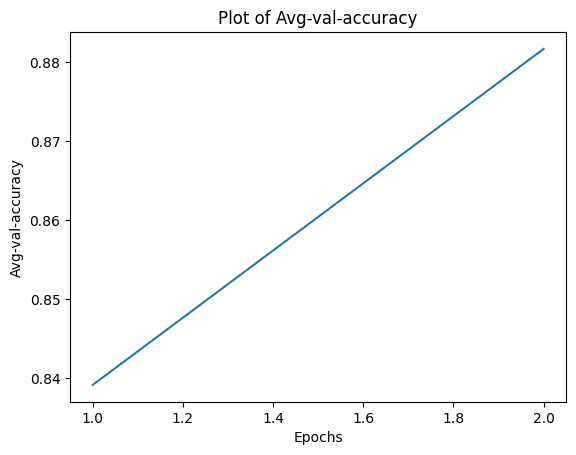

,Avg-train-loss,Avg-train-accuracy,Avg-val-loss,Avg-val-accuracy
1,0.107873,0.680761,0.107805,0.83910
2,0.107796,0.852364,0.107769,0.88165


In [17]:
plotMetric(metrics, "Avg-val-accuracy")
metrics.tail(2)

## Question Box (10pts + 5pts bonus)

1- Do we even need normalization for tasks like this? will they provide any accuracy gain? write what you think.
<br/>
Normalization is often critical in machine learning tasks, as it ensures that input features are on the same scale. This is particularly important for neural networks because:

Faster Convergence: Normalized inputs can make optimization algorithms converge faster by reducing the skew in the input distributions.
Prevents Exploding/Vanishing Gradients: With normalized data, activations are kept within a reasonable range, which prevents issues like exploding or vanishing gradients in deep networks.
Improved Generalization: Normalization can lead to better generalization as the model learns more effectively from balanced input distributions.
For contrastive learning tasks (like CLIP), normalization, especially feature normalization (e.g., L2 normalization), is crucial because:

It ensures that embeddings have a fixed norm, which aligns better with similarity measures like cosine similarity.
It improves training stability and performance for tasks relying on similarity/distance metrics.
Accuracy Gain: While not guaranteed in all tasks, normalization generally leads to more consistent and better-performing models. For tasks like contrastive learning, it is often indispensable.

2- When training a neural network, what takes the memory? mention at least 4 things.
<br/>
The memory consumption during training a neural network comes from several key factors:

Model Weights: The parameters (weights and biases) of the model take memory. Larger models with more layers require more memory.
Activations: Intermediate outputs of each layer (activations) are stored for the backward pass during training.
Gradients: Gradients of the model's weights are computed and stored during backpropagation.
Optimizer States: Optimizers like Adam store additional states, such as momentum and squared gradients, for each parameter.
Batch Size: Memory usage scales with batch size as more input samples and their activations are processed in parallel.

3- find out the actual Open Ai's training configuration of Clip model.

OpenAI's CLIP model training configuration involves the following key aspects:

Dataset: Trained on a diverse dataset of 400 million image-text pairs collected from the internet.
Model Architectures:
Image Encoder: A Vision Transformer (ViT) or ResNet.
Text Encoder: A Transformer-based language model.
Optimization:
Loss Function: Contrastive loss, aligning paired image and text embeddings while separating unpaired ones.
Optimizer: Adam with weight decay.
Batch Size: Up to 32,768 samples.
Hardware: Trained on clusters of GPUs or TPUs with high memory (e.g., NVIDIA A100).
Training Duration: Several weeks on large-scale hardware setups.
If you want more up-to-date details or additional configurations, let me know, and I can search for the latest available information.

#### Bonus
4- We have an alternative clip's loss implementation, write its pseudocode.

In [ ]:
Input:
  - Image embeddings: I (shape: batch_size x embedding_dim)
  - Text embeddings: T (shape: batch_size x embedding_dim)
  - Temperature: τ (scalar, controls sharpness of similarity distribution)

Steps:
1. Normalize the embeddings:
   - Normalize each row of I and T to unit vectors (L2 normalization):
     I_normalized = I / ||I||
     T_normalized = T / ||T||

2. Compute similarity matrices:
   - Image-to-Text similarities (S_ij): S = I_normalized @ T_normalized.T
     (Each S_ij represents cosine similarity between the i-th image and j-th text.)
   - Scale the similarities by dividing by temperature τ:
     S_scaled = S / τ

3. Compute cross-entropy losses:
   - Define labels: Use a one-hot identity matrix (batch_size x batch_size) for ground truth:
     Labels = Identity matrix (diagonal = 1, others = 0)
   - For images as query (I → T):
     loss_image = CrossEntropyLoss(S_scaled, Labels)
   - For texts as query (T → I):
     loss_text = CrossEntropyLoss(S_scaled.T, Labels)

4. Combine the losses:
   - Total loss: loss = (loss_image + loss_text) / 2

5. Output the total loss.

Output:
  - Contrastive loss for the batch.
